# Construisez un modèle de scoring
For this project, I am going to be a Data Scientist in a financial company. It's name is "Prêt à dépenser". It offers consumer credit for people with little or no previous loan history.

To grant consumer credit, the company wants to implement a “credit scoring” tool that calculates the probability that a customer will repay it or not, then classify the request: credit granted or refused. She therefore wants to develop a classification algorithm to help decide whether a loan can be granted to a client.
Customer relationship managers will be the users of the scoring tool. Since they are aimed at customers, they need your model to be easily interpretable. Relationship managers also want to have a measure of the importance of the variables that led the model to give this probability to a customer.

In [1]:
import sys
# import your modules and packages from anywhere, i.e., from any directory on your computer.
sys.path.append('../../utils/utils/')

In [2]:
import mydata as data
import visualizer as viz
from enums import DensityTypes
import data_processing as dp
import numpy as np

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import scipy.stats as st

# File system manangement
import os
import gc
import time

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from lightgbm import LGBMClassifier

from sklearn import decomposition
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn import model_selection

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


from functions import *
from utils import *

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"


ModuleNotFoundError: No module named 'lightgbm'

# Importing and understanding the datasets
First, let's import the dataset. We will use the dataset that we downloaded from the [following link](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Implémenter+un+modèle+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip).

This data consists of 
 - a loan history;
 - a history of financial information;
 - information on borrower behavior (whether the borrower has defaulted or not).

In [3]:
import helpers as hlp
hlp.get_list_of_files('data/')

['application_test.csv',
 '.DS_Store',
 'HomeCredit_columns_description.csv',
 'POS_CASH_balance.csv',
 'preprocess',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'application_train.csv',
 'bureau.csv',
 'previous_application.csv',
 'bureau_balance.csv',
 'sample_submission.csv']

## Data sets description

There are 7 different sources of data:

 - application_train/application_test: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating 0: the loan was repaid or 1: the loan was not repaid.
 - bureau: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
 - bureau_balance: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.
 - previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.
 - POS_CASH_BALANCE: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
 - credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
 - installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.
 
 A breaf explanation of the data and it's organization in different files can be seen in the following image:
 
 <img src="img/home_credit.png" width="1000" height="800"/>
 
 
`SK_ID_CURR` is connecting the dataframes `application_train` and `application_test` with `bureau`, `previous_application`, `POS_CASH_BALANCE`. installments_payment and credit_card_balance. `SK_ID_PREV` connects dataframe `previous_application` with `POS_CASH_balance`, `installments_payment` and `credit_card_balance`. `SK_ID_BUREAU` connects dataframe bureau with dataframe bureau_balance.

Let us examine the `Columns description` dataset that will just give us the the tables the columns and their descriptions.

In [4]:
mydata = data.MyData(filename = 'data/HomeCredit_columns_description.csv', dataname = 'Data description', isInfo=True, sep=',', encoding='utf-8', encoding_errors='ignore')

Loading data - done in 0s
2023-03-13 16:53:03,542 - custom_logger - INFO - Data loaded.
2023-03-13 16:53:03,543 - custom_logger - INFO - My Data Initialized and loaded


In [5]:
mydata.dataname

'Data description'

In [6]:
mydata.data.head()

Unnamed: 0                         Table                 Row  \
0           1  application_{train|test}.csv          SK_ID_CURR   
1           2  application_{train|test}.csv              TARGET   
2           5  application_{train|test}.csv  NAME_CONTRACT_TYPE   
3           6  application_{train|test}.csv         CODE_GENDER   
4           7  application_{train|test}.csv        FLAG_OWN_CAR   

                                         Description Special  
0                           ID of loan in our sample     NaN  
1  Target variable (1 - client with payment diffi...     NaN  
2        Identification if loan is cash or revolving     NaN  
3                               Gender of the client     NaN  
4                      Flag if the client owns a car     NaN

In [7]:
mydata.get_column_names()

['Unnamed: 0', 'Table', 'Row', 'Description', 'Special']

In [8]:
mydata.get_summary_statistics()

Unnamed: 0
count  219.000000
mean   111.981735
std     63.395726
min      1.000000
25%     57.500000
50%    112.000000
75%    166.500000
max    221.000000

In [9]:
mydata.get_missing_values_table()

2023-03-13 16:53:05,027 - custom_logger - INFO - Your selected dataframe has 5 columns.
There are 1 columns that have missing values.


Missing Values  % of Total Values
Special             133               60.7

In [10]:
del mydata

## Application train dataset: `df_train`

In [11]:
df_train = data.MyData(filename = 'data/application_train.csv', dataname = 'Train data', isInfo=True)
viz_df_train = viz.DataVisualizer(df_train)
process_df_train = dp.DataProcessingAndFeaturing(df_train)

Loading data - done in 2s
2023-03-13 16:53:07,550 - custom_logger - INFO - Data loaded.
2023-03-13 16:53:07,550 - custom_logger - INFO - Data loaded.
2023-03-13 16:53:07,557 - custom_logger - INFO - My Data Initialized and loaded
2023-03-13 16:53:07,557 - custom_logger - INFO - My Data Initialized and loaded
2023-03-13 16:53:07,559 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:07,559 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:07,559 - custom_logger - INFO - DataInputter initialized.


In [12]:
df_train.get_missing_values_table()

2023-03-13 16:53:08,471 - custom_logger - INFO - Your selected dataframe has 122 columns.
There are 67 columns that have missing values.
2023-03-13 16:53:08,471 - custom_logger - INFO - Your selected dataframe has 122 columns.
There are 67 columns that have missing values.
2023-03-13 16:53:08,471 - custom_logger - INFO - Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


Missing Values  % of Total Values
COMMONAREA_MEDI                   214865               69.9
COMMONAREA_AVG                    214865               69.9
COMMONAREA_MODE                   214865               69.9
NONLIVINGAPARTMENTS_MEDI          213514               69.4
NONLIVINGAPARTMENTS_MODE          213514               69.4
...                                  ...                ...
EXT_SOURCE_2                         660                0.2
AMT_GOODS_PRICE                      278                0.1
AMT_ANNUITY                           12                0.0
CNT_FAM_MEMBERS                        2                0.0
DAYS_LAST_PHONE_CHANGE                 1                0.0

[67 rows x 2 columns]

In [13]:
df_train.get_dtypes()

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object

In [14]:
df_train.get_value_counts(column='TARGET')

0    282686
1     24825
Name: TARGET, dtype: int64

In [15]:
df_train.get_unique_values()

SK_ID_CURR                    307511
TARGET                             2
NAME_CONTRACT_TYPE                 2
CODE_GENDER                        3
FLAG_OWN_CAR                       2
                               ...  
AMT_REQ_CREDIT_BUREAU_DAY          9
AMT_REQ_CREDIT_BUREAU_WEEK         9
AMT_REQ_CREDIT_BUREAU_MON         24
AMT_REQ_CREDIT_BUREAU_QRT         11
AMT_REQ_CREDIT_BUREAU_YEAR        25
Length: 122, dtype: int64

In [16]:
df_train.get_number_of_unique_values(column='CODE_GENDER')


3

In [17]:
df_train.get_number_of_unique_values_by_dtypes(dtypes=['object'])

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Most of the categorical variables have a relatively small number of unique entries. We will need to find a way to deal with these categorical variables!

## Application test datastet: `df_test`

In [18]:
df_test = data.MyData(filename = 'data/application_test.csv', dataname = 'Test data', isInfo=True)
viz_df_test = viz.DataVisualizer(df_test)
process_df_test = dp.DataProcessing(df_test)

Loading data - done in 0s
2023-03-13 16:53:09,895 - custom_logger - INFO - Data loaded.
2023-03-13 16:53:09,895 - custom_logger - INFO - Data loaded.
2023-03-13 16:53:09,895 - custom_logger - INFO - Data loaded.
2023-03-13 16:53:09,895 - custom_logger - INFO - Data loaded.
2023-03-13 16:53:09,897 - custom_logger - INFO - My Data Initialized and loaded
2023-03-13 16:53:09,897 - custom_logger - INFO - My Data Initialized and loaded
2023-03-13 16:53:09,897 - custom_logger - INFO - My Data Initialized and loaded
2023-03-13 16:53:09,897 - custom_logger - INFO - My Data Initialized and loaded
2023-03-13 16:53:09,899 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:09,899 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:09,899 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:09,899 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:09,899 - custom_logger - INFO - DataInputter initialized.


In [19]:
df_test.data.shape

(48744, 121)

In [20]:
df_test.data.head(5)

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

In [21]:
df_test.get_missing_values_table()

2023-03-13 16:53:10,364 - custom_logger - INFO - Your selected dataframe has 121 columns.
There are 64 columns that have missing values.
2023-03-13 16:53:10,364 - custom_logger - INFO - Your selected dataframe has 121 columns.
There are 64 columns that have missing values.
2023-03-13 16:53:10,364 - custom_logger - INFO - Your selected dataframe has 121 columns.
There are 64 columns that have missing values.
2023-03-13 16:53:10,364 - custom_logger - INFO - Your selected dataframe has 121 columns.
There are 64 columns that have missing values.
2023-03-13 16:53:10,364 - custom_logger - INFO - Your selected dataframe has 121 columns.
There are 64 columns that have missing values.


Missing Values  % of Total Values
COMMONAREA_MODE                    33495               68.7
COMMONAREA_MEDI                    33495               68.7
COMMONAREA_AVG                     33495               68.7
NONLIVINGAPARTMENTS_MEDI           33347               68.4
NONLIVINGAPARTMENTS_AVG            33347               68.4
...                                  ...                ...
OBS_60_CNT_SOCIAL_CIRCLE              29                0.1
DEF_30_CNT_SOCIAL_CIRCLE              29                0.1
OBS_30_CNT_SOCIAL_CIRCLE              29                0.1
AMT_ANNUITY                           24                0.0
EXT_SOURCE_2                           8                0.0

[64 rows x 2 columns]

In [22]:
df_test.get_dtypes()

SK_ID_CURR                      int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
FLAG_OWN_REALTY                object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 121, dtype: object

In [23]:
df_test.get_number_of_unique_values_by_dtypes(dtypes=['object'])

NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               7
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

## Bureau balance dataset: `df_bureau_balance`

In [24]:
df_bureau_balance = data.MyData(filename = 'data/bureau_balance.csv', dataname = 'Bureau balance', isInfo=False)
viz_df_bureau_balance = viz.DataVisualizer(df_bureau_balance)
process_df_bureau_balance = dp.DataProcessing(df_bureau_balance)
df_bureau_balance.get_dtypes_value_counts()

Loading data - done in 3s
2023-03-13 16:53:13,811 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:13,811 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:13,811 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:13,811 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:13,811 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:13,811 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:13,811 - custom_logger - INFO - DataInputter initialized.


int64     2
object    1
dtype: int64

## Bureau dataset: `df_bureau`

In [25]:
df_bureau = data.MyData(filename = 'data/bureau.csv', dataname = 'Bureau', isInfo=False)
viz_df_bureau = viz.DataVisualizer(df_bureau)
process_df_bureau = dp.DataProcessing(df_bureau)
df_bureau.get_dtypes_value_counts()

Loading data - done in 2s
2023-03-13 16:53:15,457 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:15,457 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:15,457 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:15,457 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:15,457 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:15,457 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:15,457 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:15,457 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:15,457 - custom_logger - INFO - DataInputter initialized.


float64    8
int64      6
object     3
dtype: int64

## Credit card balance dataset: `df_credit_card_balance`

In [26]:
df_credit_card_balance = data.MyData(filename = 'data/credit_card_balance.csv', dataname = 'Credit card balance', isInfo=False)
viz_df_credit_card_balance = viz.DataVisualizer(df_credit_card_balance)
process_df_credit_card_balance = dp.DataProcessing(df_credit_card_balance)
df_credit_card_balance.get_dtypes_value_counts()

Loading data - done in 6s
2023-03-13 16:53:21,426 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:21,426 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:21,426 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:21,426 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:21,426 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:21,426 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:21,426 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:21,426 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:21,426 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:21,426 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:21,426 - custom_logger - INFO - DataInputter initialized.


float64    15
int64       7
object      1
dtype: int64

## Installments payments dataset: `df_installments_payments`

In [27]:
df_installments_payments = data.MyData(filename = 'data/installments_payments.csv', dataname = 'Credit card balance', isInfo=False)
viz_df_installments_payments = viz.DataVisualizer(df_installments_payments)
df_installments_payments.get_dtypes_value_counts()

Loading data - done in 9s


float64    5
int64      3
dtype: int64

## POS CASH balance dataset: `df_POS_CASH_balance`

In [28]:
df_POS_CASH_balance = data.MyData(filename = 'data/POS_CASH_balance.csv', dataname = 'POS_CASH_balance', isInfo=False)
viz_df_POS_CASH_balance = viz.DataVisualizer(df_POS_CASH_balance)
process_df_POS_CASH_balance = dp.DataProcessing(df_POS_CASH_balance)
df_POS_CASH_balance.get_dtypes_value_counts()

Loading data - done in 4s
2023-03-13 16:53:34,052 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:34,052 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:34,052 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:34,052 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:34,052 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:34,052 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:34,052 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:34,052 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:34,052 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:34,052 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:34,052 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:34,052 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:34,052 - custom_logger - INFO - DataInputter initialized.

int64      5
float64    2
object     1
dtype: int64

## Previous application dataset: `df_previous_application`

In [29]:
df_previous_application = data.MyData(filename = 'data/previous_application.csv', dataname = 'previous applicatin', isInfo=False)
viz_df_previous_application = viz.DataVisualizer(df_previous_application)
process_df_previous_application = dp.DataProcessing(df_previous_application)
df_previous_application.get_dtypes_value_counts()

Loading data - done in 5s
2023-03-13 16:53:39,193 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:39,193 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:39,193 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:39,193 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:39,193 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:39,193 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:39,193 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:39,193 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:39,193 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:39,193 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:39,193 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:39,193 - custom_logger - INFO - DataInputter initialized.
2023-03-13 16:53:39,193 - custom_logger - INFO - DataInputter initialized.

object     16
float64    15
int64       6
dtype: int64

# Exploratory Data Analysis (EDA)

" Exploratory Data Analysis (EDA) is the process of examining and analyzing data sets to summarize their main characteristics, often with visual methods. The goal of EDA is to discover patterns, relationships, anomalies, and insights in the data, and to provide a foundation for further analysis.

EDA typically involves the following steps:

 - Data collection: Collecting data from various sources, such as databases, CSV files, APIs, or web scraping.
 - Data cleaning: Checking for missing data, removing duplicates, handling outliers and invalid values, and transforming data into a consistent format.
 - Data visualization: Creating visual representations of the data to identify patterns, trends, and relationships.
 - Data exploration: Using statistical analysis techniques to explore the data and test hypotheses.
 - Communicating results: Summarizing the insights gained from the analysis and communicating them effectively to stakeholders.

EDA can be performed using various tools and techniques, such as statistical software like `R` or `Python`, data visualization libraries like `matplotlib` or `seaborn`, and interactive tools like `Tableau` or `Power BI`.

EDA is a critical step in the data science process, as it helps to uncover important information about the data and identify potential issues that need to be addressed. It can also inform the selection of appropriate modeling techniques and data preprocessing steps. " - ChatGBT answer on 'What is EDA?'

## Examine missing values
### Application train

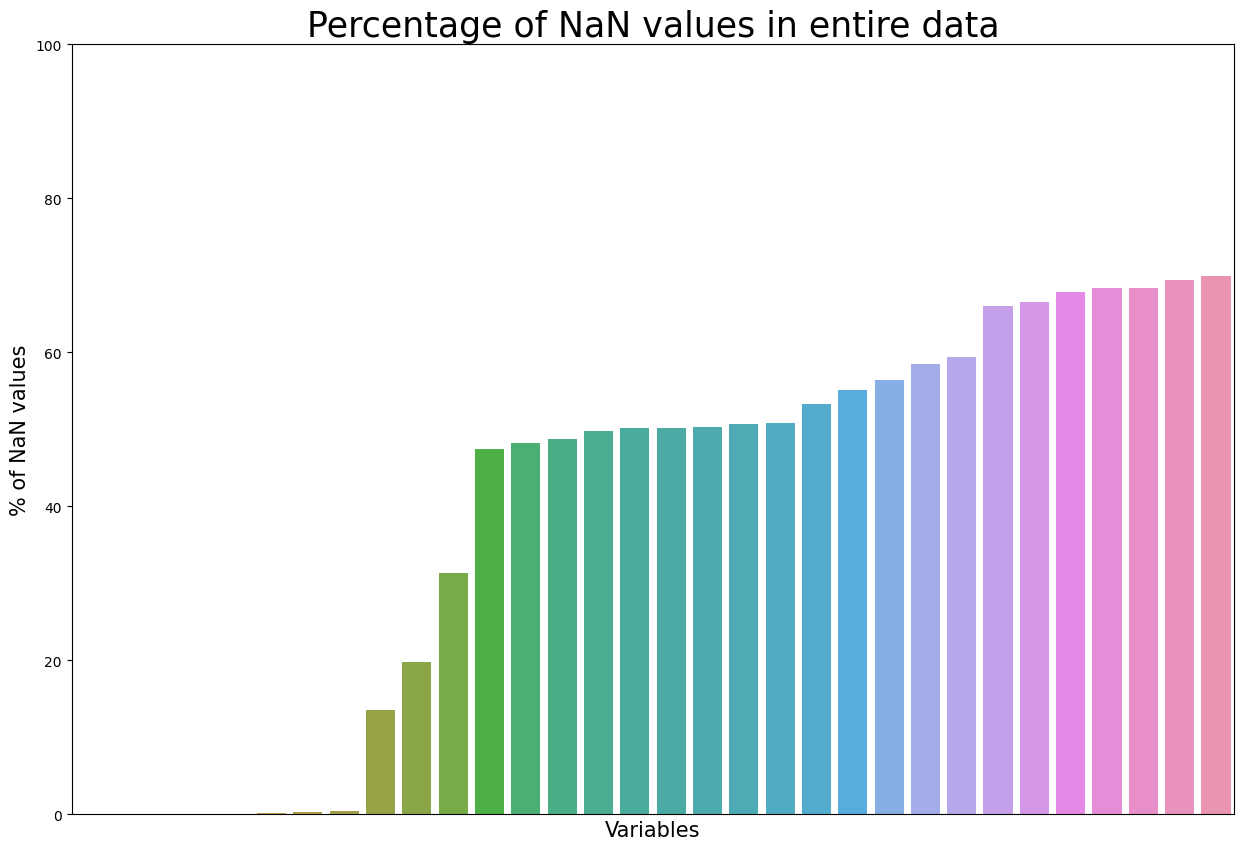

In [13]:
viz_df_train.plot_nan_in_purcentage()

In [14]:
# Missing values statistics
df_train.get_missing_values_table().head(20)

2023-03-10 11:04:04,165 - custom_logger - INFO - Your selected dataframe has 122 columns.
There are 67 columns that have missing values.
2023-03-10 11:04:04,165 - custom_logger - INFO - Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


Missing Values  % of Total Values
COMMONAREA_MEDI                   214865               69.9
COMMONAREA_AVG                    214865               69.9
COMMONAREA_MODE                   214865               69.9
NONLIVINGAPARTMENTS_MEDI          213514               69.4
NONLIVINGAPARTMENTS_MODE          213514               69.4
NONLIVINGAPARTMENTS_AVG           213514               69.4
FONDKAPREMONT_MODE                210295               68.4
LIVINGAPARTMENTS_MODE             210199               68.4
LIVINGAPARTMENTS_MEDI             210199               68.4
LIVINGAPARTMENTS_AVG              210199               68.4
FLOORSMIN_MODE                    208642               67.8
FLOORSMIN_MEDI                    208642               67.8
FLOORSMIN_AVG                     208642               67.8
YEARS_BUILD_MODE                  204488               66.5
YEARS_BUILD_MEDI                  204488               66.5
YEARS_BUILD_AVG                   204488               66.5
OWN_CAR_AGE                       202929               66.0
LANDAREA_AVG                      182590               59.4
LANDAREA_MEDI                     182590               59.4
LANDAREA_MODE                     182590               59.4

### Application test

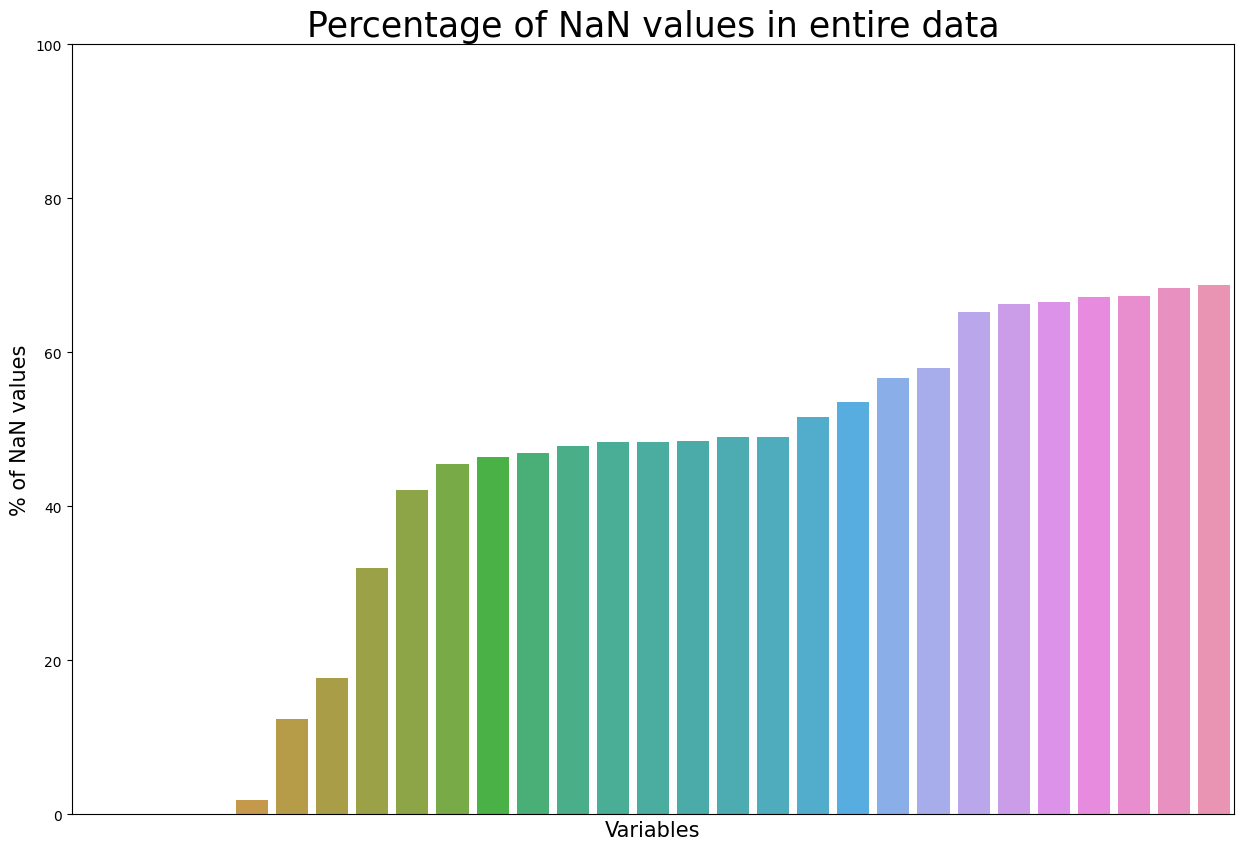

In [6]:
viz_df_test.plot_nan_in_purcentage()

In [30]:
# Missing values statistics
df_test.get_missing_values_table().head(20)

2023-03-09 13:06:12,148 - custom_logger - INFO - Your selected dataframe has 121 columns.
There are 64 columns that have missing values.
2023-03-09 13:06:12,148 - custom_logger - INFO - Your selected dataframe has 121 columns.
There are 64 columns that have missing values.
2023-03-09 13:06:12,148 - custom_logger - INFO - Your selected dataframe has 121 columns.
There are 64 columns that have missing values.
2023-03-09 13:06:12,148 - custom_logger - INFO - Your selected dataframe has 121 columns.
There are 64 columns that have missing values.
2023-03-09 13:06:12,148 - custom_logger - INFO - Your selected dataframe has 121 columns.
There are 64 columns that have missing values.
2023-03-09 13:06:12,148 - custom_logger - INFO - Your selected dataframe has 121 columns.
There are 64 columns that have missing values.


Missing Values  % of Total Values
COMMONAREA_MODE                    33495               68.7
COMMONAREA_MEDI                    33495               68.7
COMMONAREA_AVG                     33495               68.7
NONLIVINGAPARTMENTS_MEDI           33347               68.4
NONLIVINGAPARTMENTS_AVG            33347               68.4
NONLIVINGAPARTMENTS_MODE           33347               68.4
FONDKAPREMONT_MODE                 32797               67.3
LIVINGAPARTMENTS_MODE              32780               67.2
LIVINGAPARTMENTS_MEDI              32780               67.2
LIVINGAPARTMENTS_AVG               32780               67.2
FLOORSMIN_MEDI                     32466               66.6
FLOORSMIN_MODE                     32466               66.6
FLOORSMIN_AVG                      32466               66.6
OWN_CAR_AGE                        32312               66.3
YEARS_BUILD_AVG                    31818               65.3
YEARS_BUILD_MEDI                   31818               65.3
YEARS_BUILD_MODE                   31818               65.3
LANDAREA_MODE                      28254               58.0
LANDAREA_AVG                       28254               58.0
LANDAREA_MEDI                      28254               58.0

### Bureau balance 

In [32]:
# Missing values statistics
df_bureau_balance.get_missing_values_table()

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

### Bureau

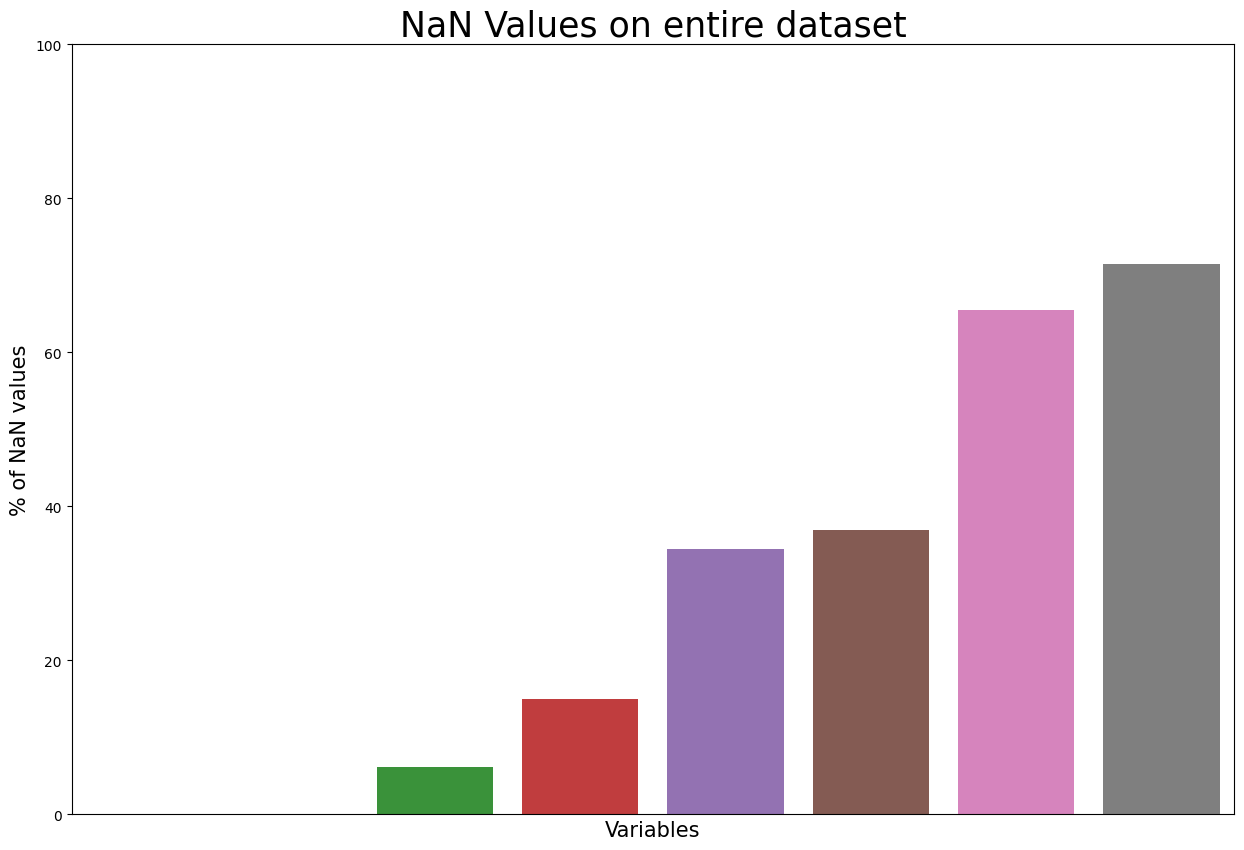

In [33]:
viz_df_bureau.plot_nan_in_purcentage()

In [34]:
# Missing values statistics
df_bureau.get_missing_values_table()

Missing Values  % of Total Values
AMT_ANNUITY                    1226791               71.5
AMT_CREDIT_MAX_OVERDUE         1124488               65.5
DAYS_ENDDATE_FACT               633653               36.9
AMT_CREDIT_SUM_LIMIT            591780               34.5
AMT_CREDIT_SUM_DEBT             257669               15.0
DAYS_CREDIT_ENDDATE             105553                6.1
AMT_CREDIT_SUM                      13                0.0

### Creadit card balance

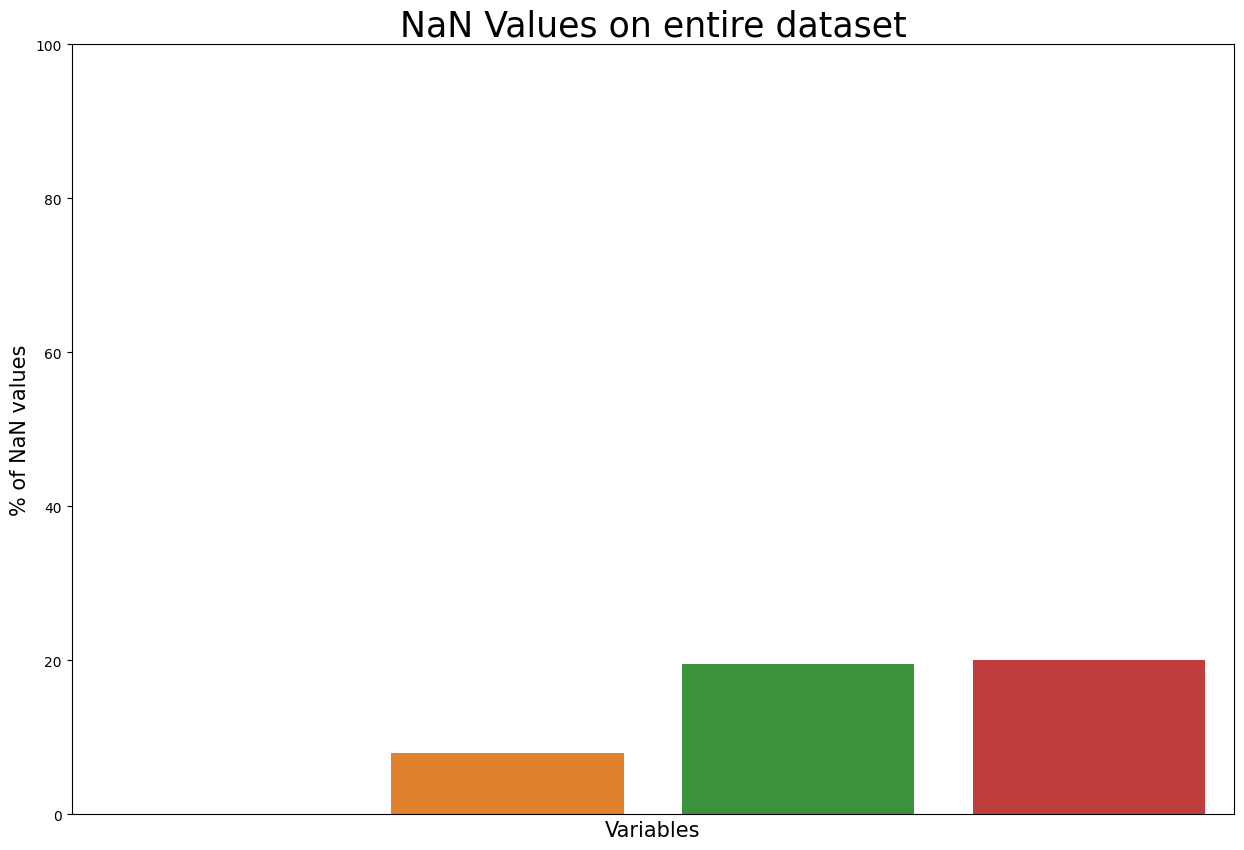

In [36]:
viz_df_credit_card_balance.plot_nan_in_purcentage()

In [35]:
# Missing values statistics
df_credit_card_balance.get_missing_values_table()

Missing Values  % of Total Values
AMT_PAYMENT_CURRENT                 767988               20.0
AMT_DRAWINGS_ATM_CURRENT            749816               19.5
AMT_DRAWINGS_OTHER_CURRENT          749816               19.5
AMT_DRAWINGS_POS_CURRENT            749816               19.5
CNT_DRAWINGS_ATM_CURRENT            749816               19.5
CNT_DRAWINGS_OTHER_CURRENT          749816               19.5
CNT_DRAWINGS_POS_CURRENT            749816               19.5
AMT_INST_MIN_REGULARITY             305236                7.9
CNT_INSTALMENT_MATURE_CUM           305236                7.9

### Installments payments

In [37]:
# Missing values statistics
df_installments_payments.get_missing_values_table()

Missing Values  % of Total Values
DAYS_ENTRY_PAYMENT            2905                0.0
AMT_PAYMENT                   2905                0.0

### POS Cash balance

In [41]:
# Missing values statistics
df_POS_CASH_balance.get_missing_values_table()

Missing Values  % of Total Values
CNT_INSTALMENT_FUTURE           26087                0.3
CNT_INSTALMENT                  26071                0.3

### Previous application

In [42]:
# Missing values statistics
df_previous_application.get_missing_values_table().head(20)

Missing Values  % of Total Values
RATE_INTEREST_PRIMARY             1664263               99.6
RATE_INTEREST_PRIVILEGED          1664263               99.6
AMT_DOWN_PAYMENT                   895844               53.6
RATE_DOWN_PAYMENT                  895844               53.6
NAME_TYPE_SUITE                    820405               49.1
DAYS_FIRST_DRAWING                 673065               40.3
DAYS_FIRST_DUE                     673065               40.3
DAYS_LAST_DUE_1ST_VERSION          673065               40.3
DAYS_LAST_DUE                      673065               40.3
DAYS_TERMINATION                   673065               40.3
NFLAG_INSURED_ON_APPROVAL          673065               40.3
AMT_GOODS_PRICE                    385515               23.1
AMT_ANNUITY                        372235               22.3
CNT_PAYMENT                        372230               22.3
PRODUCT_COMBINATION                   346                0.0
AMT_CREDIT                              1                0.0


## Examine the variables in Application train dataset regarding to `TARGET`
### Unbalanced data : `TARGET` column

First we need to understand the target variable.
 - 0 means loan is repayed
 - 1 means loan is not repayed

In [31]:
df_train.get_value_counts(column='TARGET')

0    282686
1     24825
Name: TARGET, dtype: int64

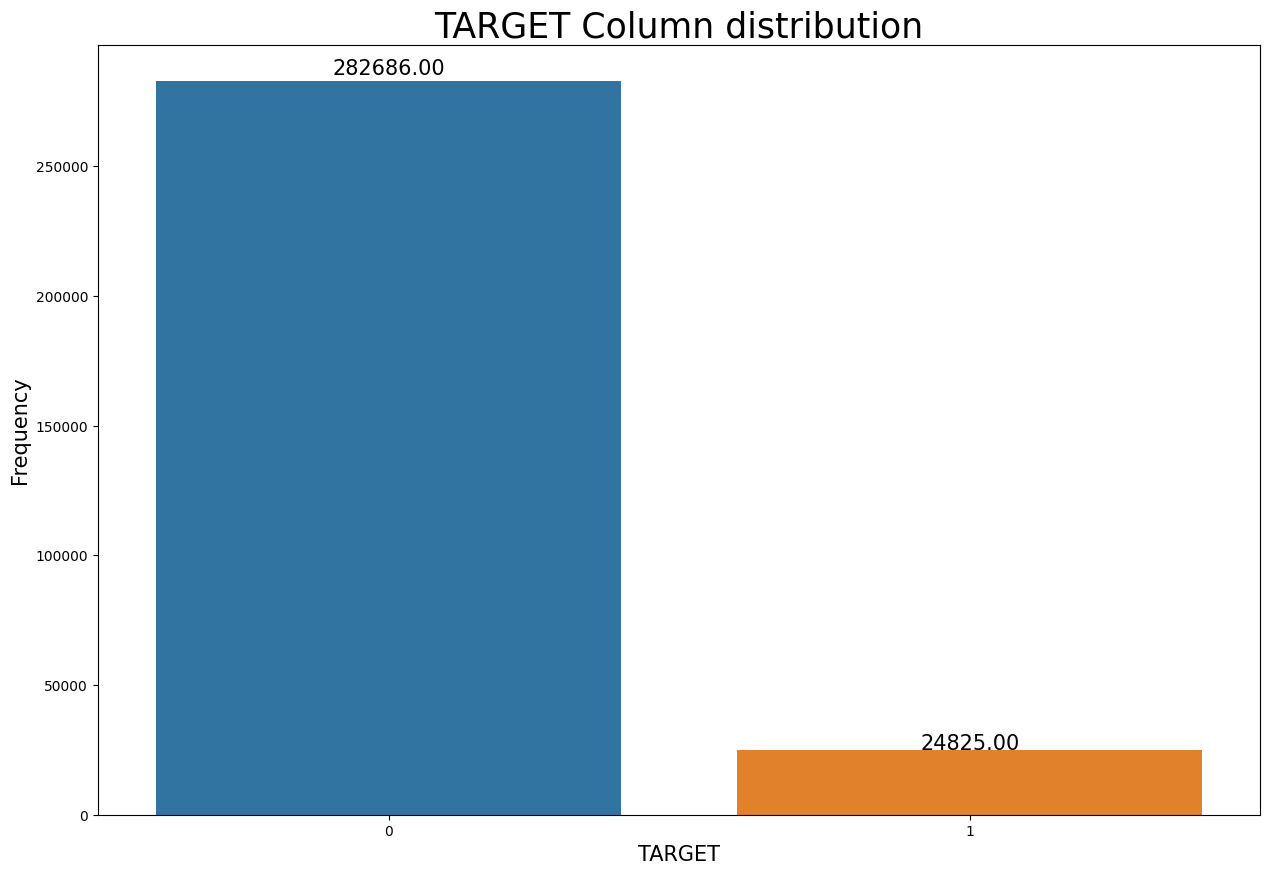

In [32]:
viz_df_train.plot_value_counts(column='TARGET', title='TARGET Column distribution', xlabel='TARGET', ylabel='Frequency')

We observe that the `TARGET` variable is inbalanced. So, we have unbalanced data and this must be taken into consideration when modeling this dataset.

### Contract types

In [33]:
df_train.get_value_counts(column='NAME_CONTRACT_TYPE', normalize=True)

Cash loans         0.904787
Revolving loans    0.095213
Name: NAME_CONTRACT_TYPE, dtype: float64

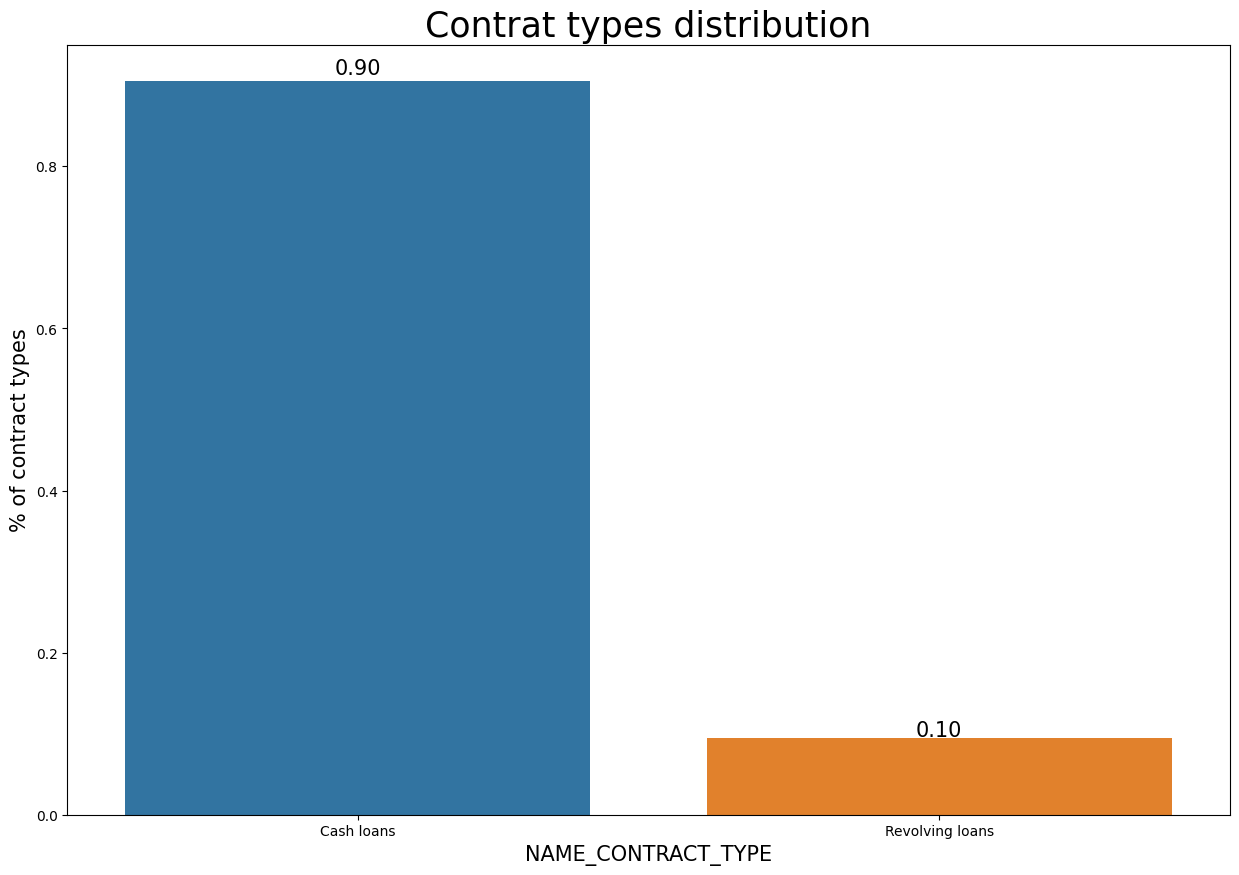

In [34]:
viz_df_train.plot_value_counts(column='NAME_CONTRACT_TYPE', inPurcent=True, title='Contrat types distribution', xlabel='NAME_CONTRACT_TYPE', ylabel='% of contract types')

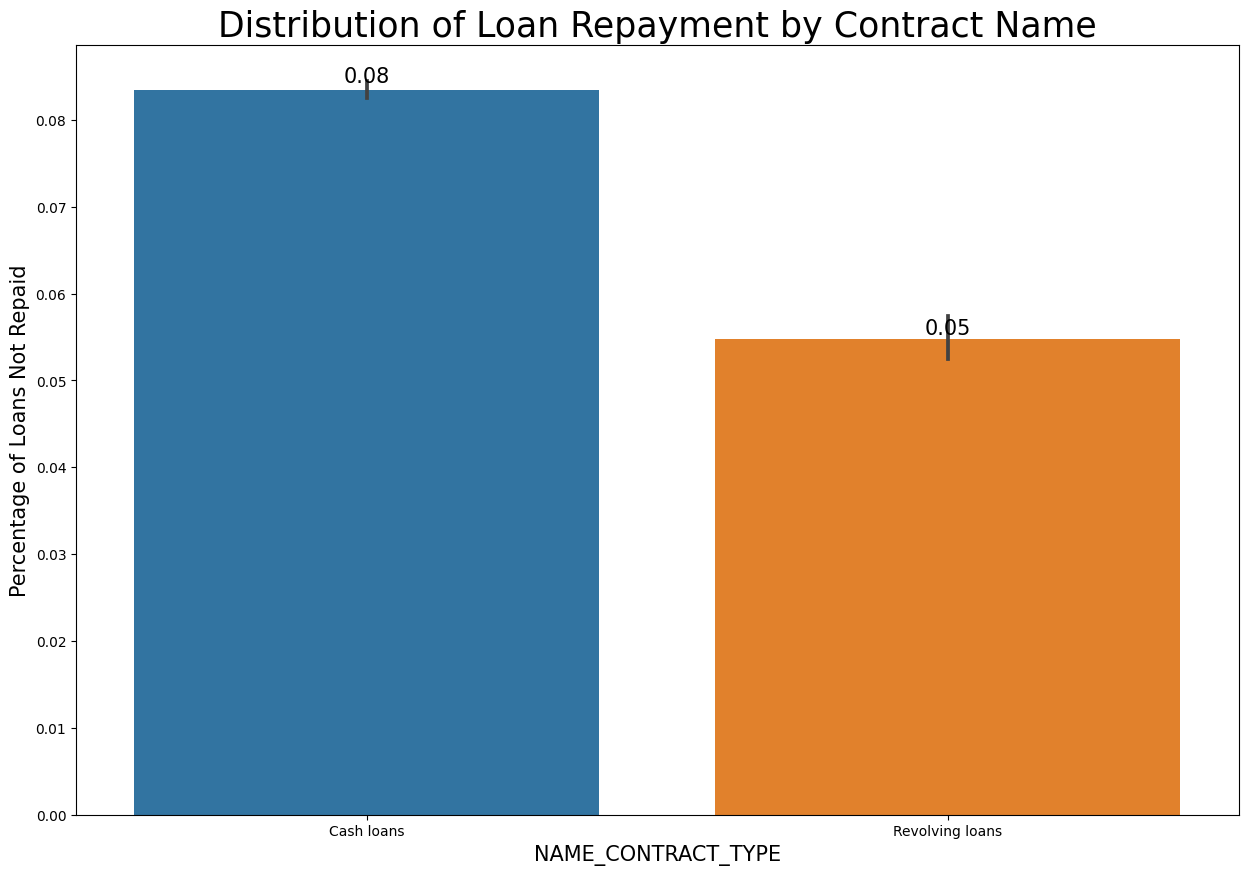

In [8]:
viz_df_train.plot_value_counts(column='NAME_CONTRACT_TYPE', target_column='TARGET', inPurcent=True, title='Distribution of Loan Repayment by Contract Name', xlabel='NAME_CONTRACT_TYPE', ylabel='Percentage of Loans Not Repaid')

Now we can easily say that we have 2 types of contract. Approximately 90% is made up of cash loans, and 10% is made up of revolving loans. As a result, the question arises, "How many of these debts are still unpaid?". The above figure explains that cash loans account for approximately 8% of unpaid debts, compared to about 5% of unpaid debts under revolving credit agreements.

Let us now examine the Stats on clients description over the contracts and nonpayed loan. The first question is to examine the gender of the clients in the contracts.

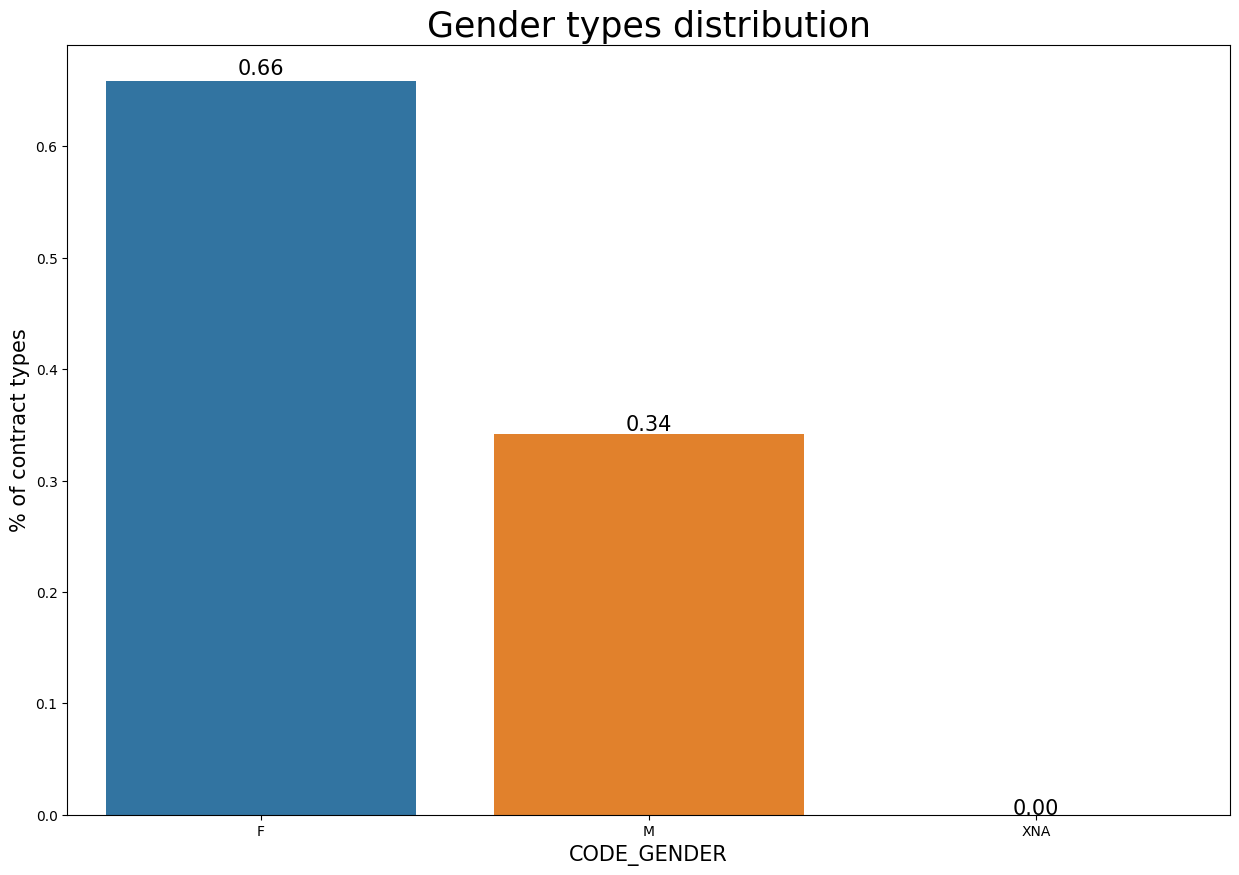

In [11]:
viz_df_train.plot_value_counts(column='CODE_GENDER', inPurcent=True, title='Gender types distribution', xlabel='CODE_GENDER', ylabel='% of contract types')

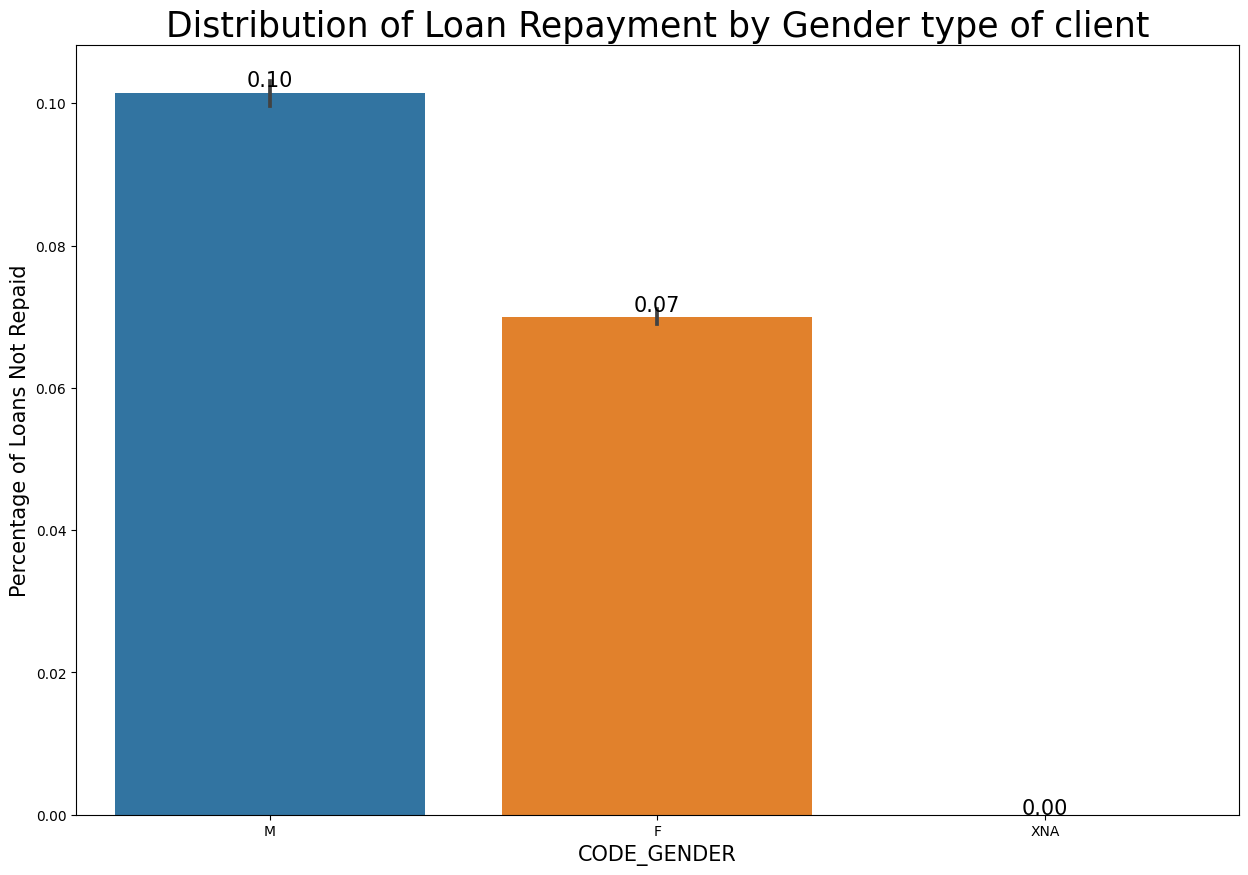

In [12]:
viz_df_train.plot_value_counts(column='CODE_GENDER', target_column='TARGET', inPurcent=True, title='Distribution of Loan Repayment by Gender type of client', xlabel='CODE_GENDER', ylabel='Percentage of Loans Not Repaid')

It has been observed that approximately 66% of contracts are made by women and 34% by men. However, what percentage of contracts are repaid by each gender? For men, the percentage of unpaid contracts is approximately 10%, while for women, the percentage is approximately 7%.

***What can we say about the client income type stats on contracts?***

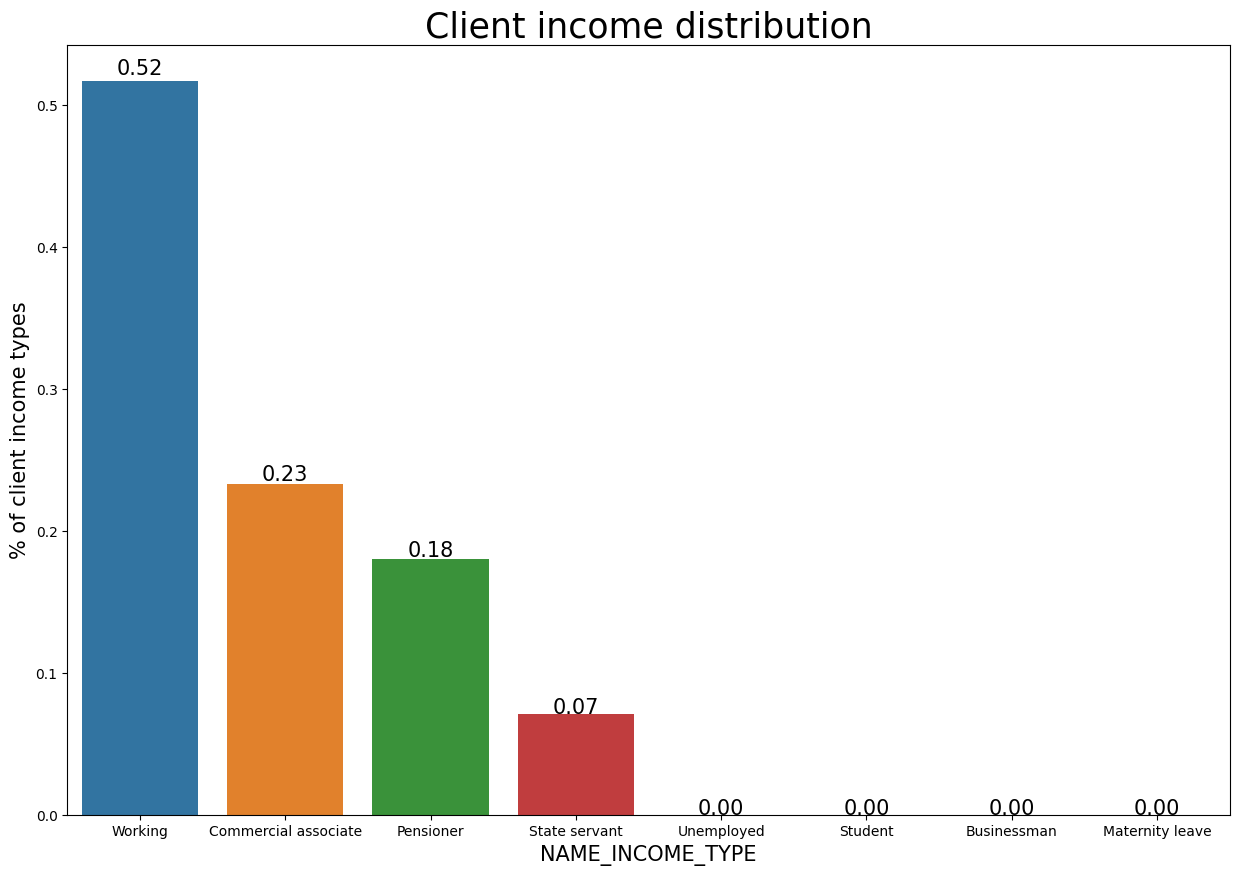

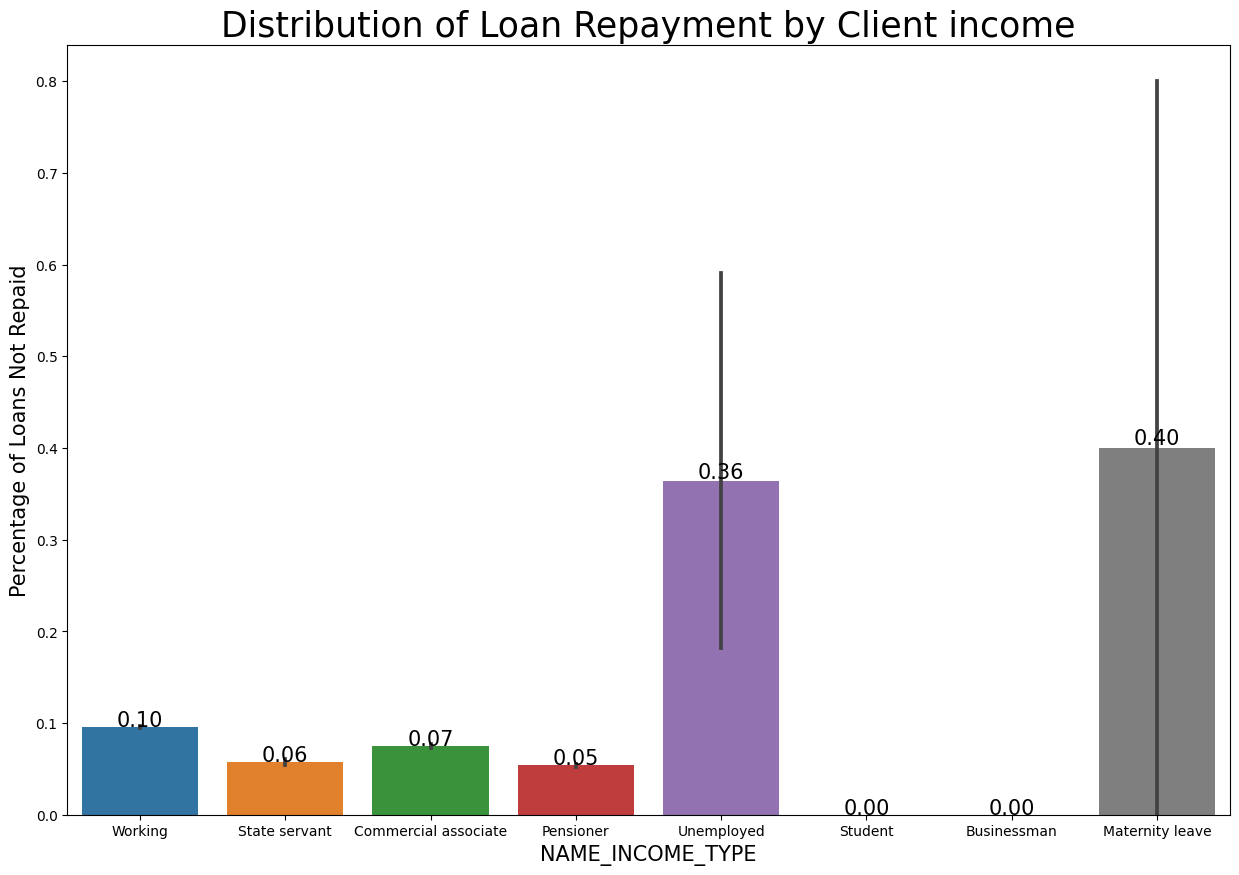

In [13]:
viz_df_train.plot_value_counts(column='NAME_INCOME_TYPE', inPurcent=True, title='Client income distribution', xlabel='NAME_INCOME_TYPE', ylabel='% of client income types')
viz_df_train.plot_value_counts(column='NAME_INCOME_TYPE', target_column='TARGET', inPurcent=True, title='Distribution of Loan Repayment by Client income', xlabel='NAME_INCOME_TYPE', ylabel='Percentage of Loans Not Repaid')

In most loans, 50% of the clients are working. These have 10% of loans not repaid.

Additionally, observe that 23% of loans are for commercial assistance, 18% are for pensioners, and 7% are for state employees.

The number of unpaid loans among the unemployed and those on maternity leave is 36% and 40%, respectively.

The next question we can ask is what we can say about the statistics of the clients' education on contracts.

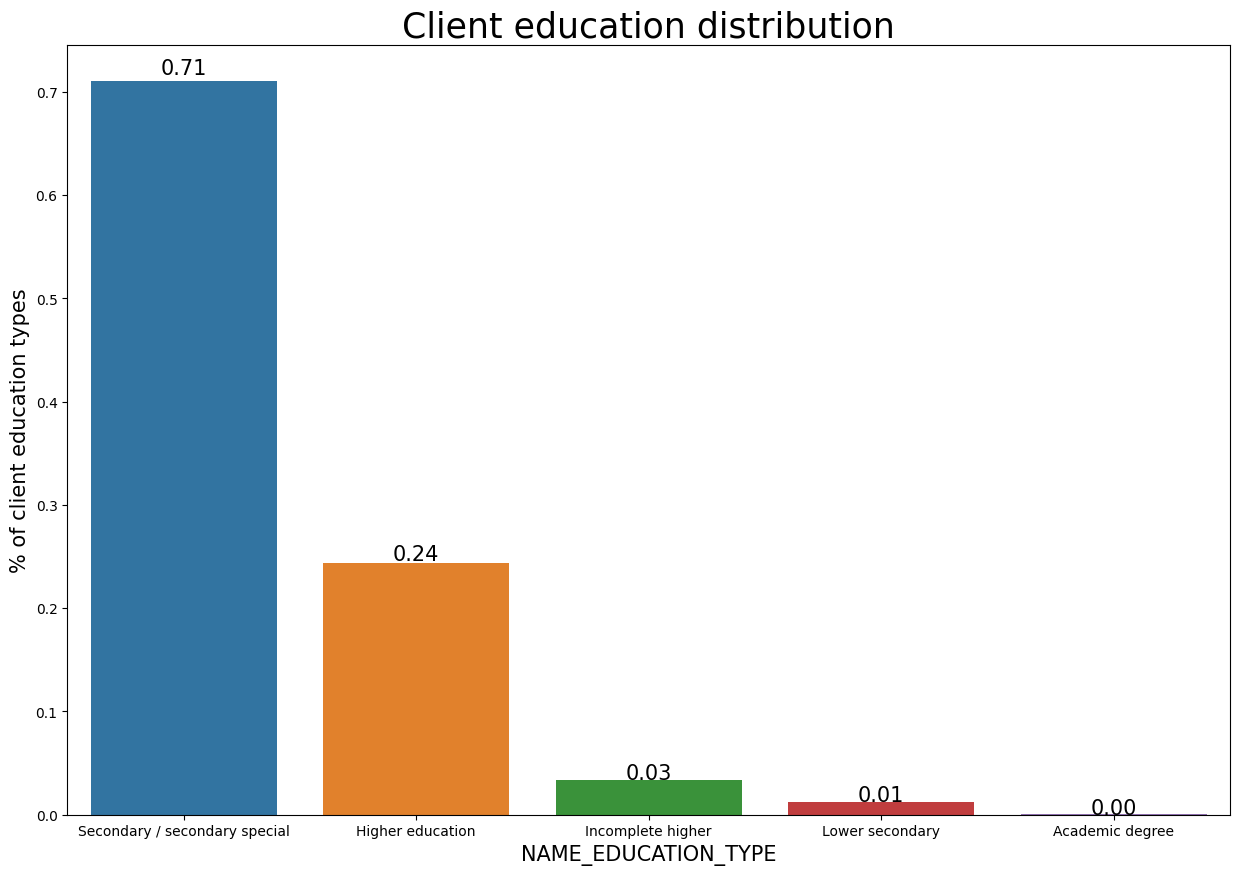

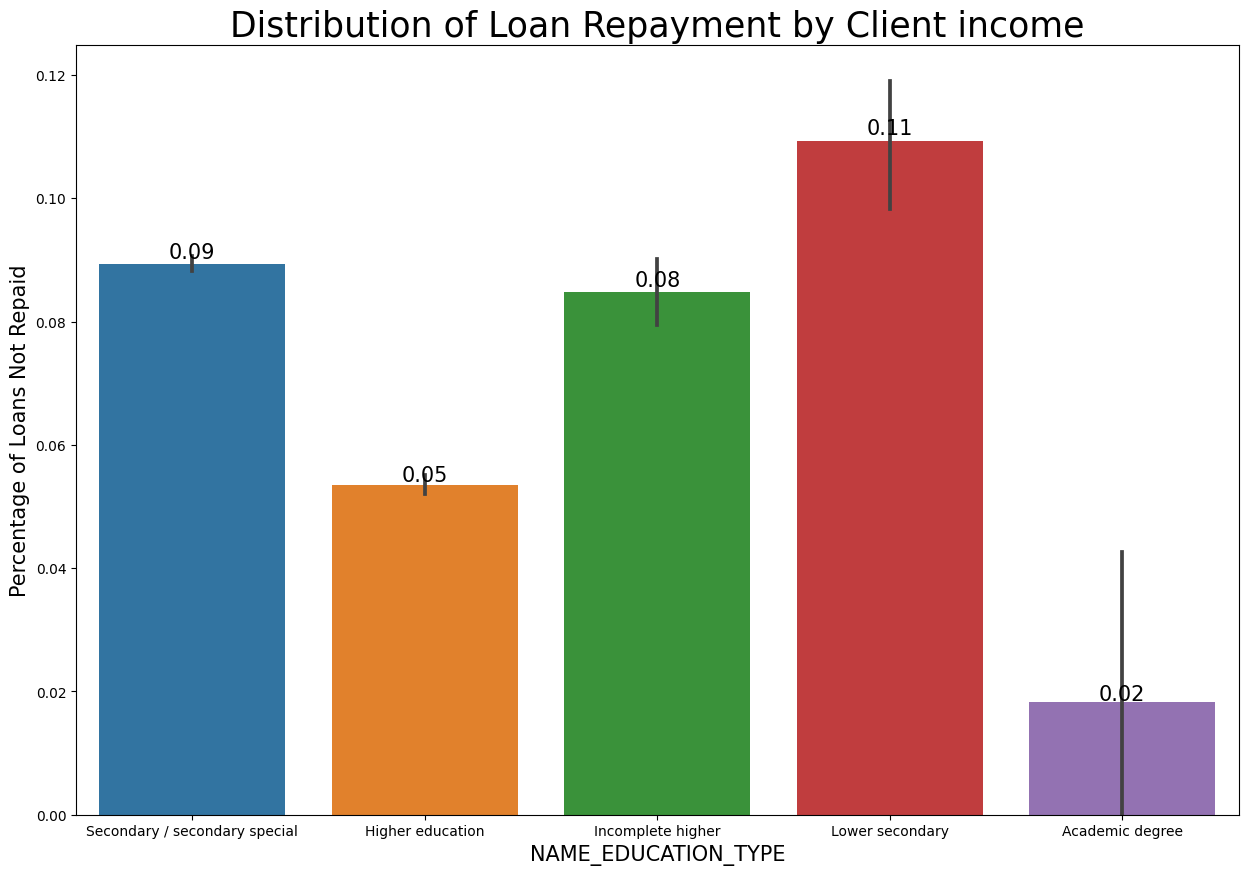

In [15]:
viz_df_train.plot_value_counts(column='NAME_EDUCATION_TYPE', inPurcent=True, title='Client education distribution', xlabel='NAME_EDUCATION_TYPE', ylabel='% of client education types')
viz_df_train.plot_value_counts(column='NAME_EDUCATION_TYPE', target_column='TARGET', inPurcent=True, title='Distribution of Loan Repayment by Client income', xlabel='NAME_EDUCATION_TYPE', ylabel='Percentage of Loans Not Repaid')

There are 71% of loans for secondary or secondary special education clients, compared to 24% for higher education clients. It is thus not surprising that the majority of customers with higher education do not have loans.

Next, we can show the most used categories of organization types.

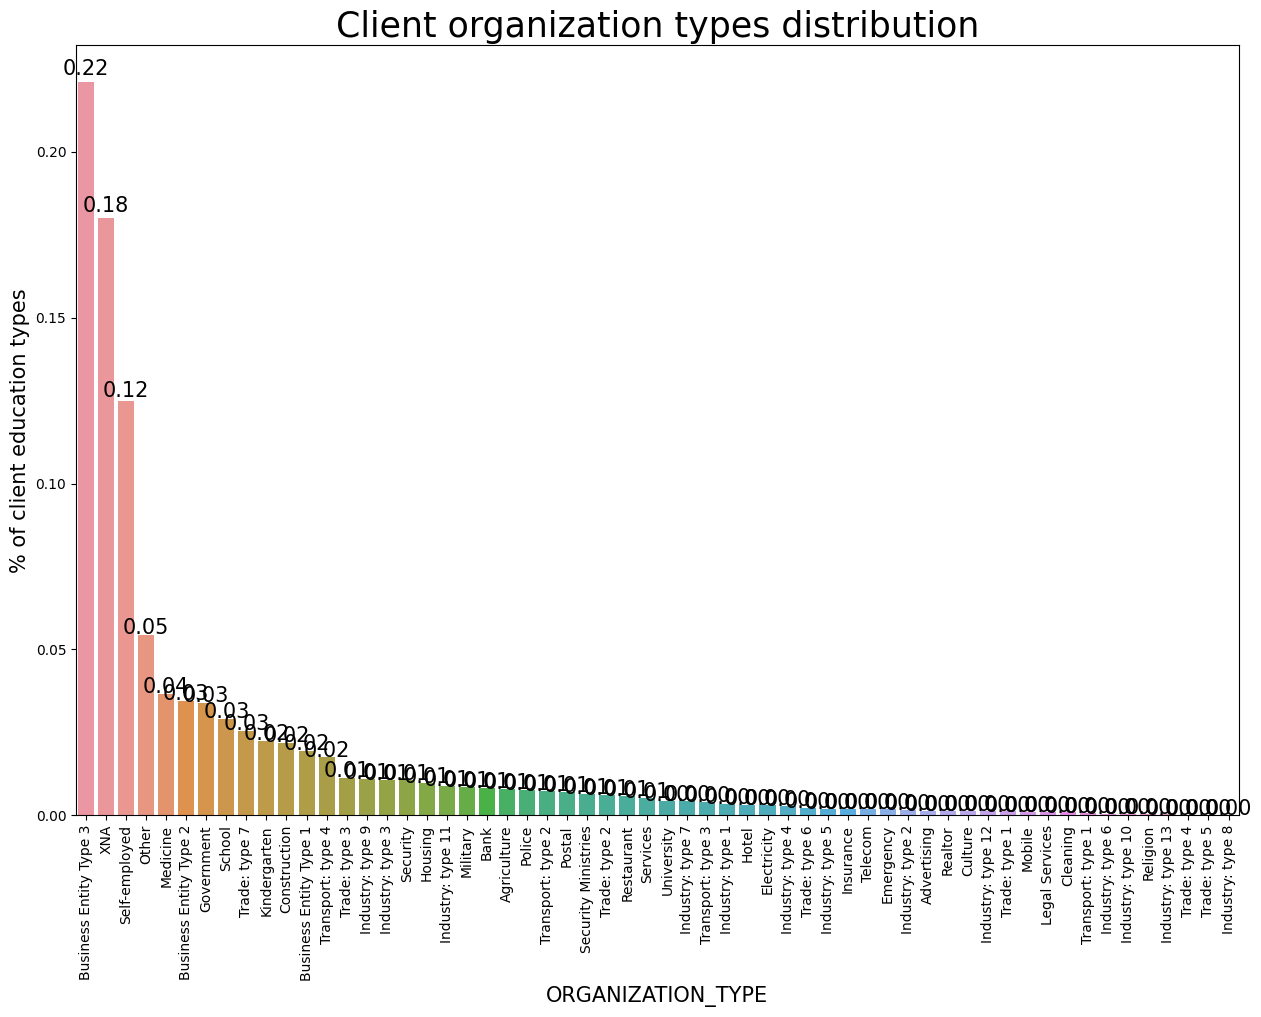

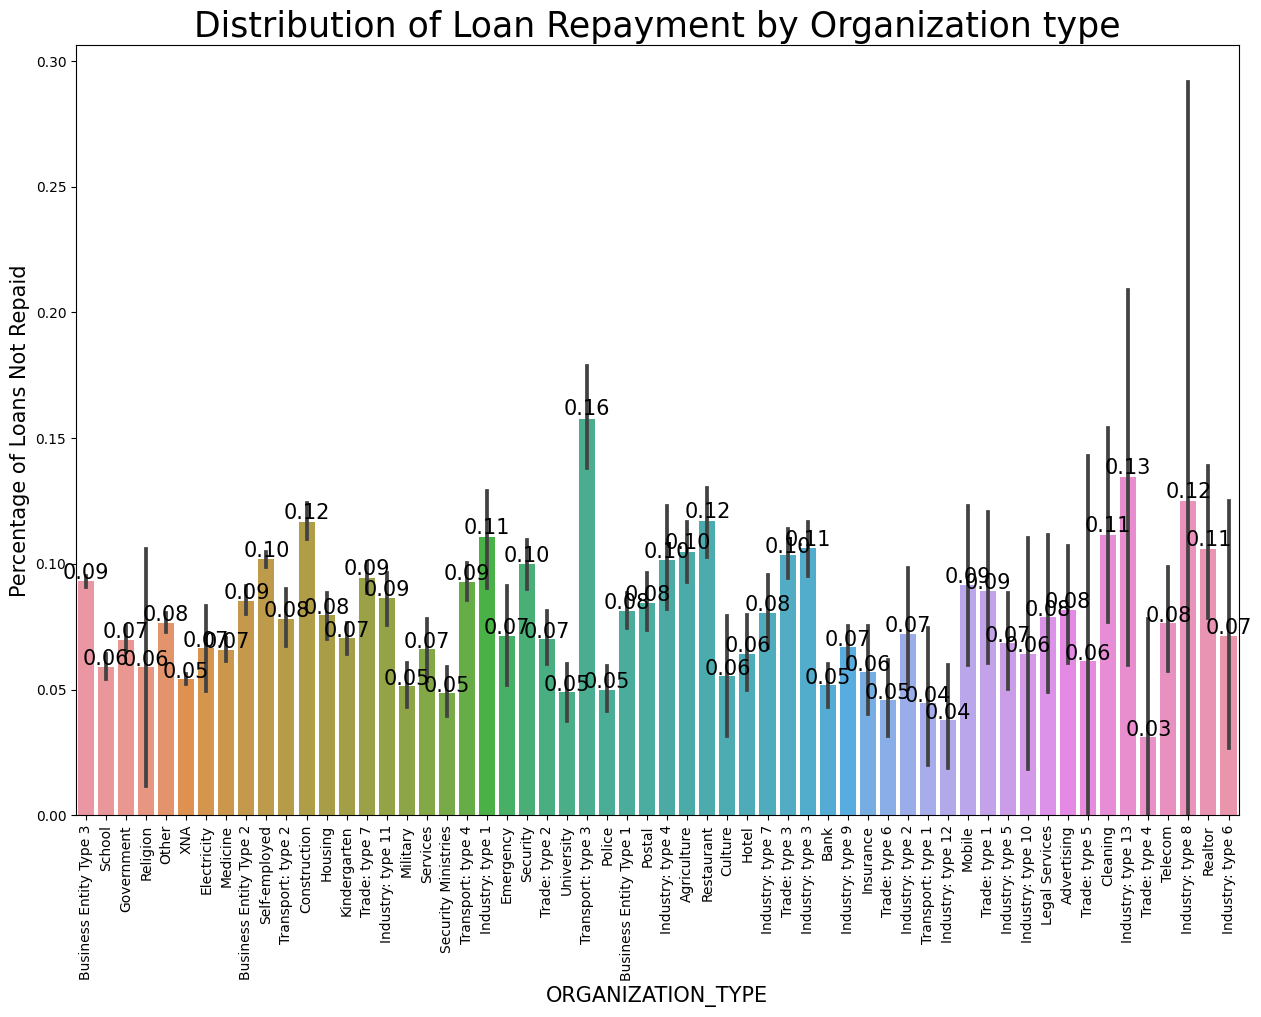

In [6]:
viz_df_train.plot_value_counts(column='ORGANIZATION_TYPE', inPurcent=True, title='Client organization types distribution', xlabel='ORGANIZATION_TYPE', ylabel='% of client education types', xrotation=90)
viz_df_train.plot_value_counts(column='ORGANIZATION_TYPE', target_column='TARGET', inPurcent=True, title='Distribution of Loan Repayment by Organization type', xlabel='ORGANIZATION_TYPE', ylabel='Percentage of Loans Not Repaid', xrotation=90)

Let us now examine the Stats on client patrimony over the contracts and nonpaid loans.

There are many different questions that we can ask when we analyze data. One of these is getting to know how clients that own cars will manage their loans.

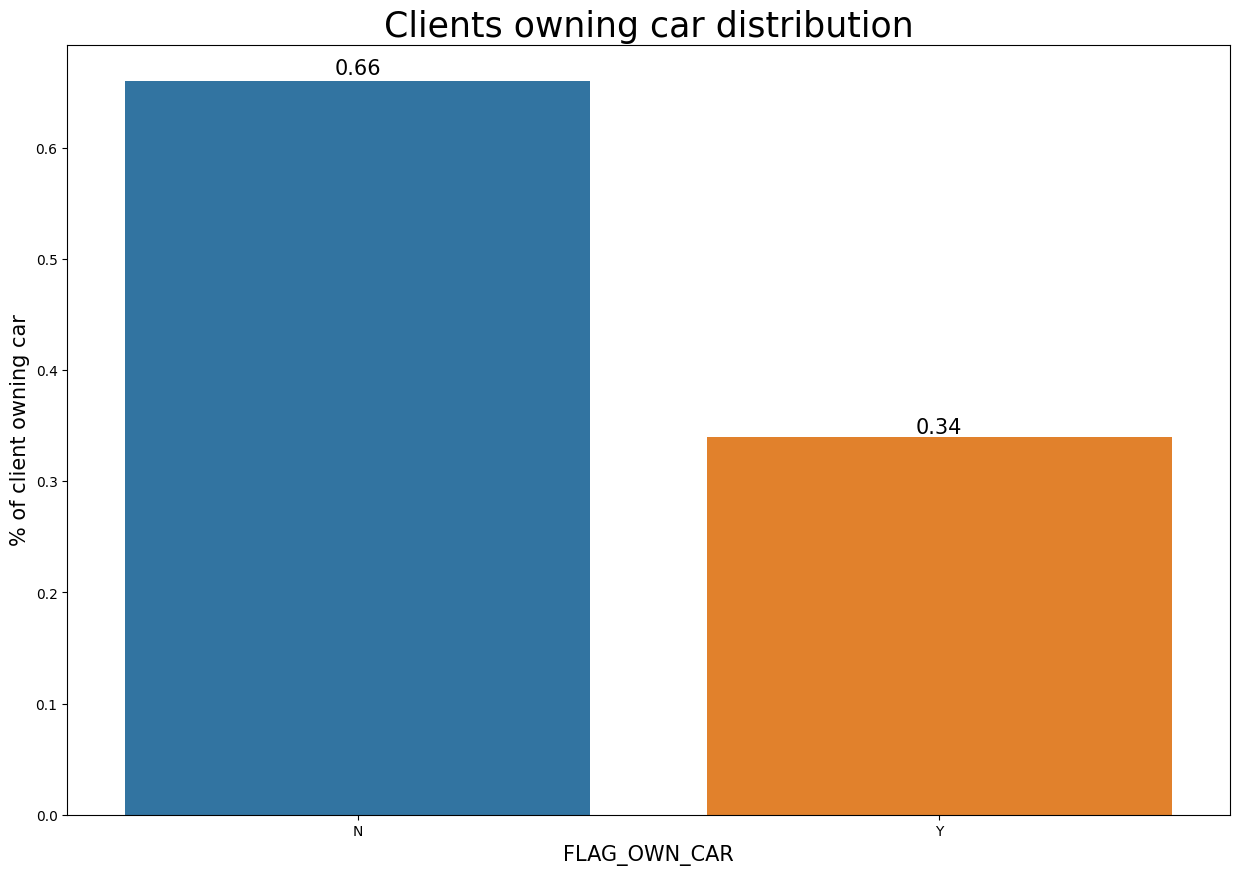

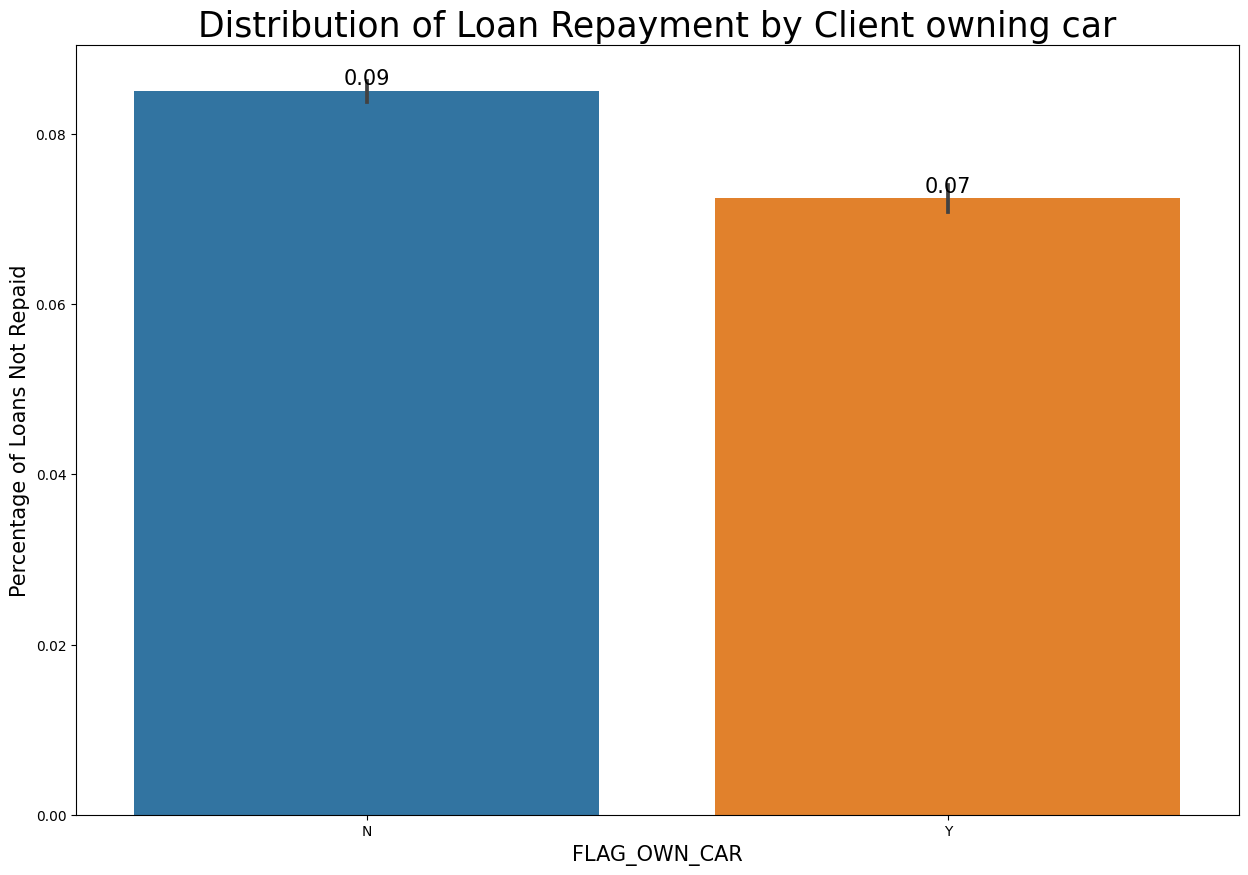

In [7]:
viz_df_train.plot_value_counts(column='FLAG_OWN_CAR', inPurcent=True, title='Clients owning car distribution', xlabel='FLAG_OWN_CAR', ylabel='% of client owning car')
viz_df_train.plot_value_counts(column='FLAG_OWN_CAR', target_column='TARGET', inPurcent=True, title='Distribution of Loan Repayment by Client owning car', xlabel='FLAG_OWN_CAR', ylabel='Percentage of Loans Not Repaid')

We can observe that about 35% of people who own cars have contracts compared to 66% of people not owning cars. Despite this, it is estimated that 7% of persons who own cars have unpaid loans, while 9% of people who do not own cars have unpaid loans. Also we can ask for how many persons owning a real estate does have unpaid loans.

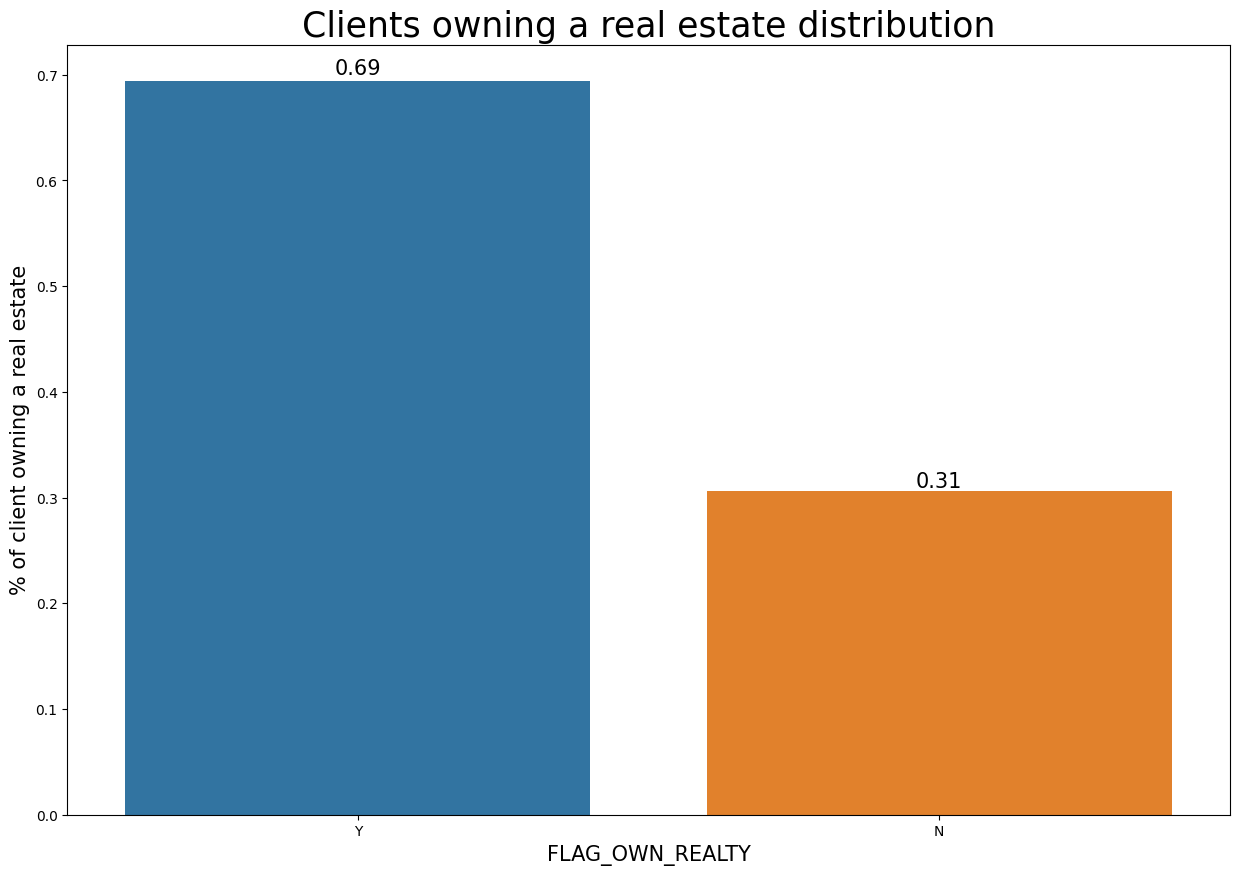

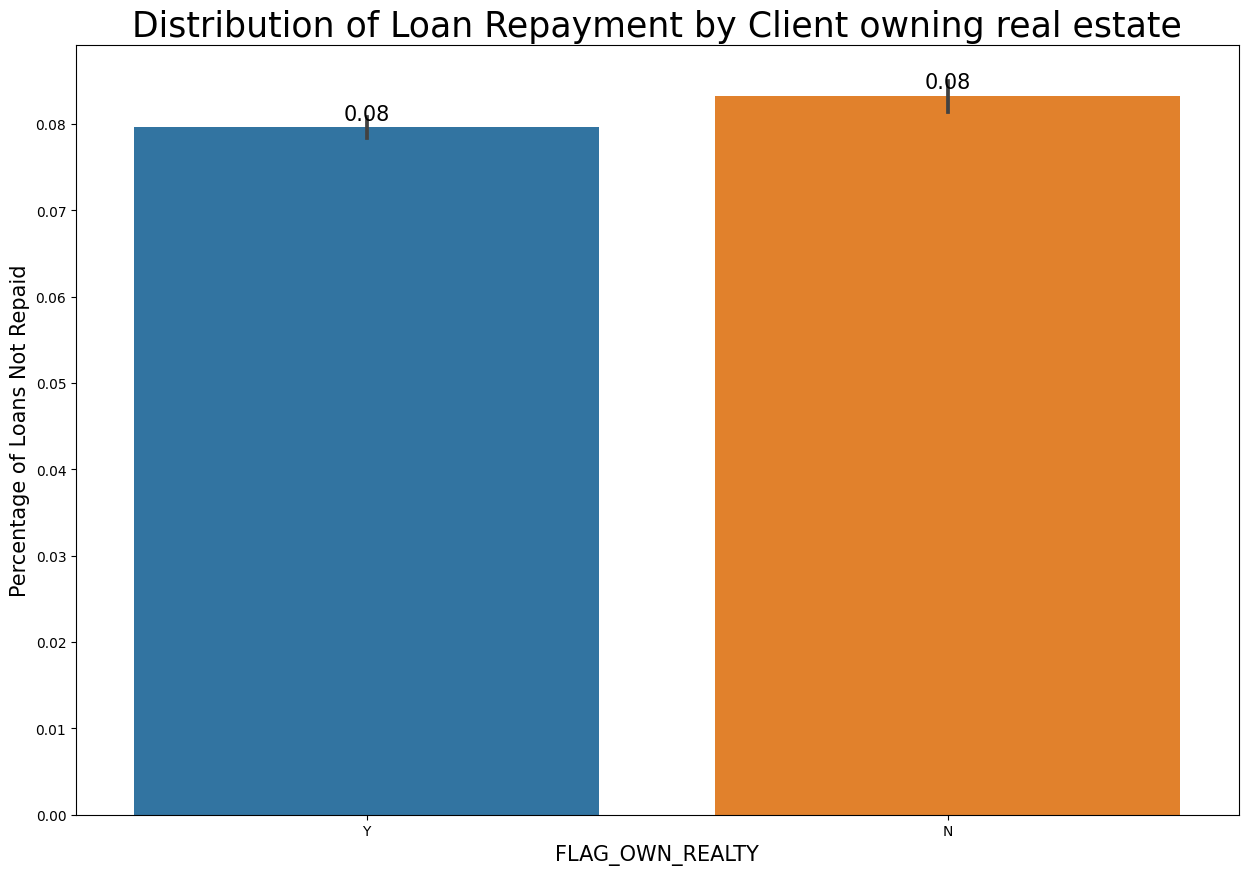

In [8]:
viz_df_train.plot_value_counts(column='FLAG_OWN_REALTY', inPurcent=True, title='Clients owning a real estate distribution', xlabel='FLAG_OWN_REALTY', ylabel='% of client owning a real estate')
viz_df_train.plot_value_counts(column='FLAG_OWN_REALTY', target_column='TARGET', inPurcent=True, title='Distribution of Loan Repayment by Client owning real estate', xlabel='FLAG_OWN_REALTY', ylabel='Percentage of Loans Not Repaid')

Or, another interesting question that appears in our loan data analysis is how many people owning the house will be able to manage the loan?

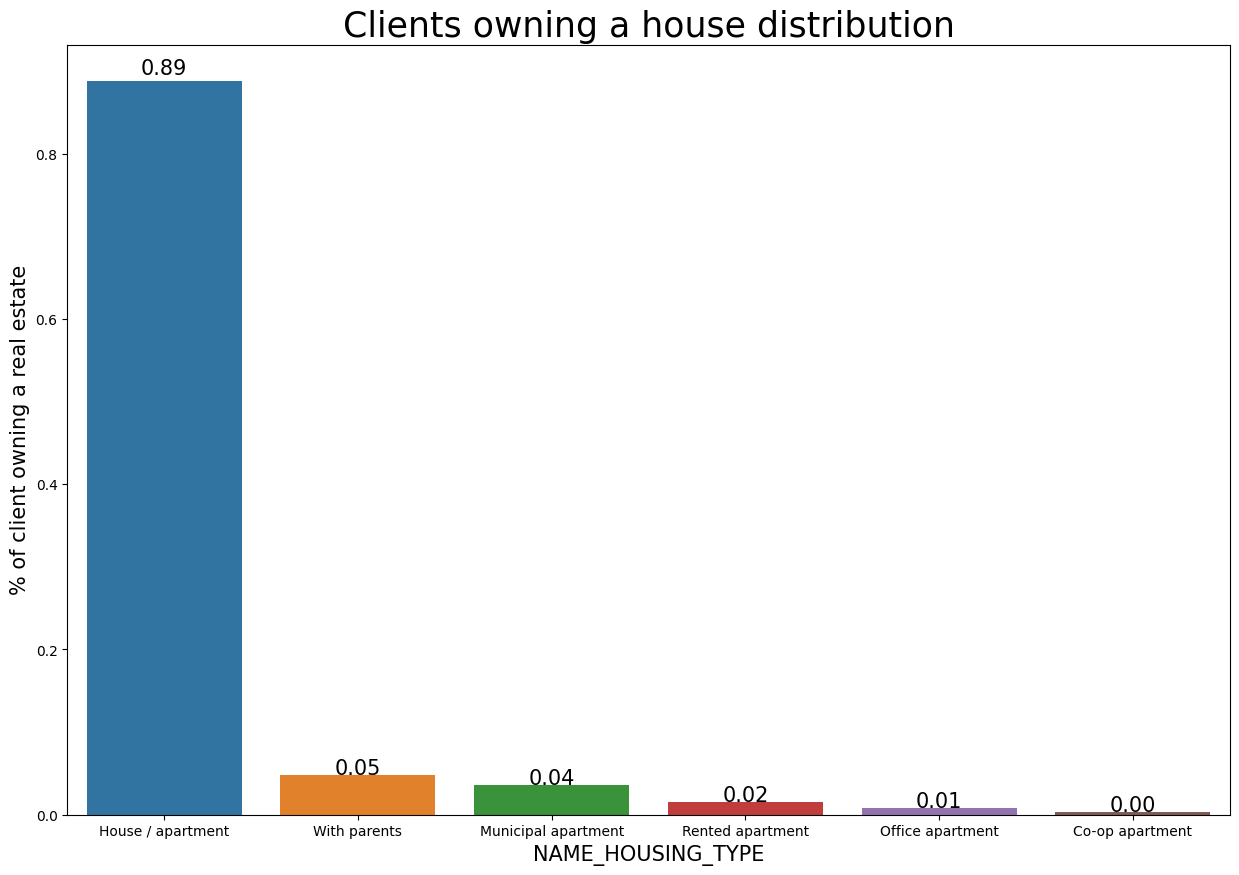

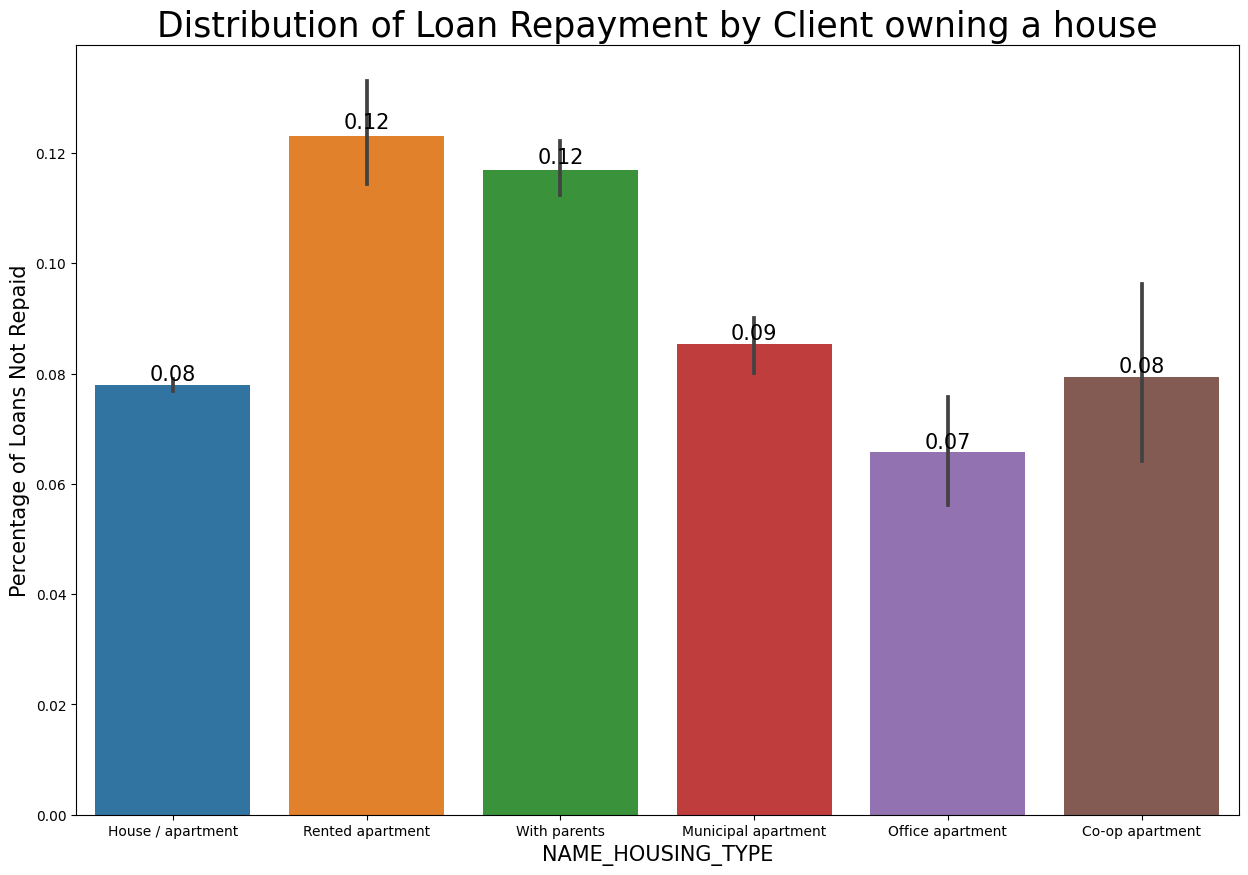

In [9]:
viz_df_train.plot_value_counts(column='NAME_HOUSING_TYPE', inPurcent=True, title='Clients owning a house distribution', xlabel='NAME_HOUSING_TYPE', ylabel='% of client owning a real estate')
viz_df_train.plot_value_counts(column='NAME_HOUSING_TYPE', target_column='TARGET', inPurcent=True, title='Distribution of Loan Repayment by Client owning a house', xlabel='NAME_HOUSING_TYPE', ylabel='Percentage of Loans Not Repaid')

Most of the people who own a house or apartment, 89%, have loans. Approximately 8% of loans to owners of houses and apartments are not repaid. 
Also, we can review the client's family status and the number of children over non-paid loans and contracts.

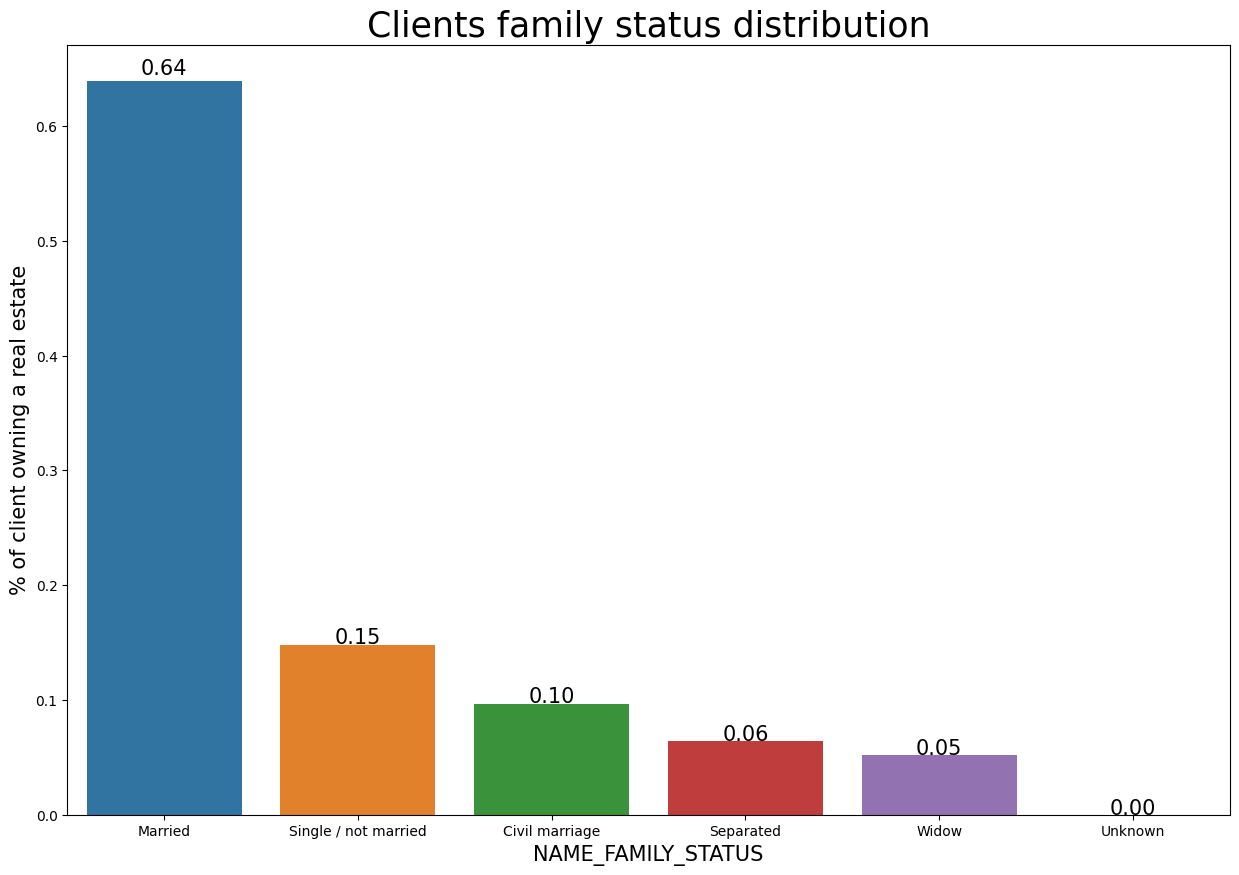

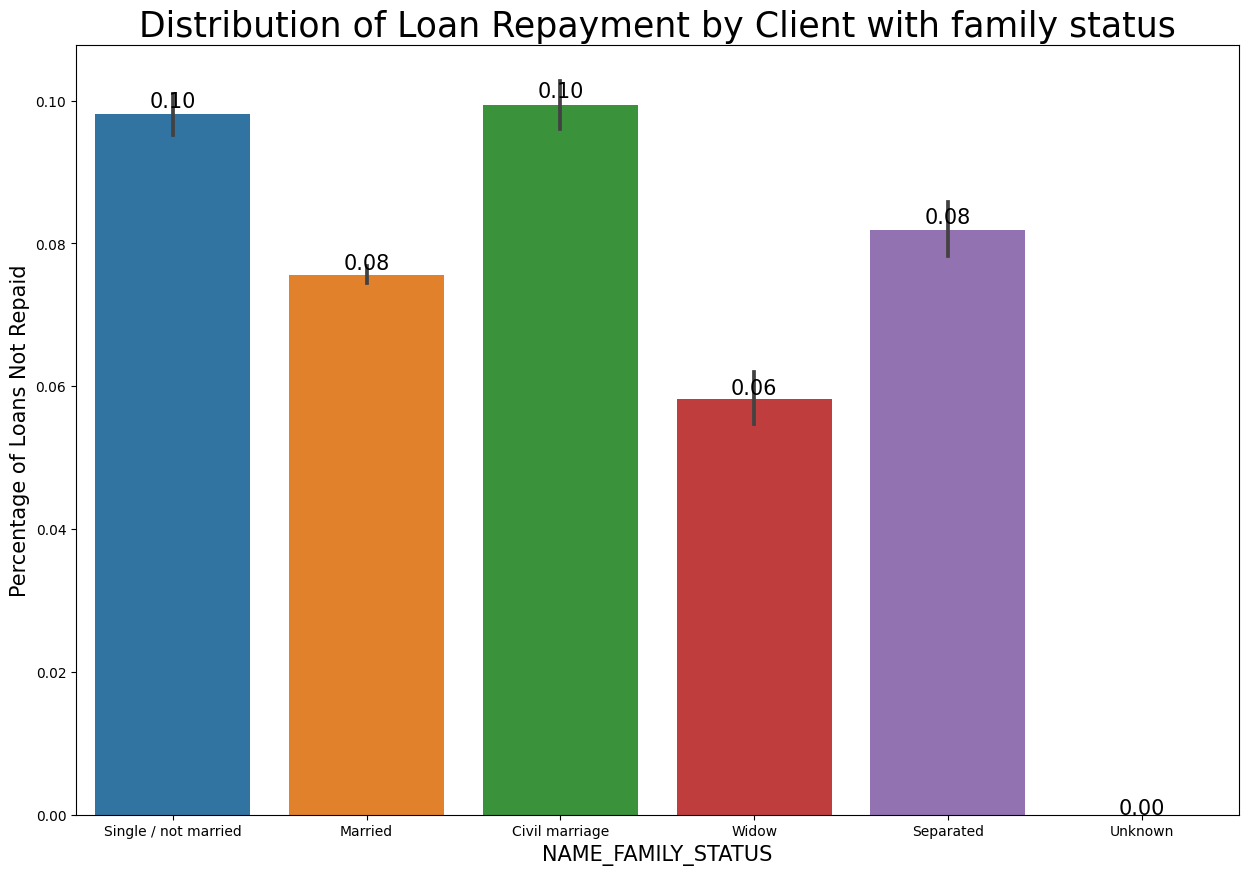

In [10]:
viz_df_train.plot_value_counts(column='NAME_FAMILY_STATUS', inPurcent=True, title='Clients family status distribution', xlabel='NAME_FAMILY_STATUS', ylabel='% of client owning a real estate')
viz_df_train.plot_value_counts(column='NAME_FAMILY_STATUS', target_column='TARGET', inPurcent=True, title='Distribution of Loan Repayment by Client with family status', xlabel='NAME_FAMILY_STATUS', ylabel='Percentage of Loans Not Repaid')

Approximately 64% of contracts are made by clients who are married, followed by individuals who are single and those who are civilly married with about 15% and 10%, respectively. A single or civil marriage contract is more likely to not repay 10% than a marriage contract.

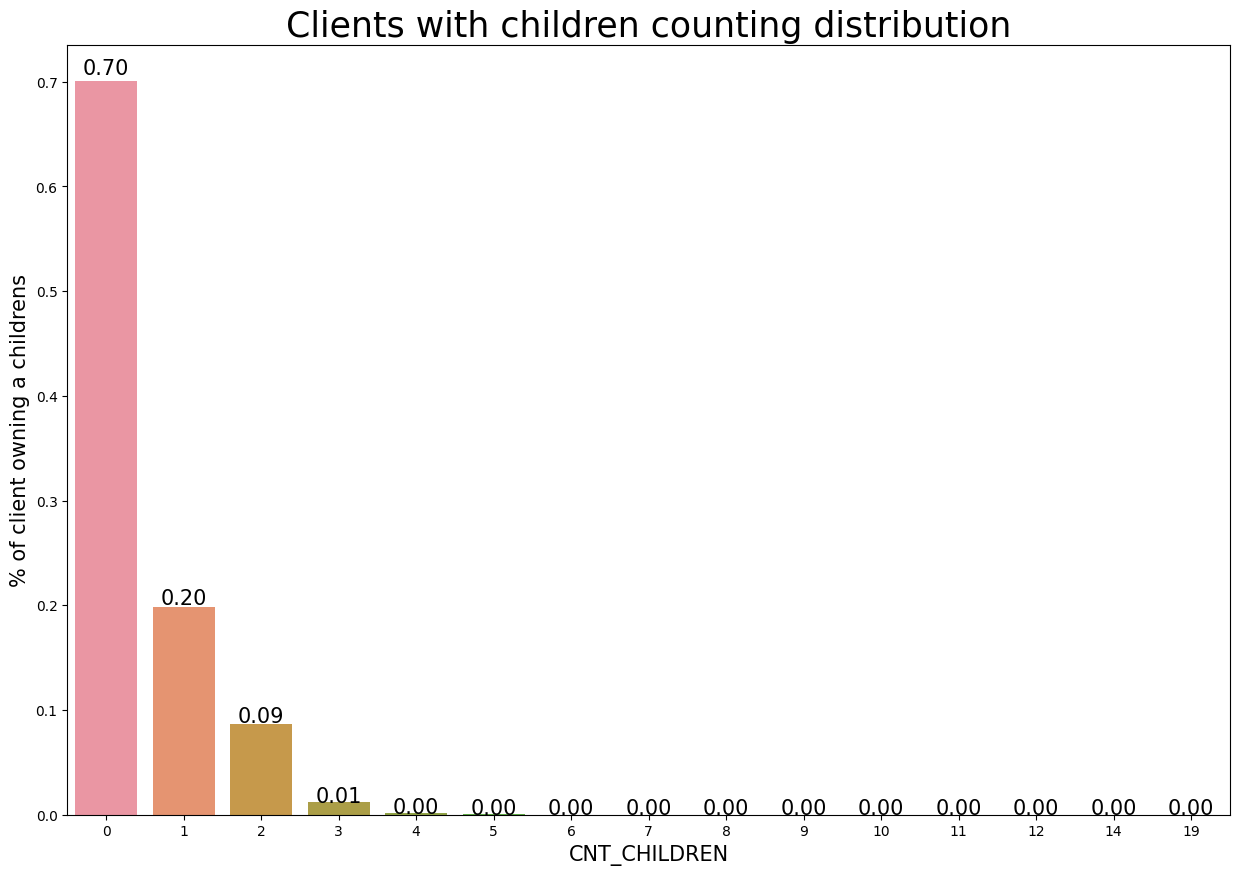

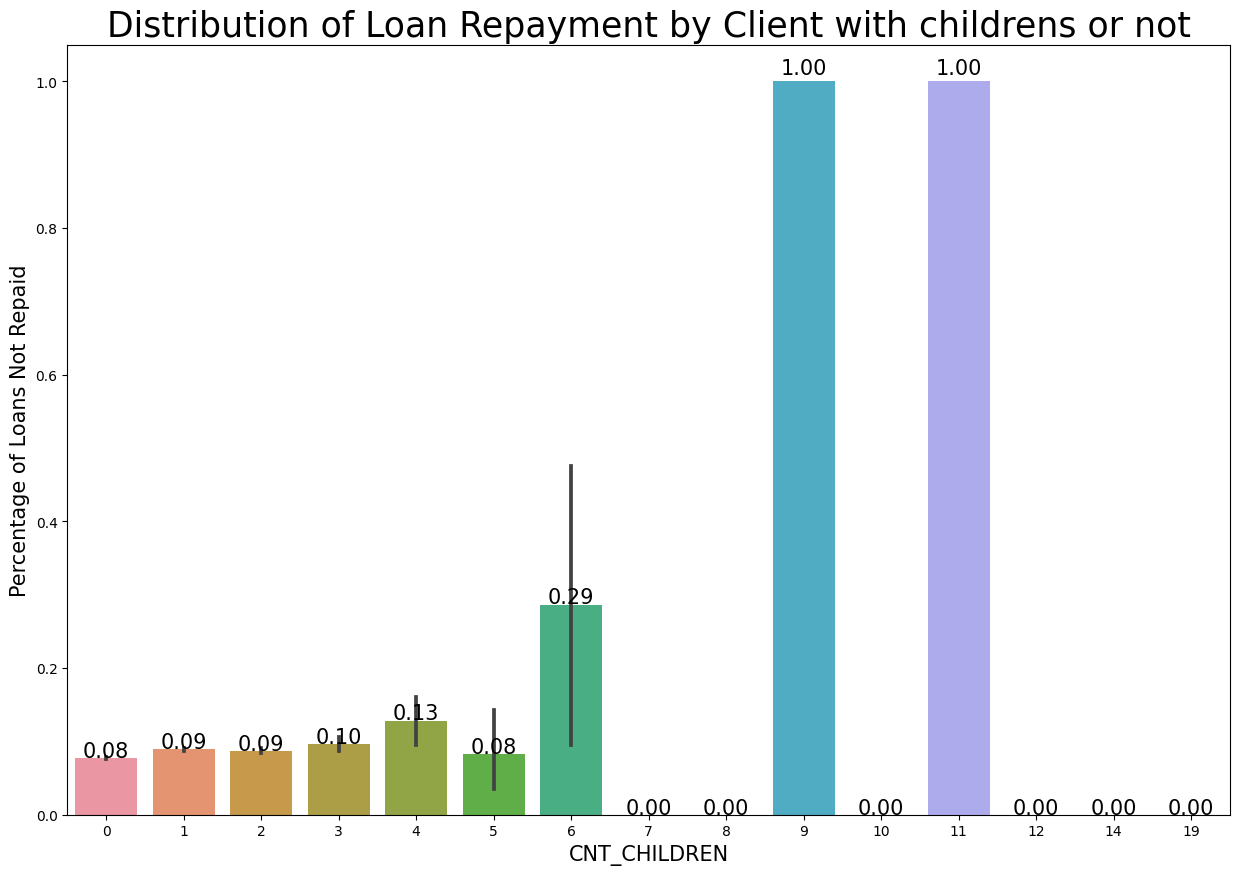

In [11]:
viz_df_train.plot_value_counts(column='CNT_CHILDREN', inPurcent=True, title='Clients with children counting distribution', xlabel='CNT_CHILDREN', ylabel='% of client owning a childrens')
viz_df_train.plot_value_counts(column='CNT_CHILDREN', target_column='TARGET', inPurcent=True, title='Distribution of Loan Repayment by Client with childrens or not', xlabel='CNT_CHILDREN', ylabel='Percentage of Loans Not Repaid')

Most clients with loan contracts have no children. These are 70% of the contracts. It is estimated that 20%, 9%, and 1% of those with 1, 2, and 3 children have 1, 2, and 3 children. One can observe that families with 9 and 11 children have loans not repaid. This is, despite families with 0, 1, 2, 3, and 5 children that have 10% of not repaying loans. Families with 6 children have 28% of loan contracts not fully paid off.

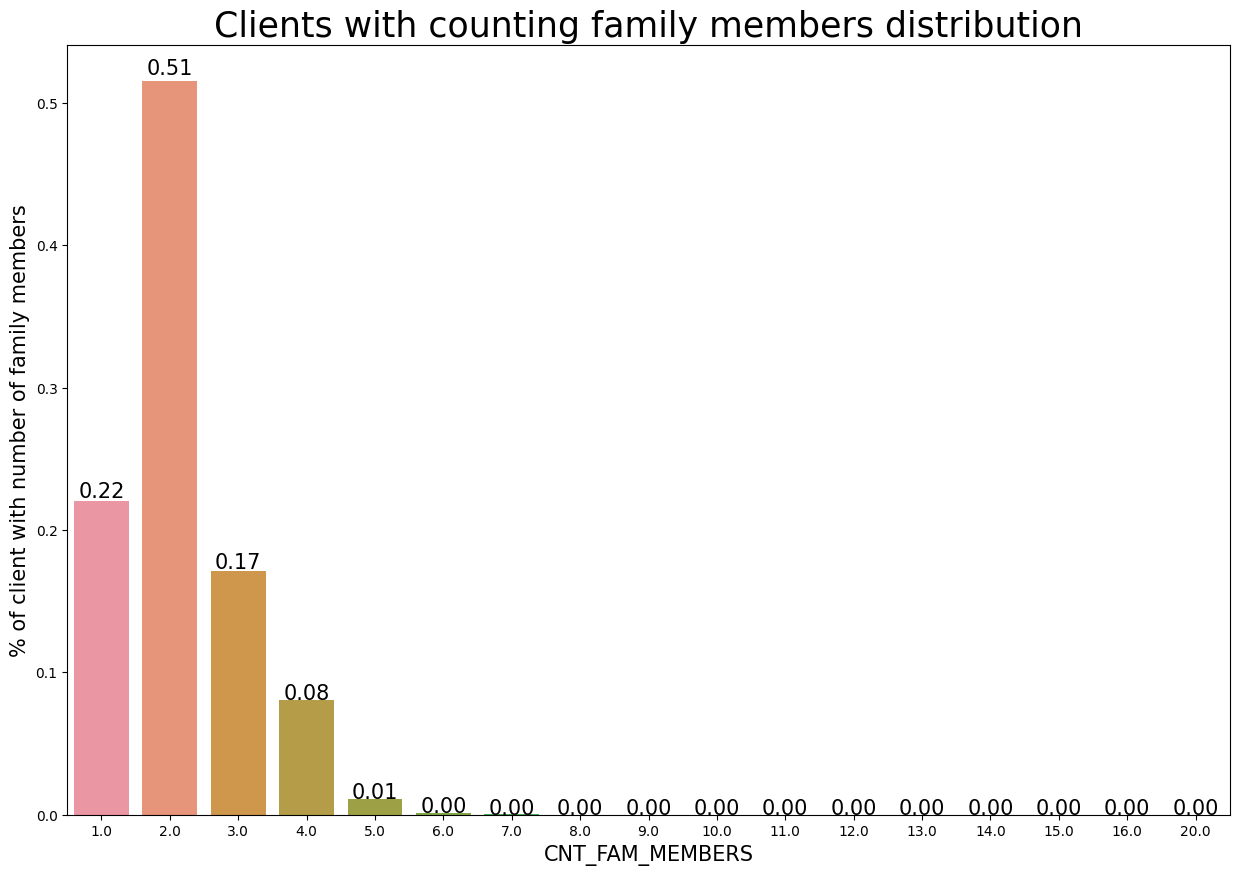

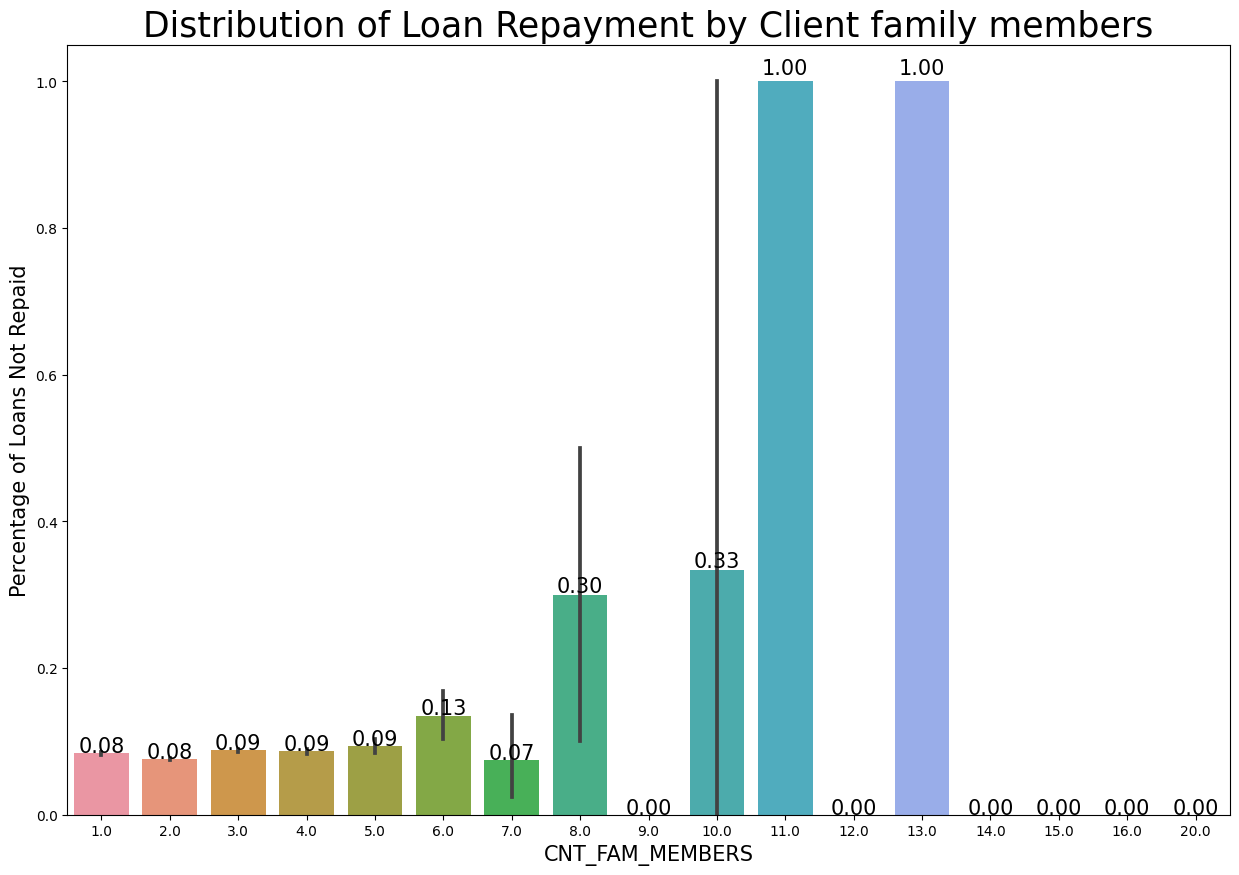

In [12]:
viz_df_train.plot_value_counts(column='CNT_FAM_MEMBERS', inPurcent=True, title='Clients with counting family members distribution', xlabel='CNT_FAM_MEMBERS', ylabel='% of client with number of family members')
viz_df_train.plot_value_counts(column='CNT_FAM_MEMBERS', target_column='TARGET', inPurcent=True, title='Distribution of Loan Repayment by Client family members', xlabel='CNT_FAM_MEMBERS', ylabel='Percentage of Loans Not Repaid')

We see consistency in the number of children in the family. Those that are with 11 and 13 members in the family have 100% loans not repaid.

## Examine anomalies, cleaning datasets and Features Engineering
 - Remove the outliers and the anomalies values. We will set the bad values to NaN, in order to fill them all with an Imputer class.
 - Remove non existant gender
 - Remove columns with more then 60% of nans
 - Categorize values in the Organization_type
 - Adding polynomial and domain knoladge features
 - Merging and Joining dataframes
 - Encodding categorical variables

### Application dataset

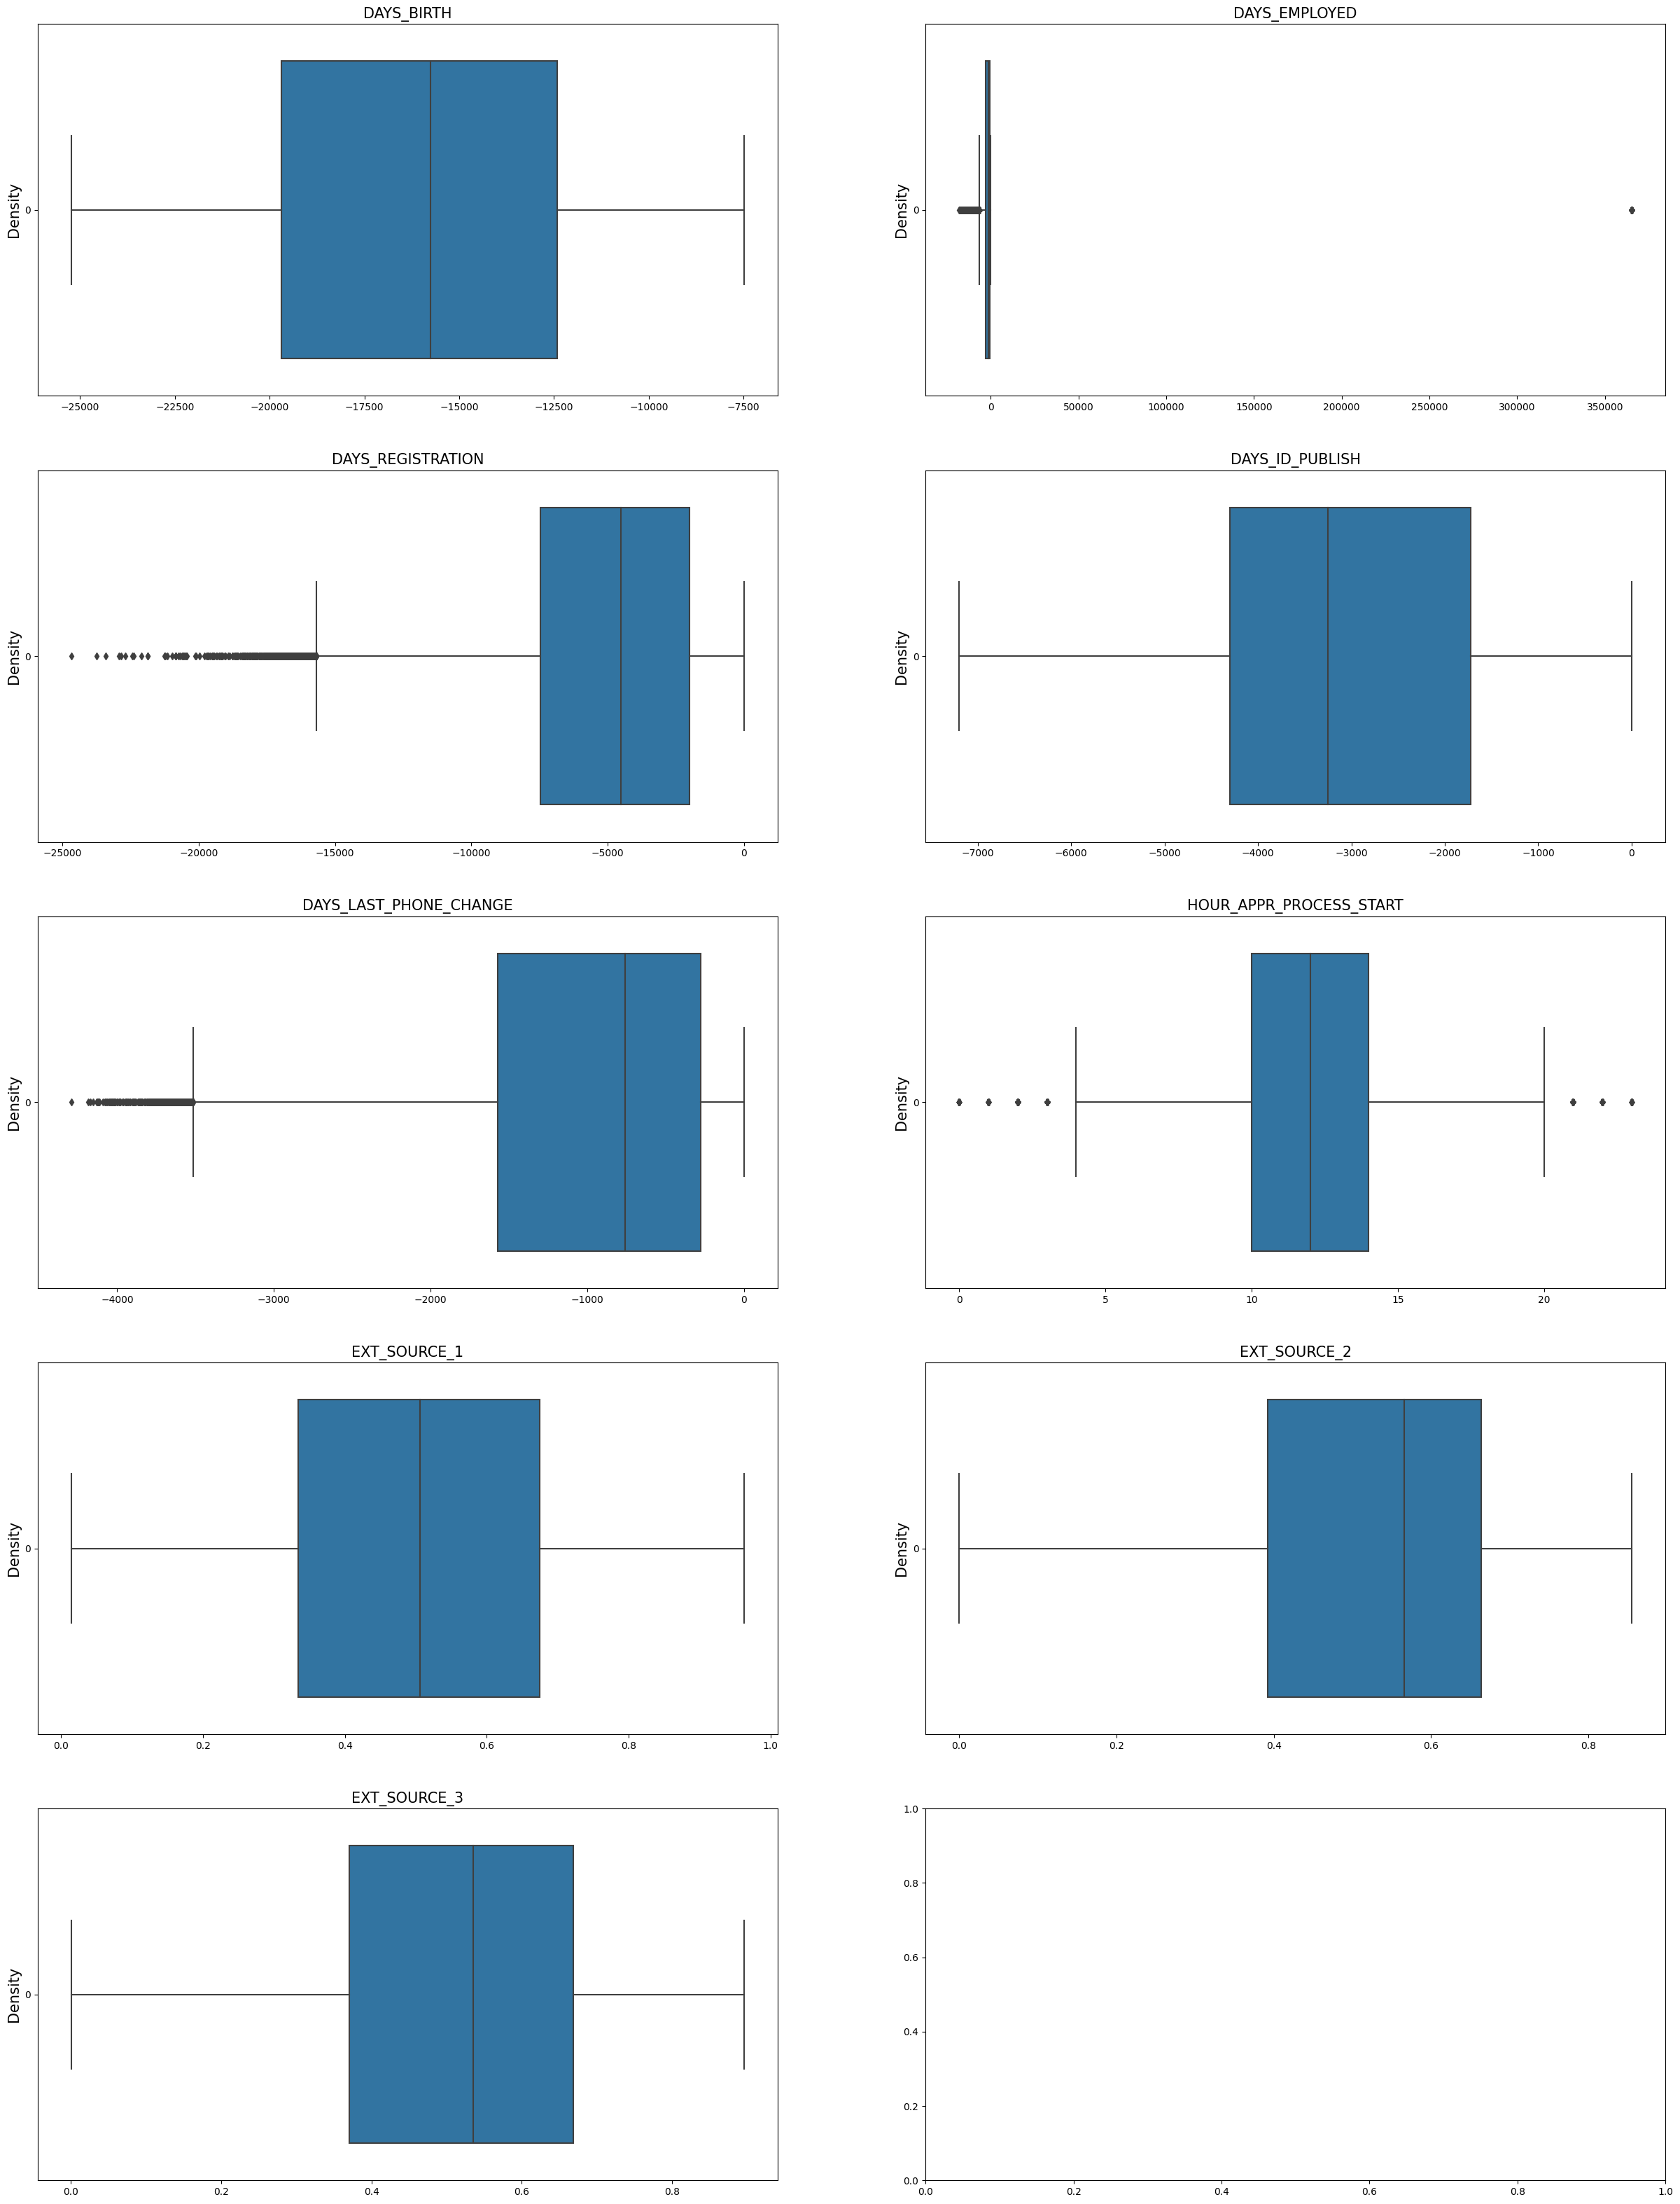

In [9]:
cols = ['DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE',
       'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3']

viz_df_train.plot_density(columns = cols, dt = DensityTypes.Boxplot)

The numbers in the `DAYS_BIRTH` column are negative because they are recorded relative to the current loan application.  We can see an outlier in the`DAYS_EMPLOYED`, the value being approximative 100years. We see a normal distribution hear for `EXT_SOURCE_1`, `EXT_SOURCE_2`, `EXT_SOURCE_3`. Theese values seeams to be ok.

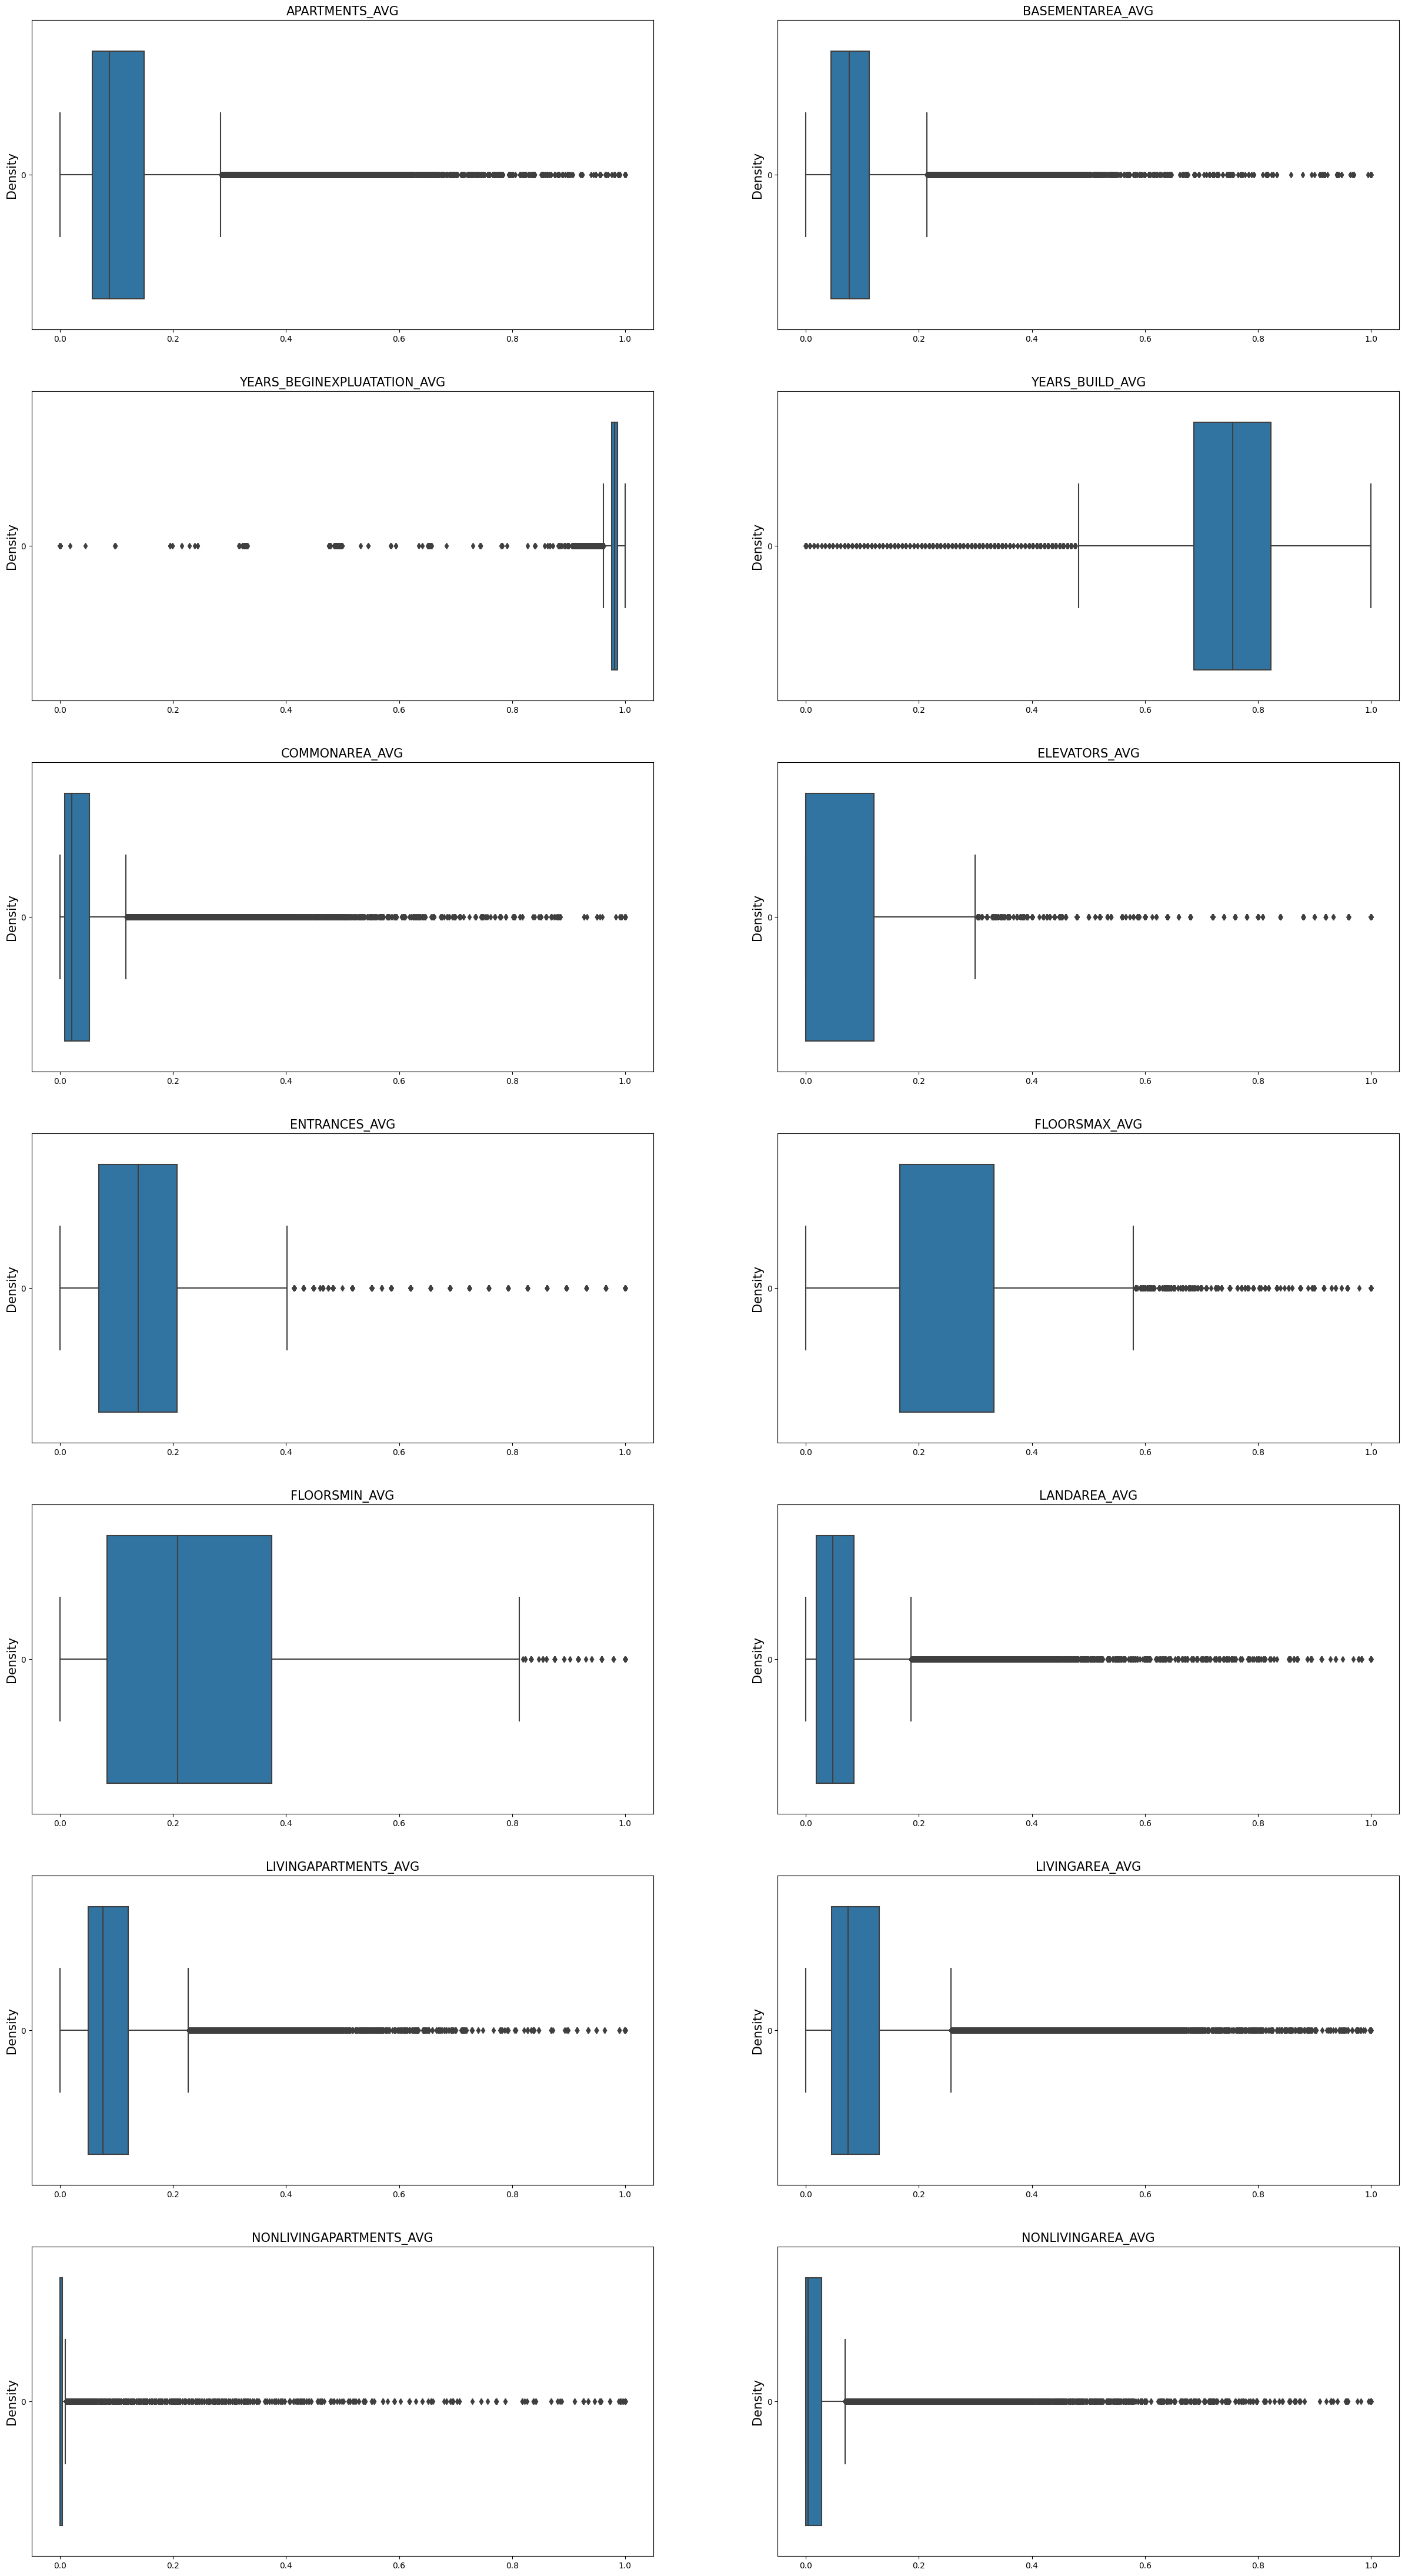

In [10]:
cols = ['APARTMENTS_AVG', 'BASEMENTAREA_AVG',
       'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG',
       'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG',
       'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
       'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG']
viz_df_train.plot_density(columns = cols, dt = DensityTypes.Boxplot)

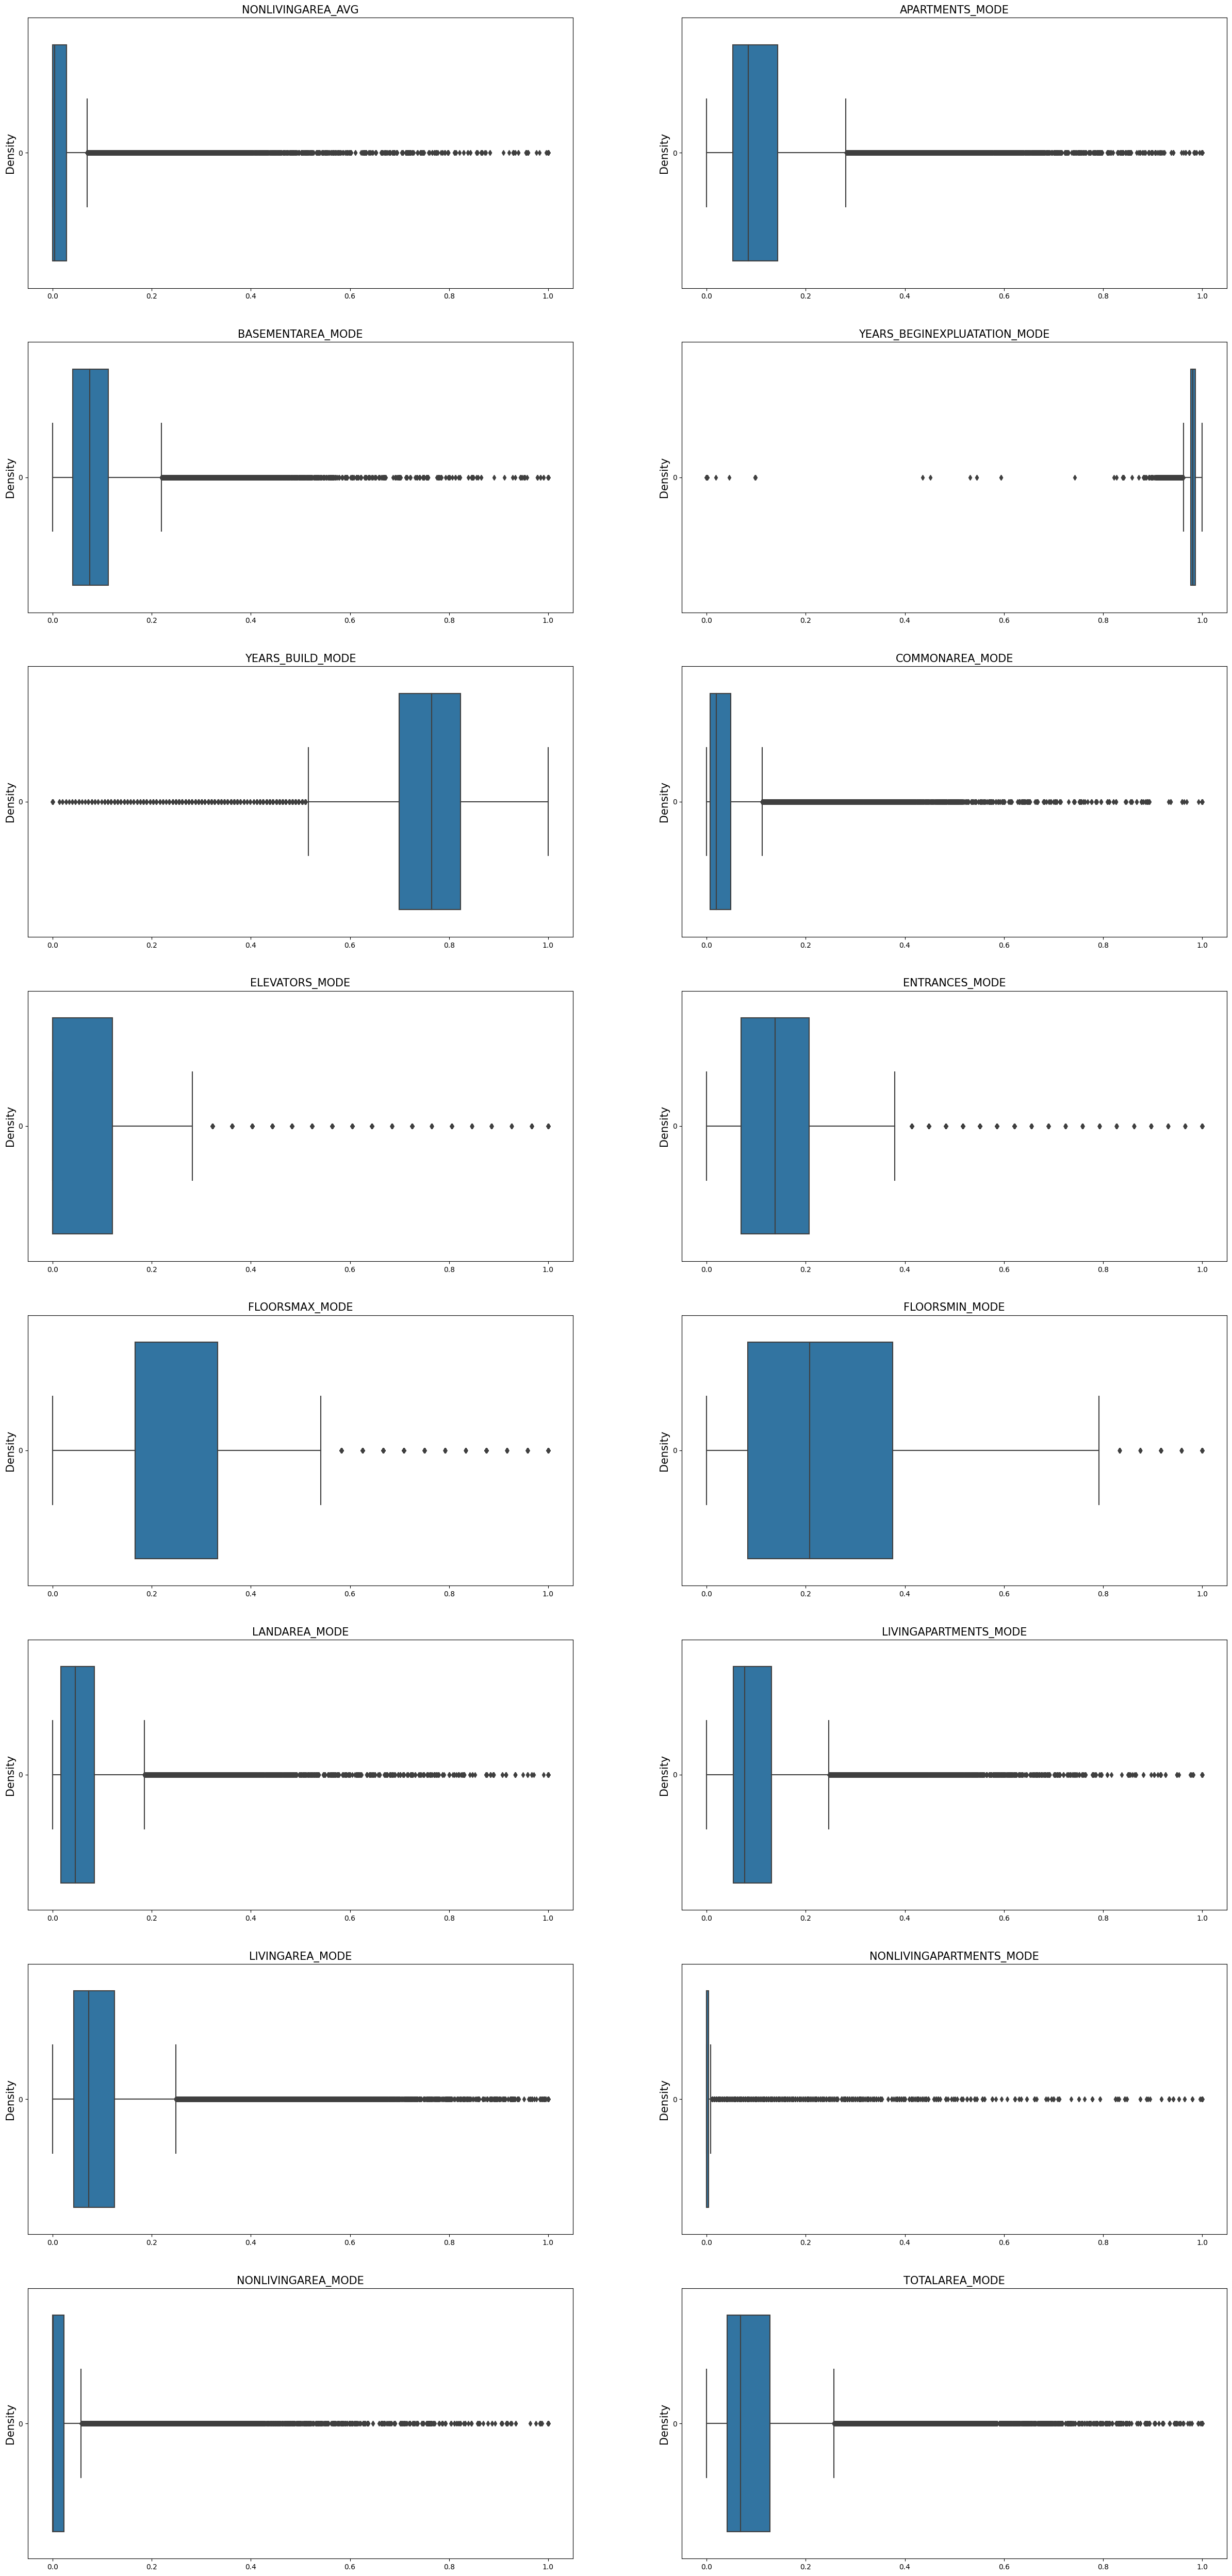

In [11]:
cols = ['NONLIVINGAREA_AVG', 'APARTMENTS_MODE',
       'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
       'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE',
       'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'TOTALAREA_MODE']
viz_df_train.plot_density(columns = cols, dt = DensityTypes.Boxplot)

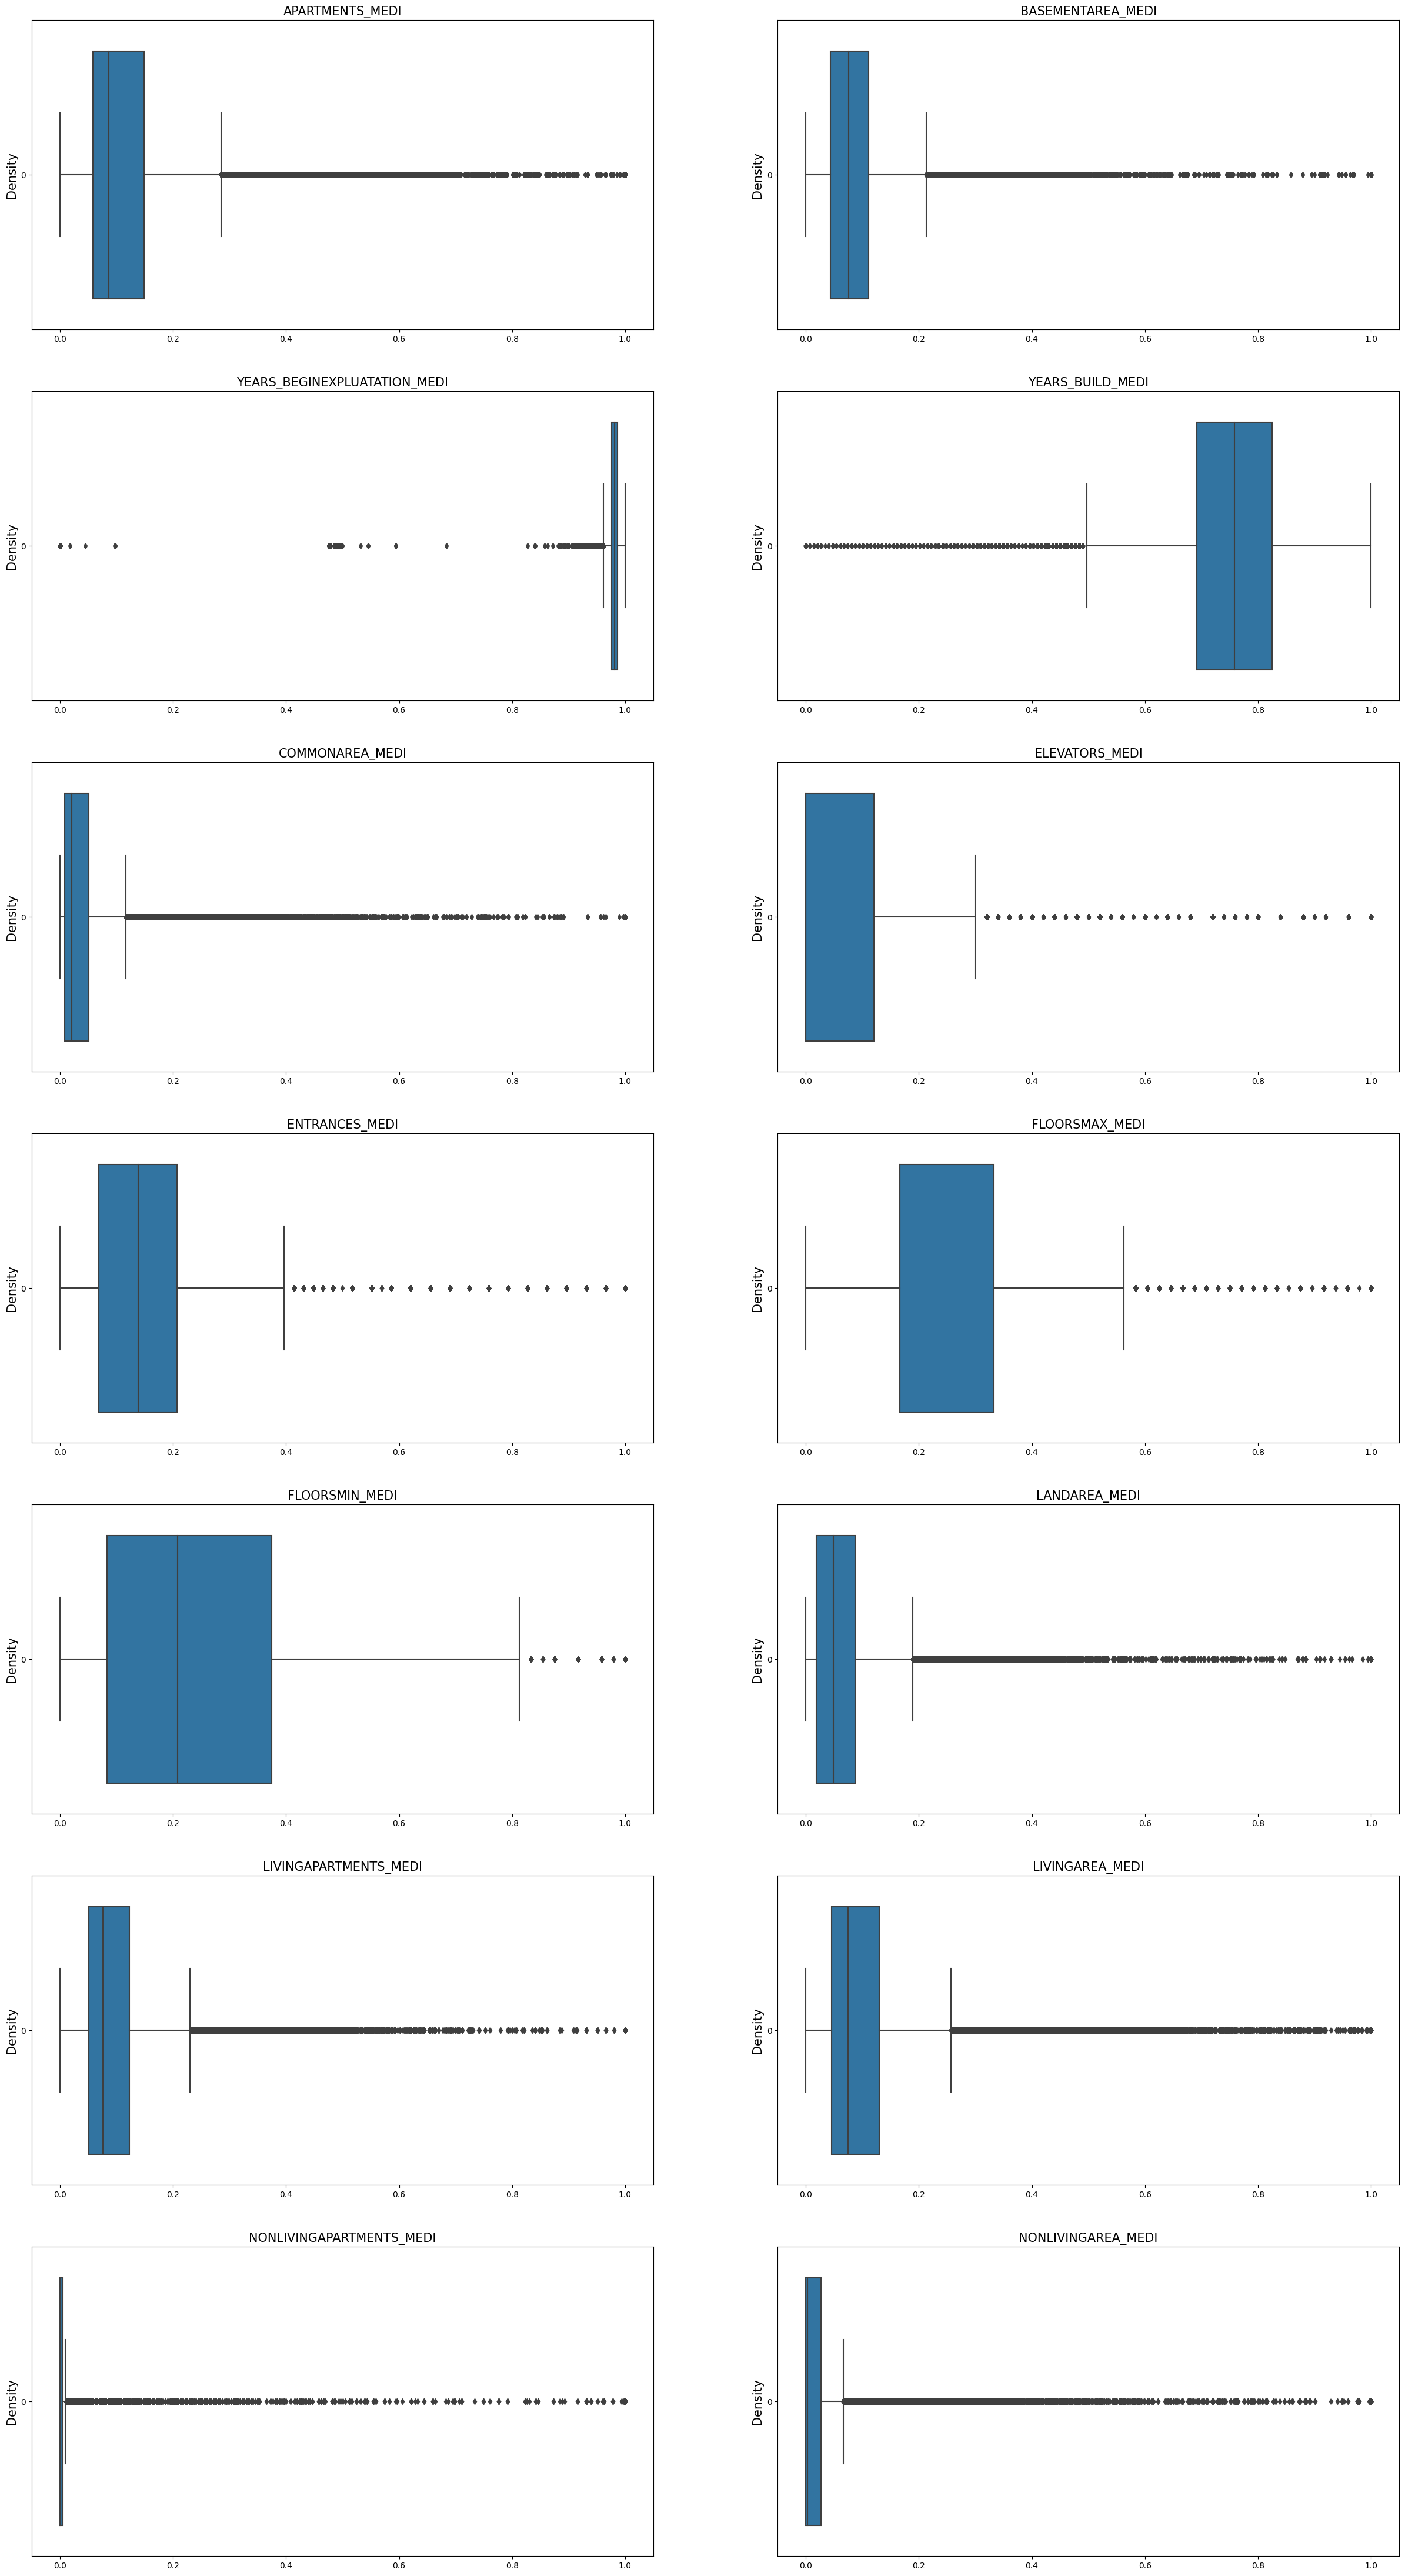

In [12]:
cols = ['APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
       'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
       'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI',
       'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI',
       'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI',
       'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI']
viz_df_train.plot_density(columns = cols, dt = DensityTypes.Boxplot)

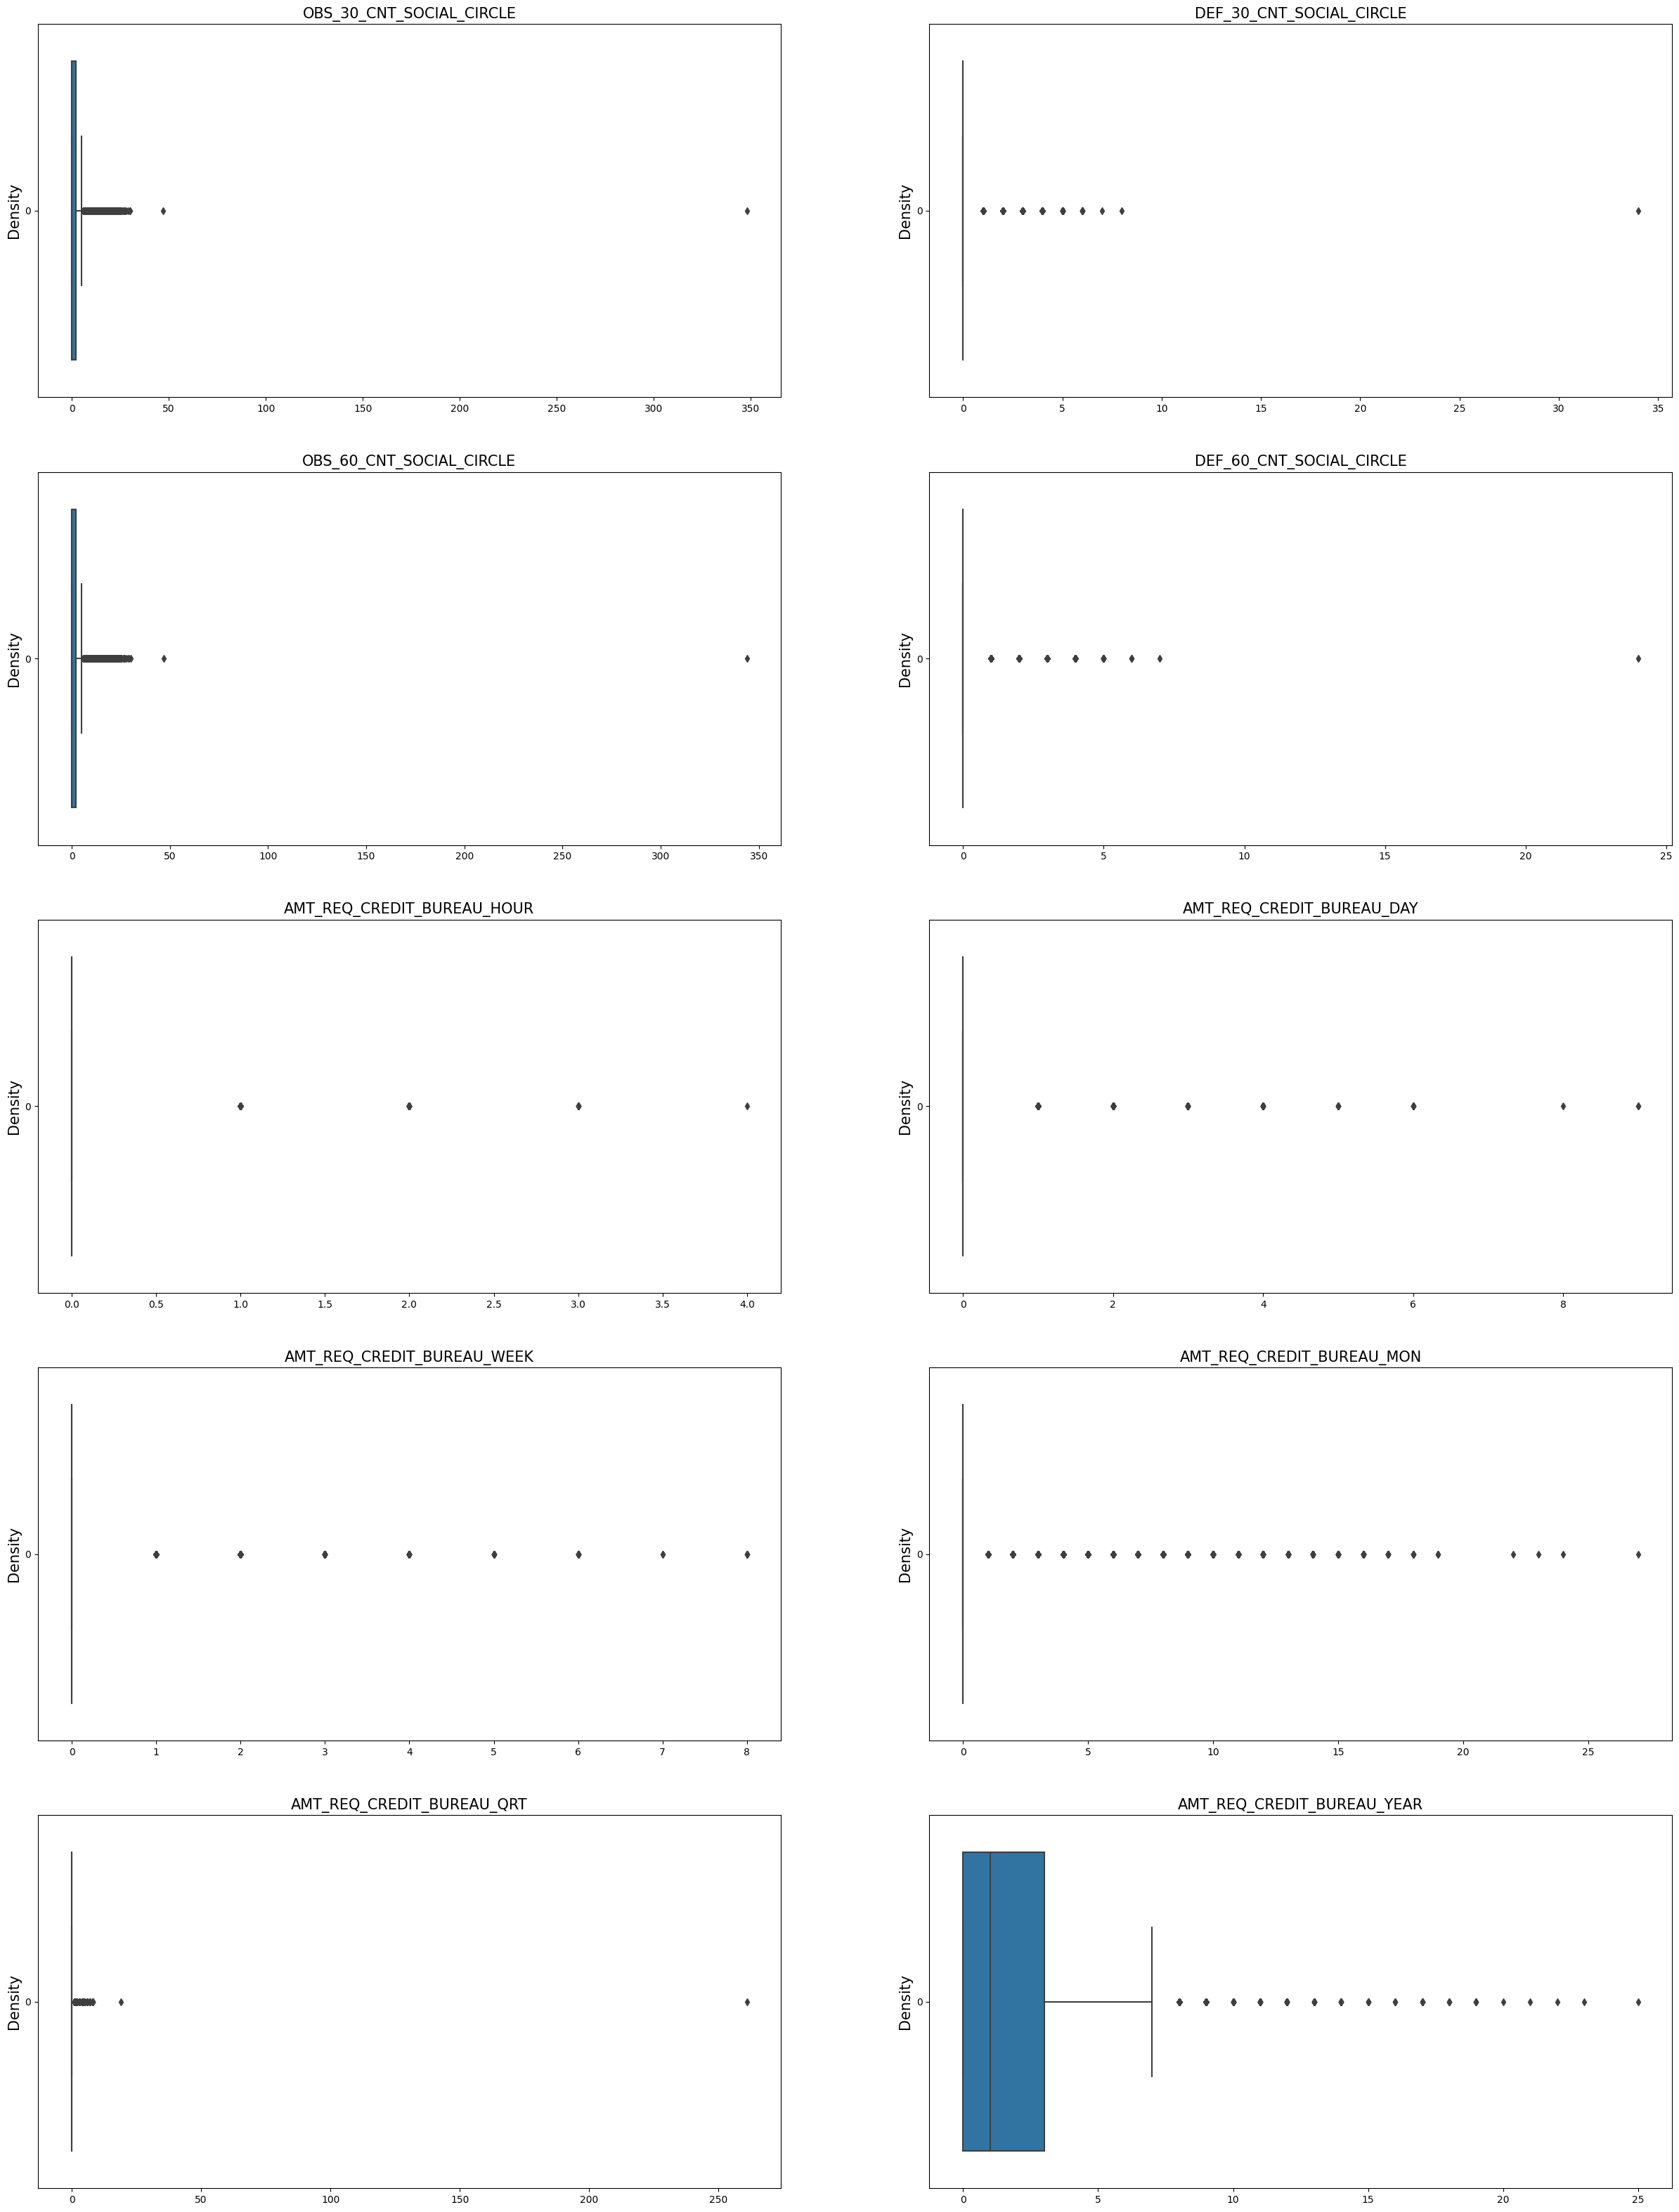

In [13]:
cols = ['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']
viz_df_train.plot_density(columns = cols, dt = DensityTypes.Boxplot)

In previous boxplots, I did not observe values that were not in the acceptable range. The one with a 350 social circle observation count seems to me somewhat strange, but I propose keeping it as it is.

Next, the bureau dataset is analyzed, joining it with the application dataset.

### Bureau dataset

Bureau data consists of client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.

In [18]:
df_bureau.data.describe()

SK_ID_CURR  SK_ID_BUREAU   DAYS_CREDIT  CREDIT_DAY_OVERDUE  \
count  1.716428e+06  1.716428e+06  1.716428e+06        1.716428e+06   
mean   2.782149e+05  5.924434e+06 -1.142108e+03        8.181666e-01   
std    1.029386e+05  5.322657e+05  7.951649e+02        3.654443e+01   
min    1.000010e+05  5.000000e+06 -2.922000e+03        0.000000e+00   
25%    1.888668e+05  5.463954e+06 -1.666000e+03        0.000000e+00   
50%    2.780550e+05  5.926304e+06 -9.870000e+02        0.000000e+00   
75%    3.674260e+05  6.385681e+06 -4.740000e+02        0.000000e+00   
max    4.562550e+05  6.843457e+06  0.000000e+00        2.792000e+03   

       DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  \
count         1.610875e+06       1.082775e+06            5.919400e+05   
mean          5.105174e+02      -1.017437e+03            3.825418e+03   
std           4.994220e+03       7.140106e+02            2.060316e+05   
min          -4.206000e+04      -4.202300e+04            0.000000e+00   
25%          -1.138000e+03      -1.489000e+03            0.000000e+00   
50%          -3.300000e+02      -8.970000e+02            0.000000e+00   
75%           4.740000e+02      -4.250000e+02            0.000000e+00   
max           3.119900e+04       0.000000e+00            1.159872e+08   

       CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  \
count        1.716428e+06    1.716415e+06         1.458759e+06   
mean         6.410406e-03    3.549946e+05         1.370851e+05   
std          9.622391e-02    1.149811e+06         6.774011e+05   
min          0.000000e+00    0.000000e+00        -4.705600e+06   
25%          0.000000e+00    5.130000e+04         0.000000e+00   
50%          0.000000e+00    1.255185e+05         0.000000e+00   
75%          0.000000e+00    3.150000e+05         4.015350e+04   
max          9.000000e+00    5.850000e+08         1.701000e+08   

       AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  DAYS_CREDIT_UPDATE  \
count          1.124648e+06            1.716428e+06        1.716428e+06   
mean           6.229515e+03            3.791276e+01       -5.937483e+02   
std            4.503203e+04            5.937650e+03        7.207473e+02   
min           -5.864061e+05            0.000000e+00       -4.194700e+04   
25%            0.000000e+00            0.000000e+00       -9.080000e+02   
50%            0.000000e+00            0.000000e+00       -3.950000e+02   
75%            0.000000e+00            0.000000e+00       -3.300000e+01   
max            4.705600e+06            3.756681e+06        3.720000e+02   

        AMT_ANNUITY  
count  4.896370e+05  
mean   1.571276e+04  
std    3.258269e+05  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    1.350000e+04  
max    1.184534e+08

In [19]:
df_bureau.data.describe(include=[object])

CREDIT_ACTIVE CREDIT_CURRENCY      CREDIT_TYPE
count        1716428         1716428          1716428
unique             4               4               15
top           Closed      currency 1  Consumer credit
freq         1079273         1715020          1251615

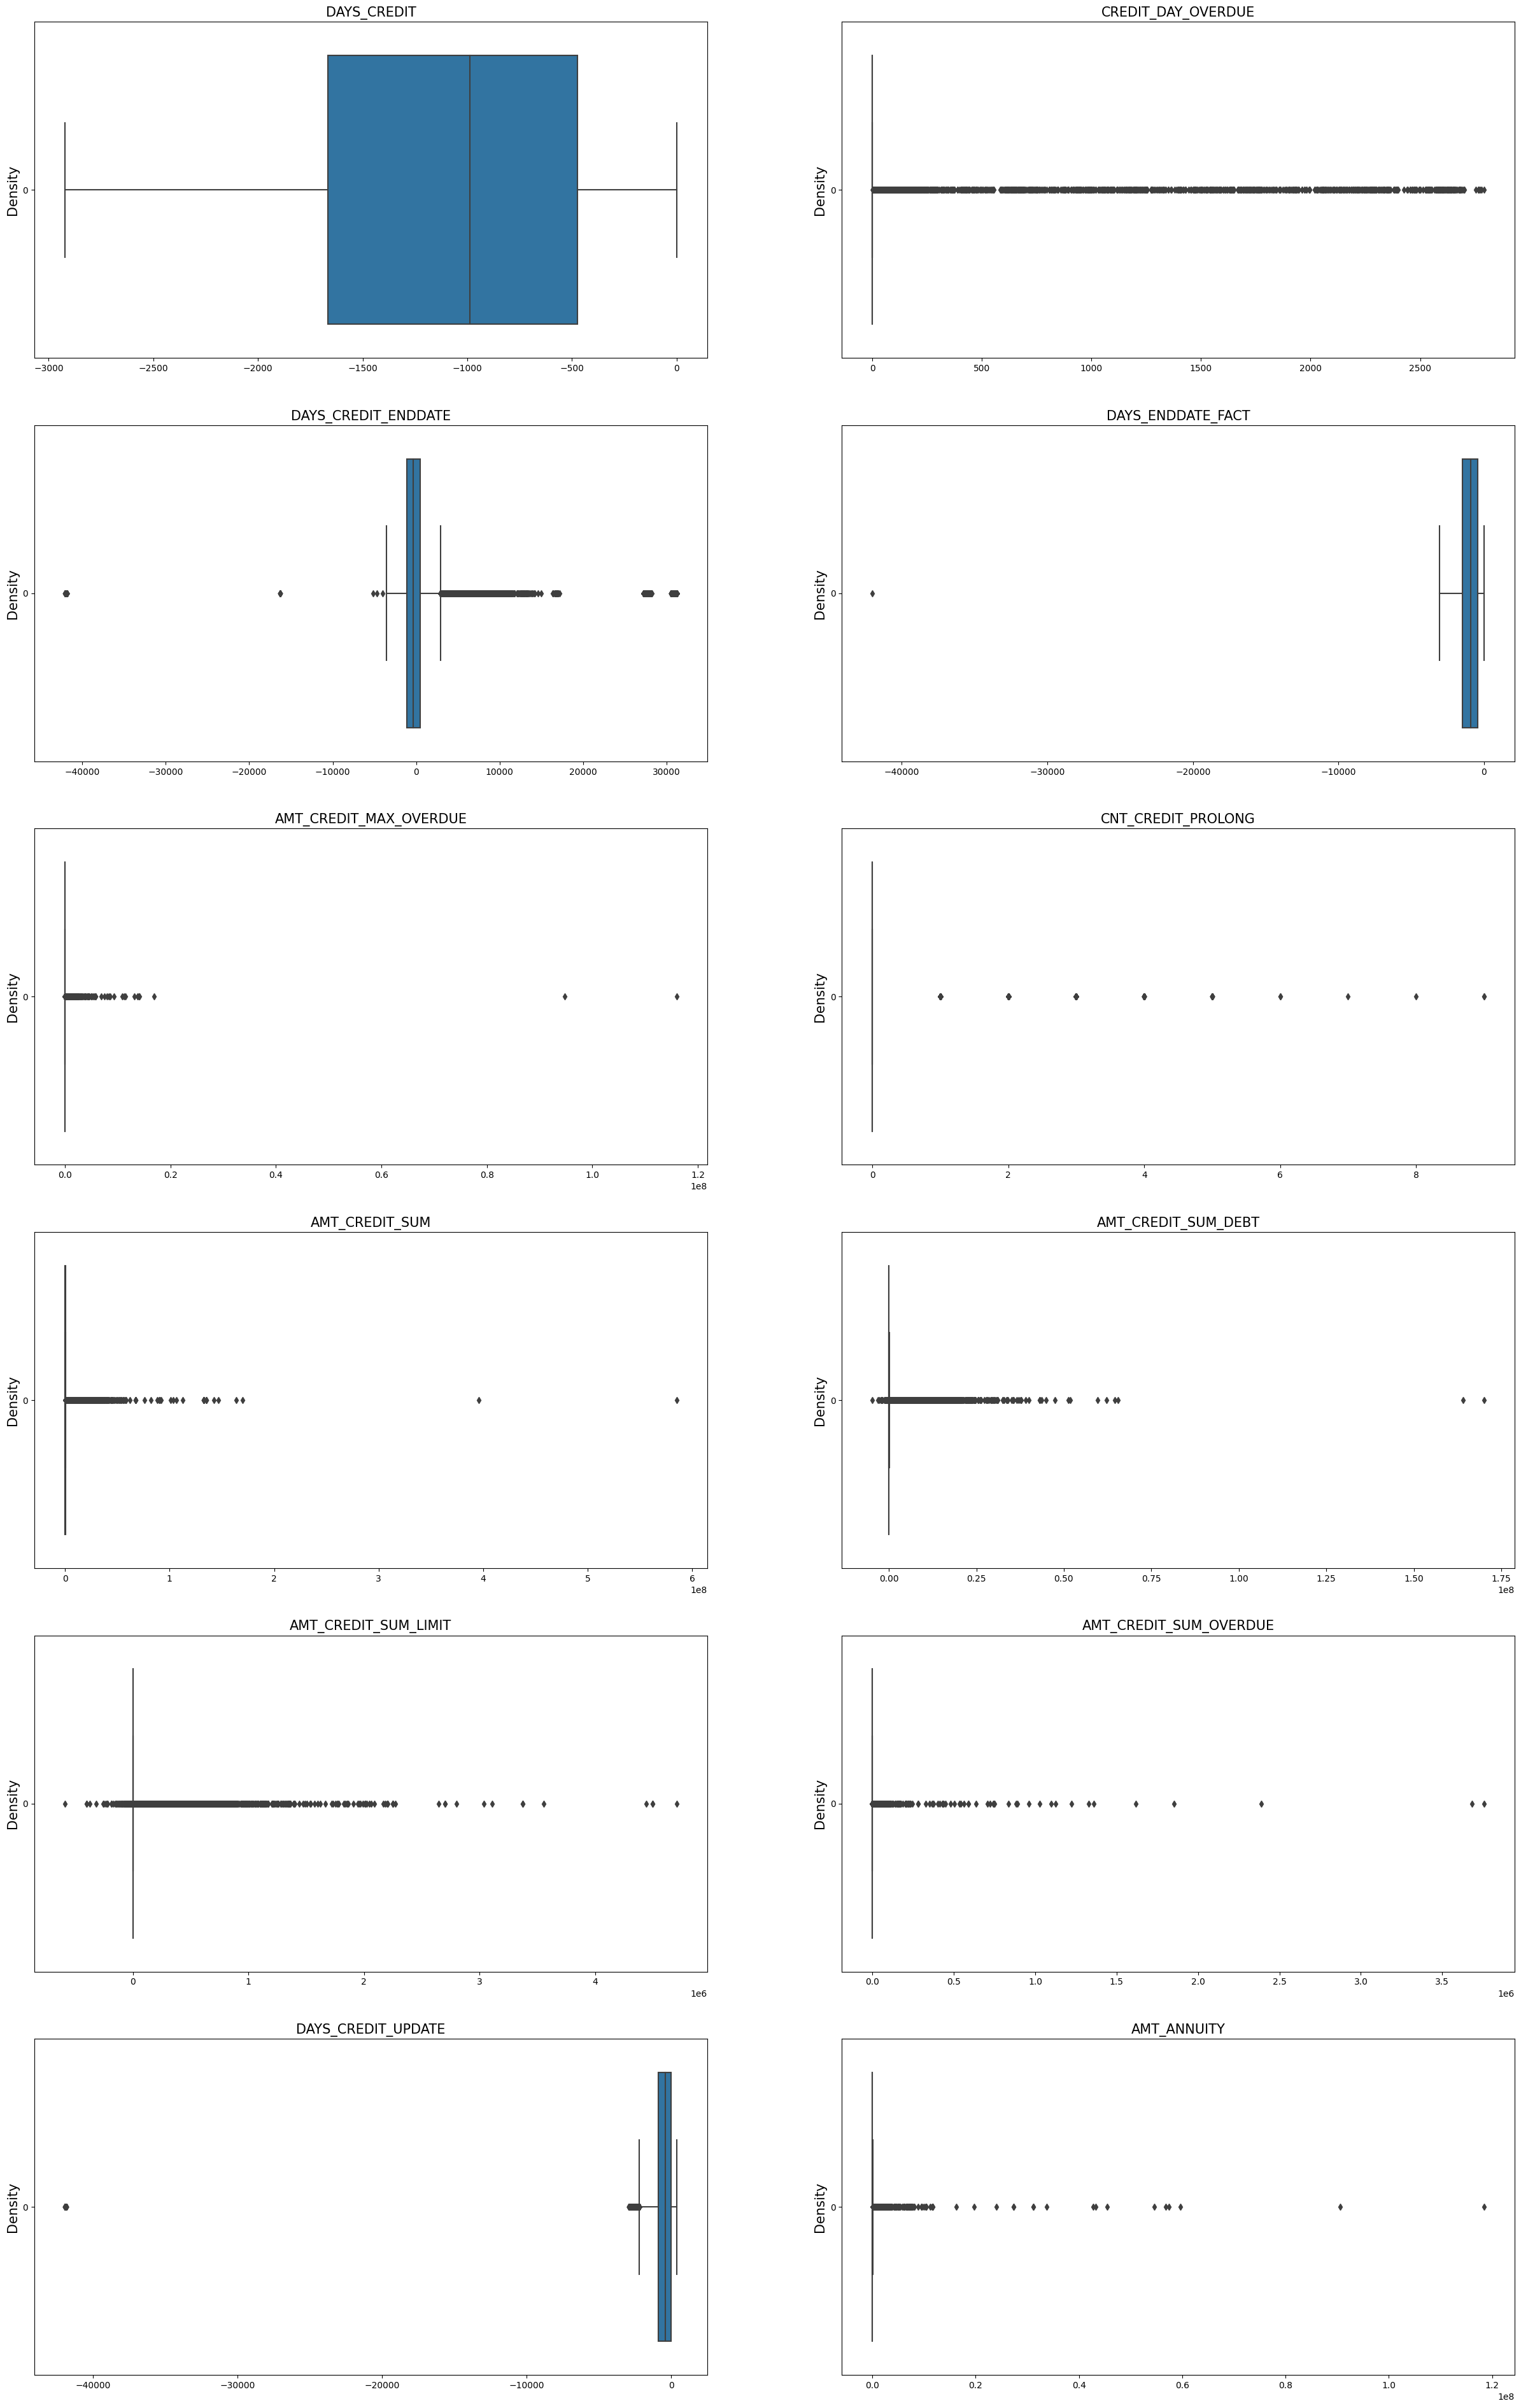

In [21]:
cols = ['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY']
viz_df_bureau.plot_density(columns = cols, dt = DensityTypes.Boxplot)

`DAYS_CREDIT_ENDDAT` is a little bit strange having a minimum value of -118 days, that is more then 100 years. I will uppose that this kind of credit is possible. We also have positive values. I am not sure what theese values means, but I think it is the payed loans. I see some positive and negative values in  `AMT_CREDIT_SUM_DEB`. I am not a specialist in the bank domain, but I suppose that the positive values are the debt of the client and the negative values are the bank debt.The same think is for the `AMT_CREDIT_SUM_LIMI`. So I think theese values can be good. A discussion with a specialist could help to understand better the speciality.

Speaking about the outliers values, that I find a little bit strange. First note that in the `DAYS_CREDIT_UPDAT` we have just one positive value that is equal to 372 (the positive information can tell here about the future that is not logic in this situation). For know I am not sure what that means but I will suppose it as an outlier for future analysis. Also `DAYS_CREDIT_UPDAT` has a minimal value of -41947 that is also taken as an outlier in my analyse (more then 100 years before loan application did last information about the Credit Bureau credit come seems to be irelevant). Finally the `DAYS_ENDDATE_FAC` with the minimum value equal to -42023 seems to be also irelavat.

### Bureau balance

In [35]:
df_bureau_balance.data.describe()

SK_ID_BUREAU  MONTHS_BALANCE
count  2.729992e+07    2.729992e+07
mean   6.036297e+06   -3.074169e+01
std    4.923489e+05    2.386451e+01
min    5.001709e+06   -9.600000e+01
25%    5.730933e+06   -4.600000e+01
50%    6.070821e+06   -2.500000e+01
75%    6.431951e+06   -1.100000e+01
max    6.842888e+06    0.000000e+00

In [36]:
df_bureau_balance.data.describe(include=[object])

STATUS
count   27299925
unique         8
top            C
freq    13646993

Let us pose a question of the status that do we have in Credit Bureau during the mounth and how much of them are there.
Here are some examples of the status of the credit bureau:
 - C means closed
 - X means status unknown
 - 0 means no DPD
 - 1 means maximal did during month between 1-30
 - 2 means DPD 31-60,
 - … 
 - 5 means DPD 120+ or sold or written off

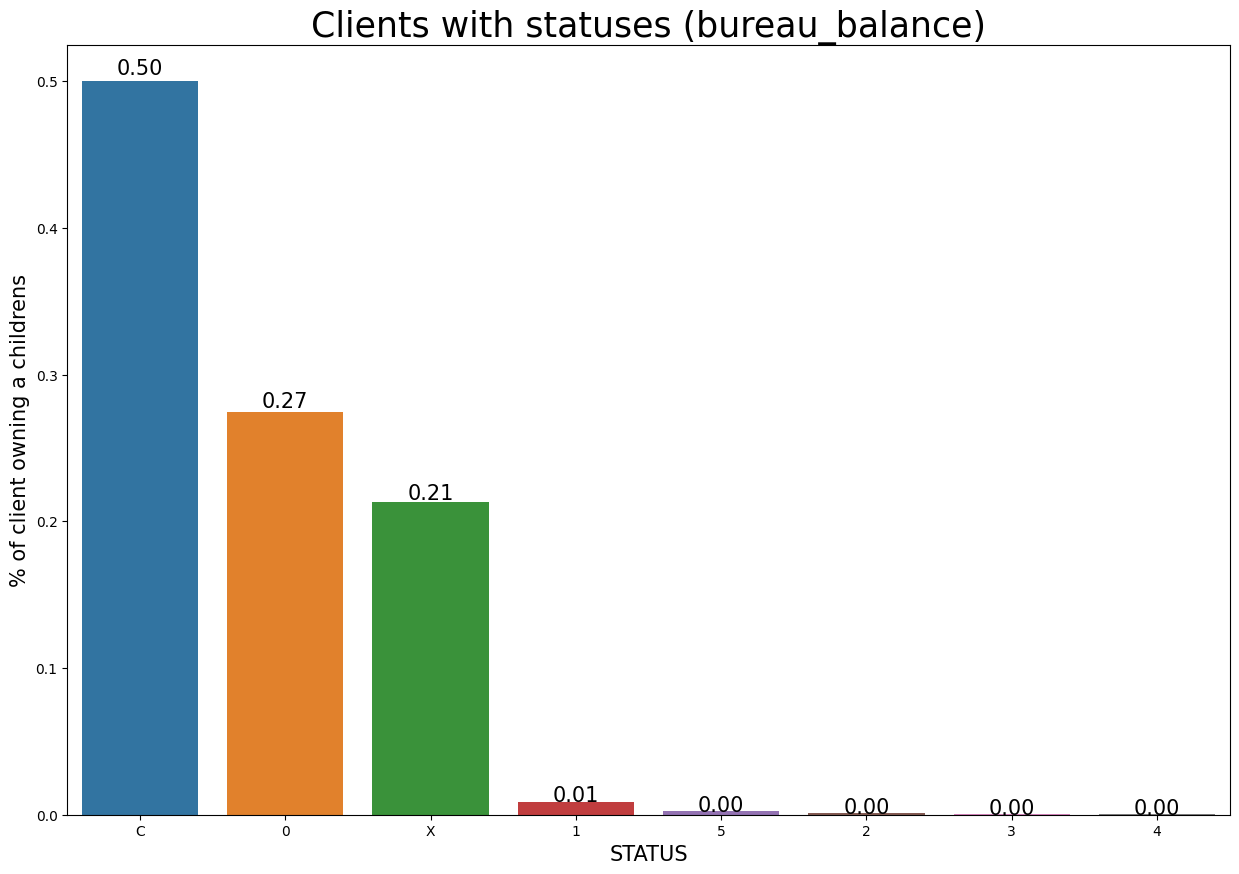

In [37]:
viz_df_bureau_balance.plot_value_counts(column='STATUS', inPurcent=True, title='Clients with statuses (bureau_balance)', xlabel='STATUS', ylabel='% of client owning a childrens')

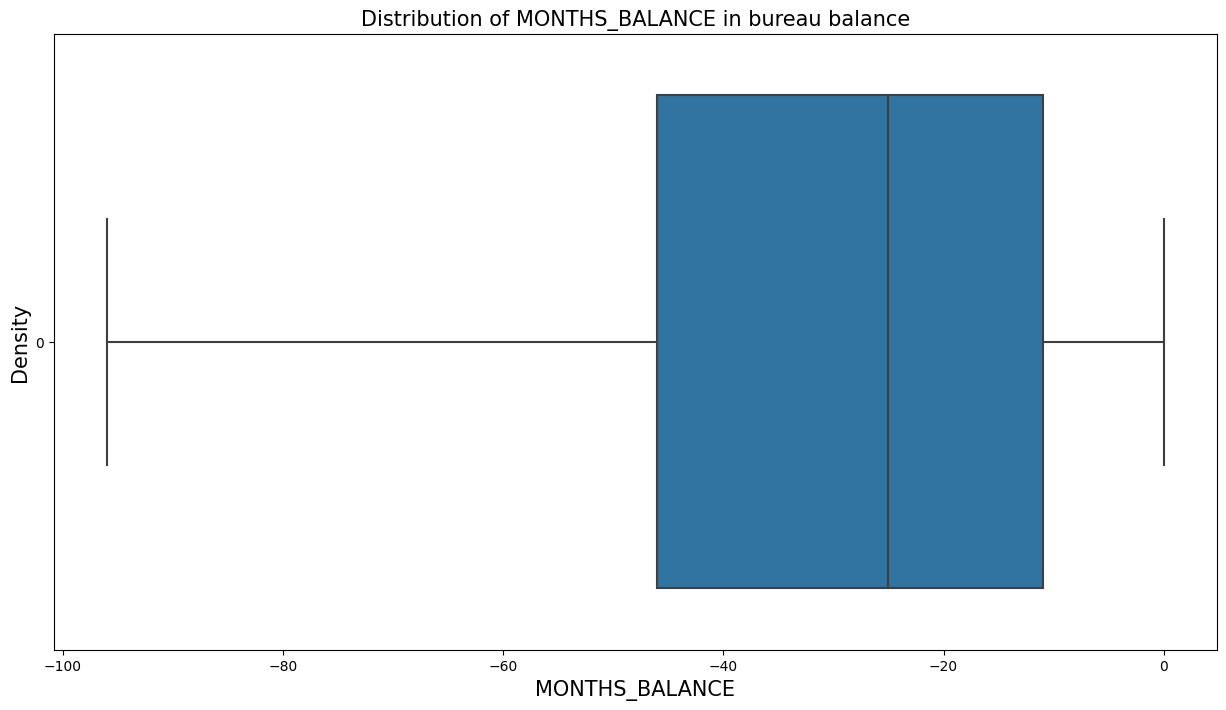

In [38]:
viz_df_bureau_balance.plot_density(columns = ['MONTHS_BALANCE'], dt = DensityTypes.Boxplot, title='Distribution of MONTHS_BALANCE in bureau balance', xlabel='MONTHS_BALANCE', ylabel='Density')

I do not observe outliers in this dataset. Passing to the Credit card balance dataset now.

### Credit card balance

In [39]:
df_credit_card_balance.data.describe()

SK_ID_PREV    SK_ID_CURR  MONTHS_BALANCE   AMT_BALANCE  \
count  3.840312e+06  3.840312e+06    3.840312e+06  3.840312e+06   
mean   1.904504e+06  2.783242e+05   -3.452192e+01  5.830016e+04   
std    5.364695e+05  1.027045e+05    2.666775e+01  1.063070e+05   
min    1.000018e+06  1.000060e+05   -9.600000e+01 -4.202502e+05   
25%    1.434385e+06  1.895170e+05   -5.500000e+01  0.000000e+00   
50%    1.897122e+06  2.783960e+05   -2.800000e+01  0.000000e+00   
75%    2.369328e+06  3.675800e+05   -1.100000e+01  8.904669e+04   
max    2.843496e+06  4.562500e+05   -1.000000e+00  1.505902e+06   

       AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  \
count             3.840312e+06              3.090496e+06   
mean              1.538080e+05              5.961325e+03   
std               1.651457e+05              2.822569e+04   
min               0.000000e+00             -6.827310e+03   
25%               4.500000e+04              0.000000e+00   
50%               1.125000e+05              0.000000e+00   
75%               1.800000e+05              0.000000e+00   
max               1.350000e+06              2.115000e+06   

       AMT_DRAWINGS_CURRENT  AMT_DRAWINGS_OTHER_CURRENT  \
count          3.840312e+06                3.090496e+06   
mean           7.433388e+03                2.881696e+02   
std            3.384608e+04                8.201989e+03   
min           -6.211620e+03                0.000000e+00   
25%            0.000000e+00                0.000000e+00   
50%            0.000000e+00                0.000000e+00   
75%            0.000000e+00                0.000000e+00   
max            2.287098e+06                1.529847e+06   

       AMT_DRAWINGS_POS_CURRENT  AMT_INST_MIN_REGULARITY  ...  \
count              3.090496e+06             3.535076e+06  ...   
mean               2.968805e+03             3.540204e+03  ...   
std                2.079689e+04             5.600154e+03  ...   
min                0.000000e+00             0.000000e+00  ...   
25%                0.000000e+00             0.000000e+00  ...   
50%                0.000000e+00             0.000000e+00  ...   
75%                0.000000e+00             6.633911e+03  ...   
max                2.239274e+06             2.028820e+05  ...   

       AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
count              3.840312e+06   3.840312e+06          3.840312e+06   
mean               5.596588e+04   5.808881e+04          5.809829e+04   
std                1.025336e+05   1.059654e+05          1.059718e+05   
min               -4.233058e+05  -4.202502e+05         -4.202502e+05   
25%                0.000000e+00   0.000000e+00          0.000000e+00   
50%                0.000000e+00   0.000000e+00          0.000000e+00   
75%                8.535924e+04   8.889949e+04          8.891451e+04   
max                1.472317e+06   1.493338e+06          1.493338e+06   

       CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  \
count              3.090496e+06          3.840312e+06   
mean               3.094490e-01          7.031439e-01   
std                1.100401e+00          3.190347e+00   
min                0.000000e+00          0.000000e+00   
25%                0.000000e+00          0.000000e+00   
50%                0.000000e+00          0.000000e+00   
75%                0.000000e+00          0.000000e+00   
max                5.100000e+01          1.650000e+02   

       CNT_DRAWINGS_OTHER_CURRENT  CNT_DRAWINGS_POS_CURRENT  \
count                3.090496e+06              3.090496e+06   
mean                 4.812496e-03              5.594791e-01   
std                  8.263861e-02              3.240649e+00   
min                  0.000000e+00              0.000000e+00   
25%                  0.000000e+00              0.000000e+00   
50%                  0.000000e+00              0.000000e+00   
75%                  0.000000e+00              0.000000e+00   
max                  1.200000e+01              1.650000e+02   

       CNT_INST

In [40]:
df_credit_card_balance.data.describe(include=[object])

NAME_CONTRACT_STATUS
count               3840312
unique                    7
top                  Active
freq                3698436

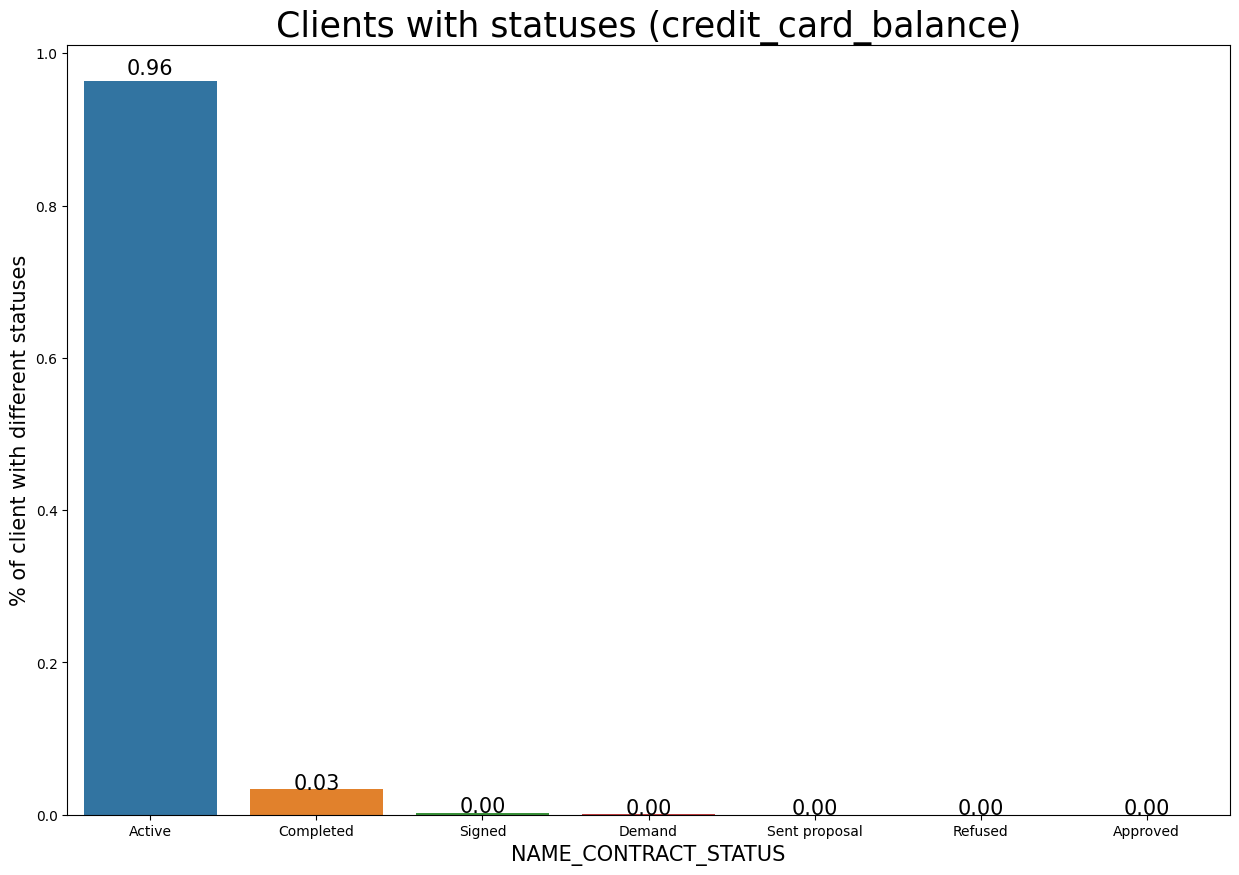

In [41]:
viz_df_credit_card_balance.plot_value_counts(column='NAME_CONTRACT_STATUS', inPurcent=True, title='Clients with statuses (credit_card_balance)', xlabel='NAME_CONTRACT_STATUS', ylabel='% of client with different statuses')

Most of the credit card balances are active.

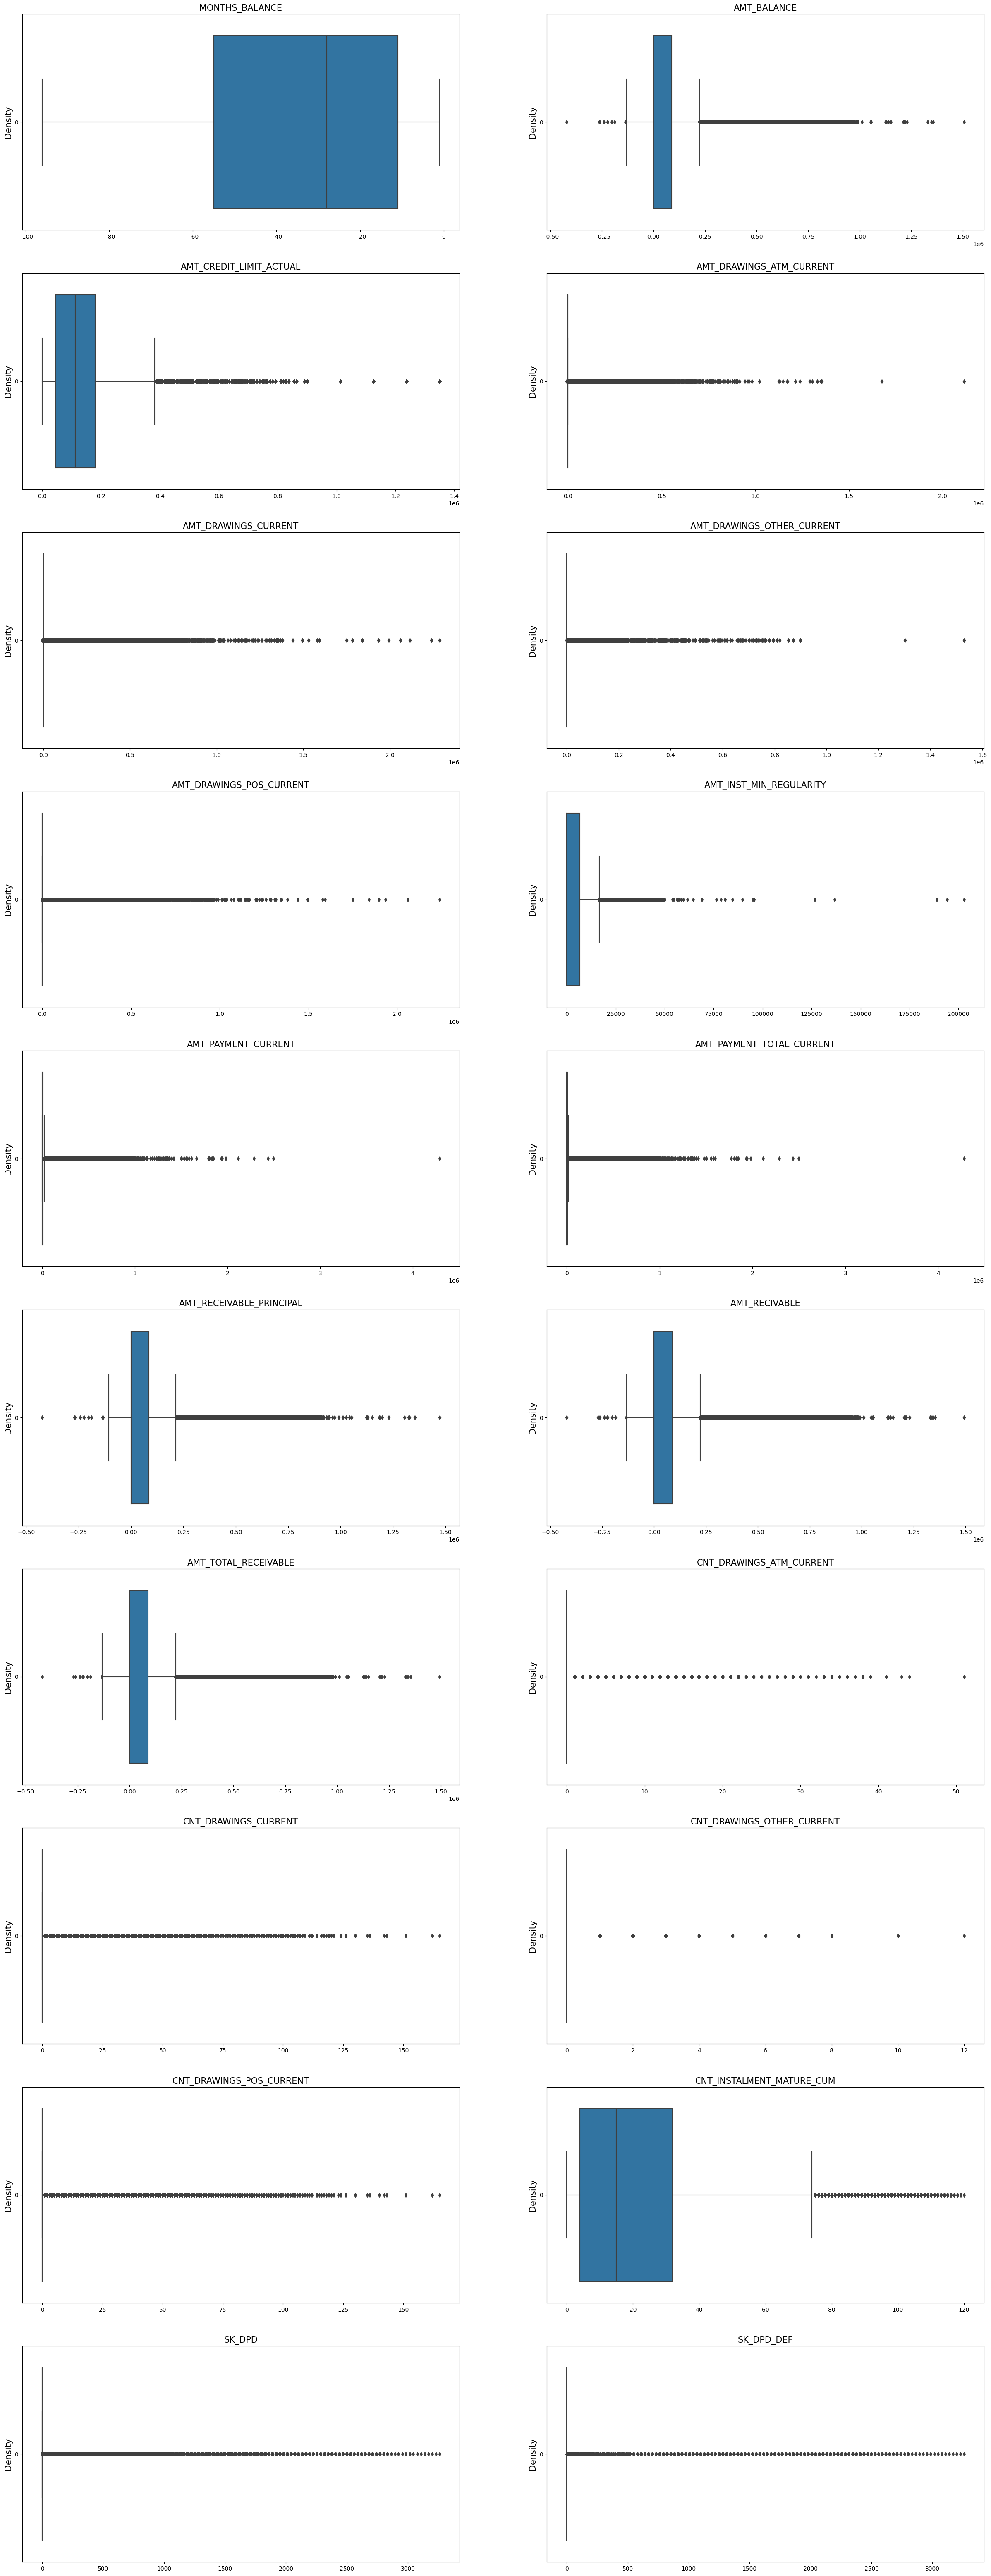

In [25]:
cols = ['MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'SK_DPD',
       'SK_DPD_DEF']
viz_df_credit_card_balance.plot_density(columns = cols, dt = DensityTypes.Boxplot)

In this case, I do not observe any outliers. Everything seems normal.

### Installments payment

In [26]:
df_installments_payments.data.describe()

SK_ID_PREV    SK_ID_CURR  NUM_INSTALMENT_VERSION  \
count  1.360540e+07  1.360540e+07            1.360540e+07   
mean   1.903365e+06  2.784449e+05            8.566373e-01   
std    5.362029e+05  1.027183e+05            1.035216e+00   
min    1.000001e+06  1.000010e+05            0.000000e+00   
25%    1.434191e+06  1.896390e+05            0.000000e+00   
50%    1.896520e+06  2.786850e+05            1.000000e+00   
75%    2.369094e+06  3.675300e+05            1.000000e+00   
max    2.843499e+06  4.562550e+05            1.780000e+02   

       NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  \
count           1.360540e+07     1.360540e+07        1.360250e+07   
mean            1.887090e+01    -1.042270e+03       -1.051114e+03   
std             2.666407e+01     8.009463e+02        8.005859e+02   
min             1.000000e+00    -2.922000e+03       -4.921000e+03   
25%             4.000000e+00    -1.654000e+03       -1.662000e+03   
50%             8.000000e+00    -8.180000e+02       -8.270000e+02   
75%             1.900000e+01    -3.610000e+02       -3.700000e+02   
max             2.770000e+02    -1.000000e+00       -1.000000e+00   

       AMT_INSTALMENT   AMT_PAYMENT  
count    1.360540e+07  1.360250e+07  
mean     1.705091e+04  1.723822e+04  
std      5.057025e+04  5.473578e+04  
min      0.000000e+00  0.000000e+00  
25%      4.226085e+03  3.398265e+03  
50%      8.884080e+03  8.125515e+03  
75%      1.671021e+04  1.610842e+04  
max      3.771488e+06  3.771488e+06

I see that `df_installments_payments` dataset does not have categorical variables.

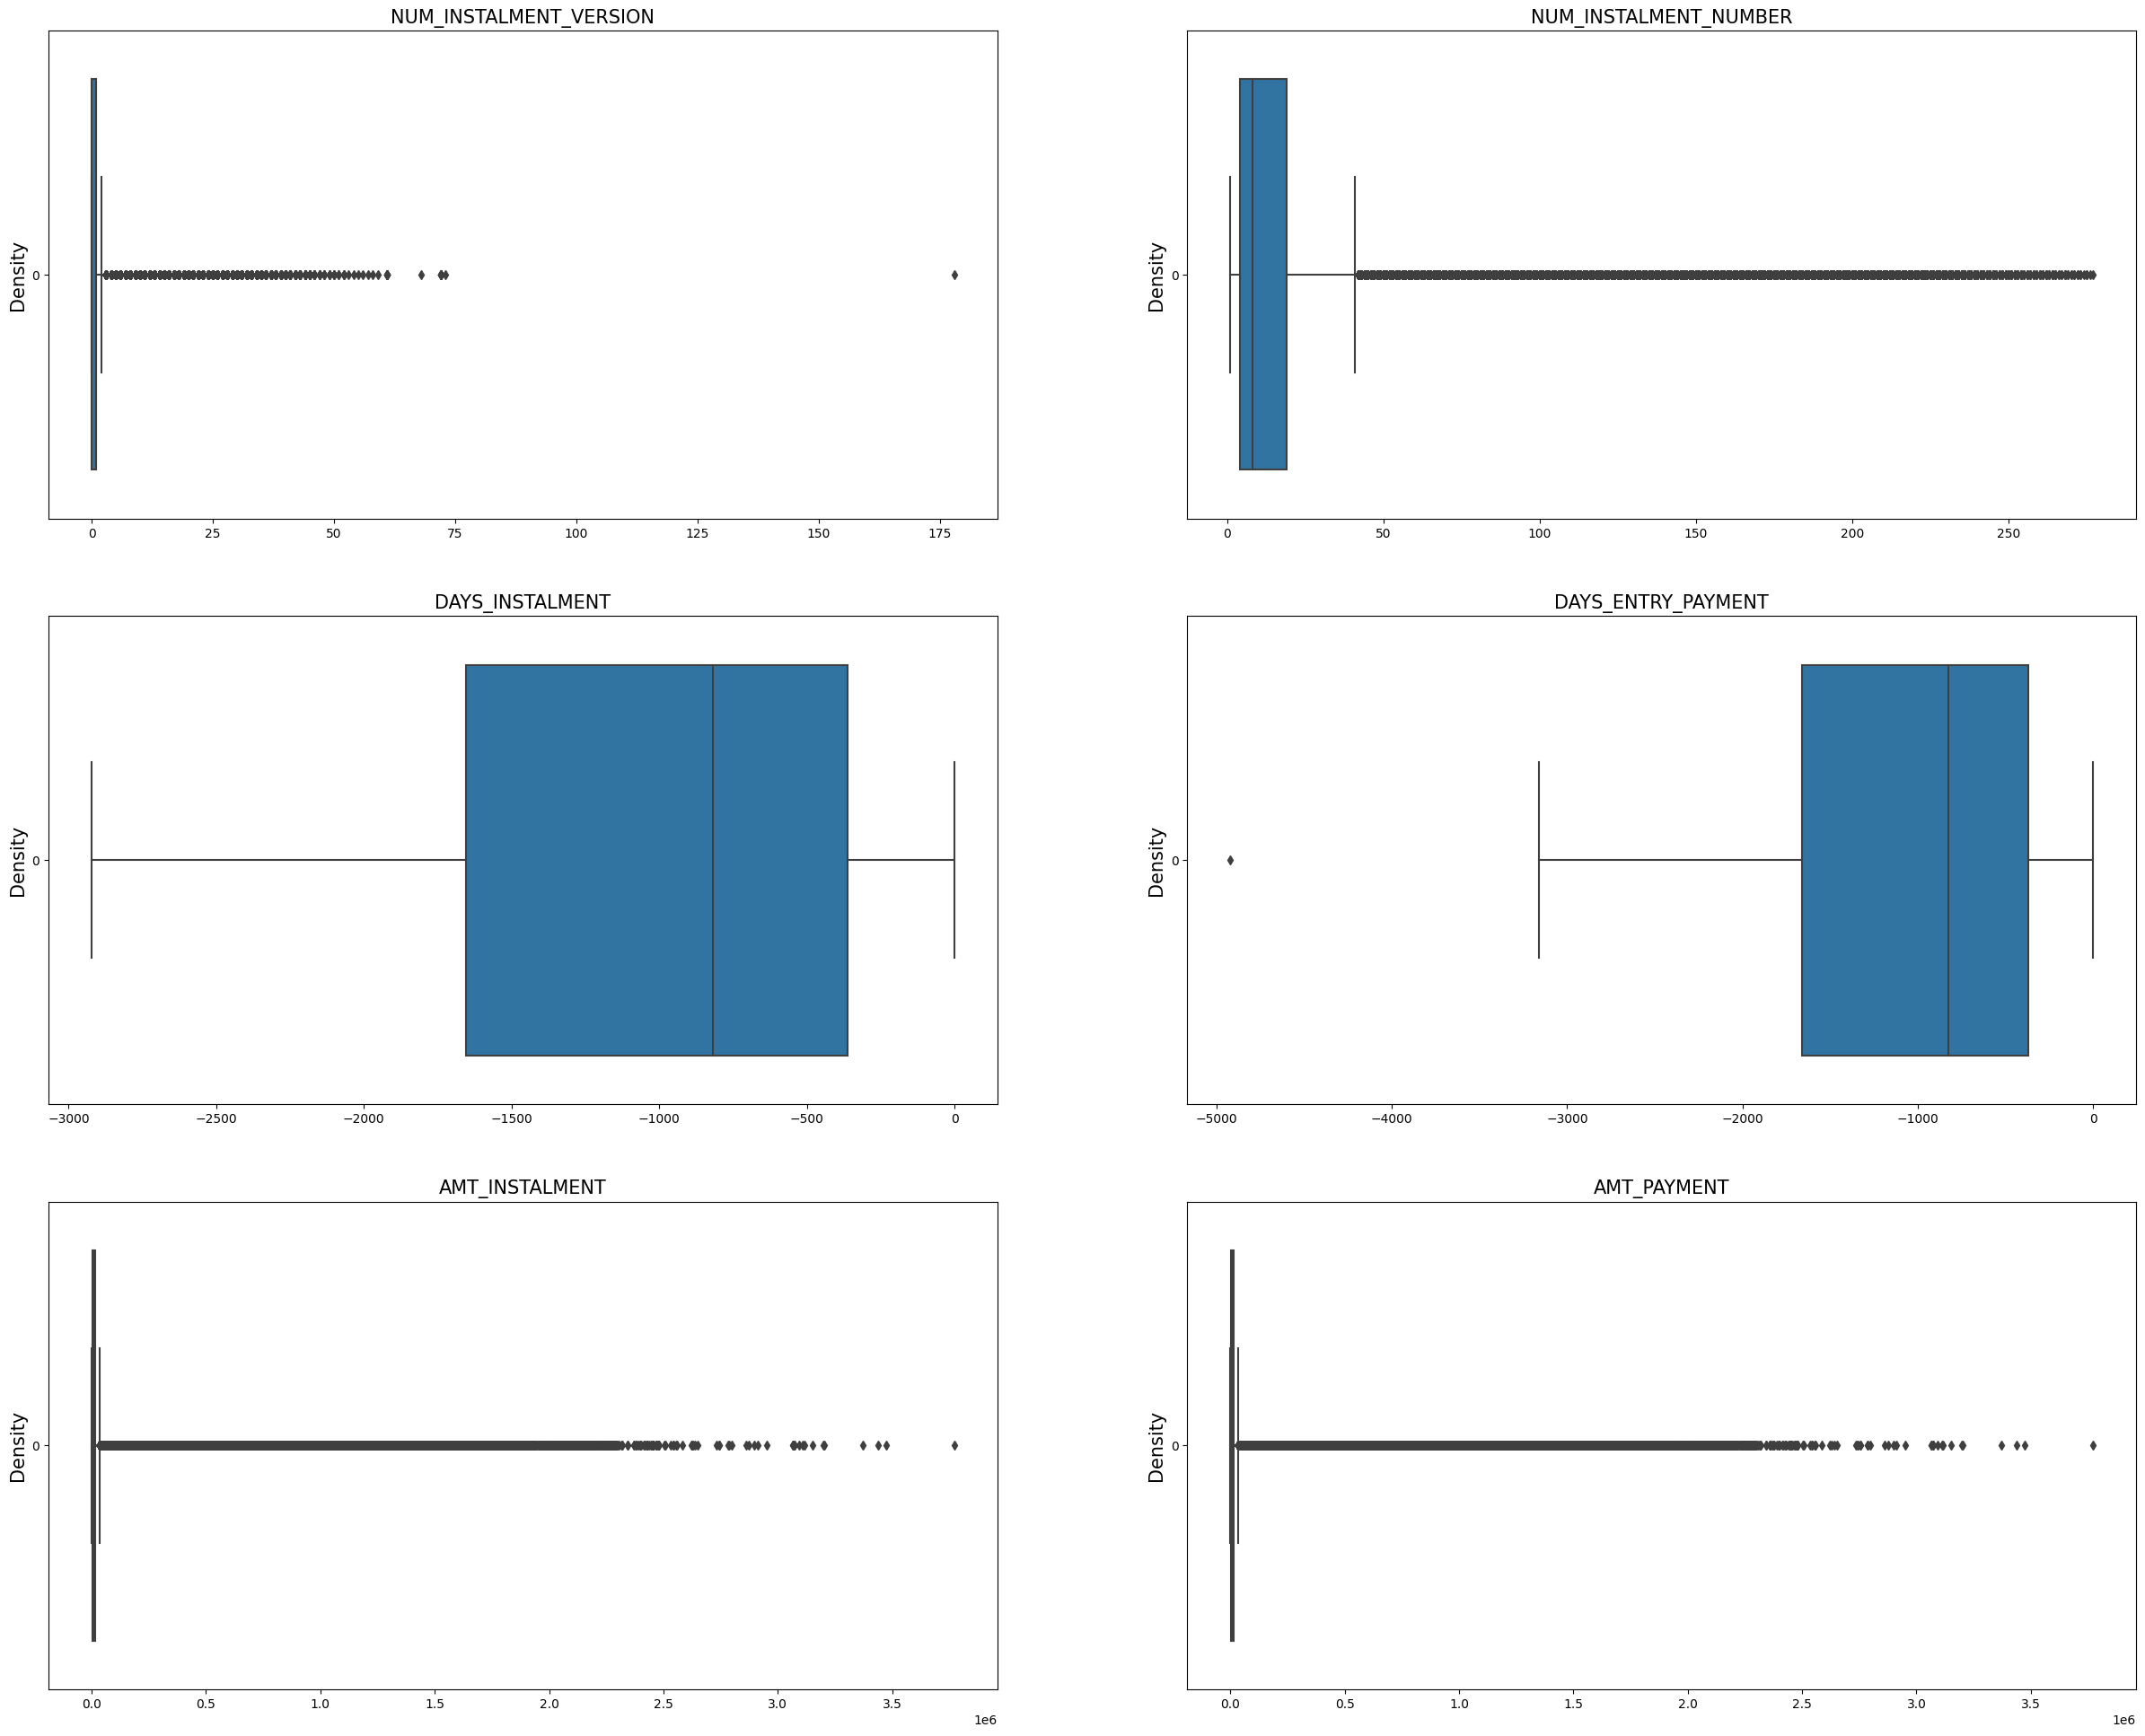

In [27]:
cols = ['NUM_INSTALMENT_VERSION',
       'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
       'AMT_INSTALMENT', 'AMT_PAYMENT']

viz_df_installments_payments.plot_density(columns = cols, dt = DensityTypes.Boxplot)

In the previous figure, we observed some unusual values. However, there are some values that seem acceptable to me. Therefore no deals are omitted here. It is possible, however, to pay attention to these non-standard values when filling out the nan values.

### POS Cash ballance

In [26]:
df_POS_CASH_balance.data.describe()

SK_ID_PREV    SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
count  1.000136e+07  1.000136e+07    1.000136e+07    9.975287e+06   
mean   1.903217e+06  2.784039e+05   -3.501259e+01    1.708965e+01   
std    5.358465e+05  1.027637e+05    2.606657e+01    1.199506e+01   
min    1.000001e+06  1.000010e+05   -9.600000e+01    1.000000e+00   
25%    1.434405e+06  1.895500e+05   -5.400000e+01    1.000000e+01   
50%    1.896565e+06  2.786540e+05   -2.800000e+01    1.200000e+01   
75%    2.368963e+06  3.674290e+05   -1.300000e+01    2.400000e+01   
max    2.843499e+06  4.562550e+05   -1.000000e+00    9.200000e+01   

       CNT_INSTALMENT_FUTURE        SK_DPD    SK_DPD_DEF  
count           9.975271e+06  1.000136e+07  1.000136e+07  
mean            1.048384e+01  1.160693e+01  6.544684e-01  
std             1.110906e+01  1.327140e+02  3.276249e+01  
min             0.000000e+00  0.000000e+00  0.000000e+00  
25%             3.000000e+00  0.000000e+00  0.000000e+00  
50%             7.000000e+00  0.000000e+00  0.000000e+00  
75%             1.400000e+01  0.000000e+00  0.000000e+00  
max             8.500000e+01  4.231000e+03  3.595000e+03

In [27]:
df_POS_CASH_balance.data.describe(include=[object])

NAME_CONTRACT_STATUS
count              10001358
unique                    9
top                  Active
freq                9151119

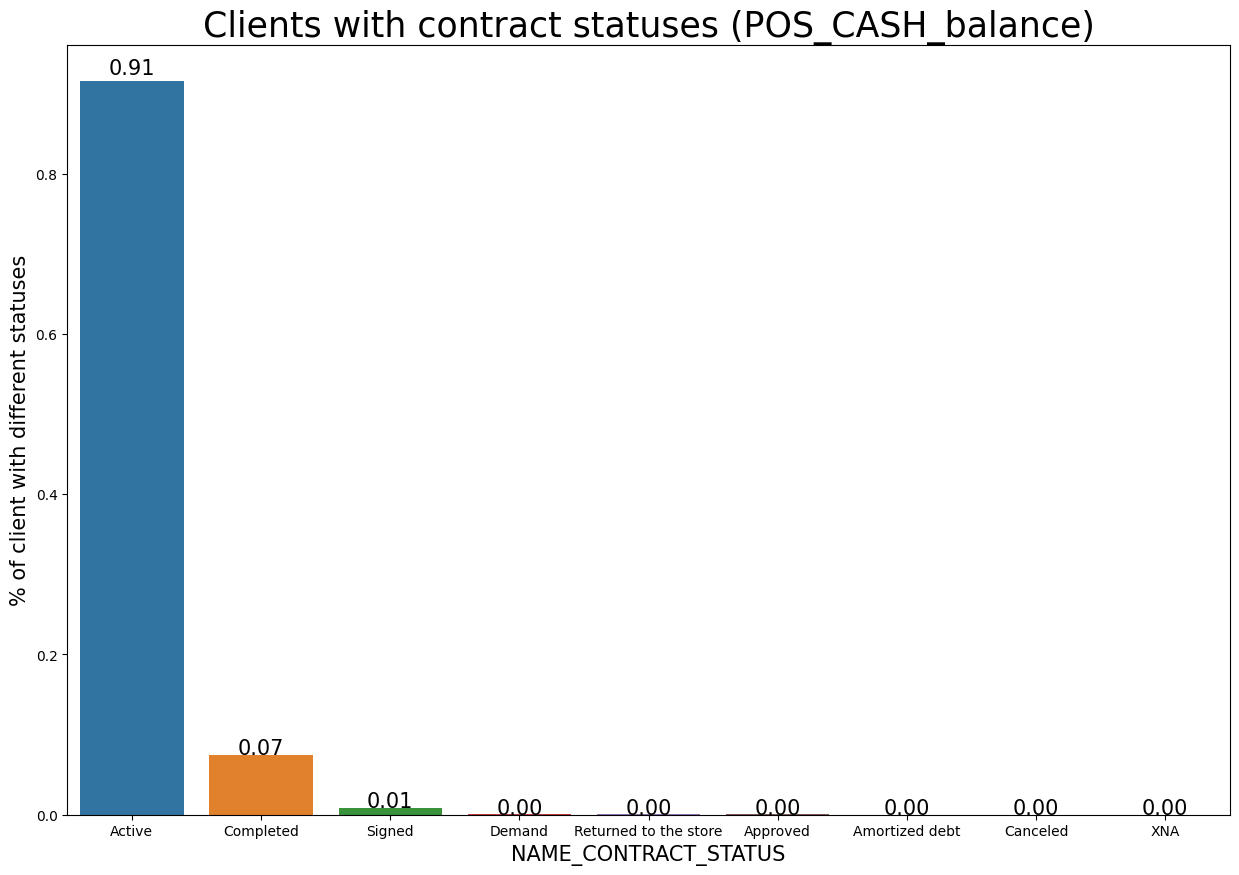

In [31]:
viz_df_POS_CASH_balance.plot_value_counts(column='NAME_CONTRACT_STATUS', inPurcent=True, title='Clients with contract statuses (POS_CASH_balance)', xlabel='NAME_CONTRACT_STATUS', ylabel='% of client with different statuses')


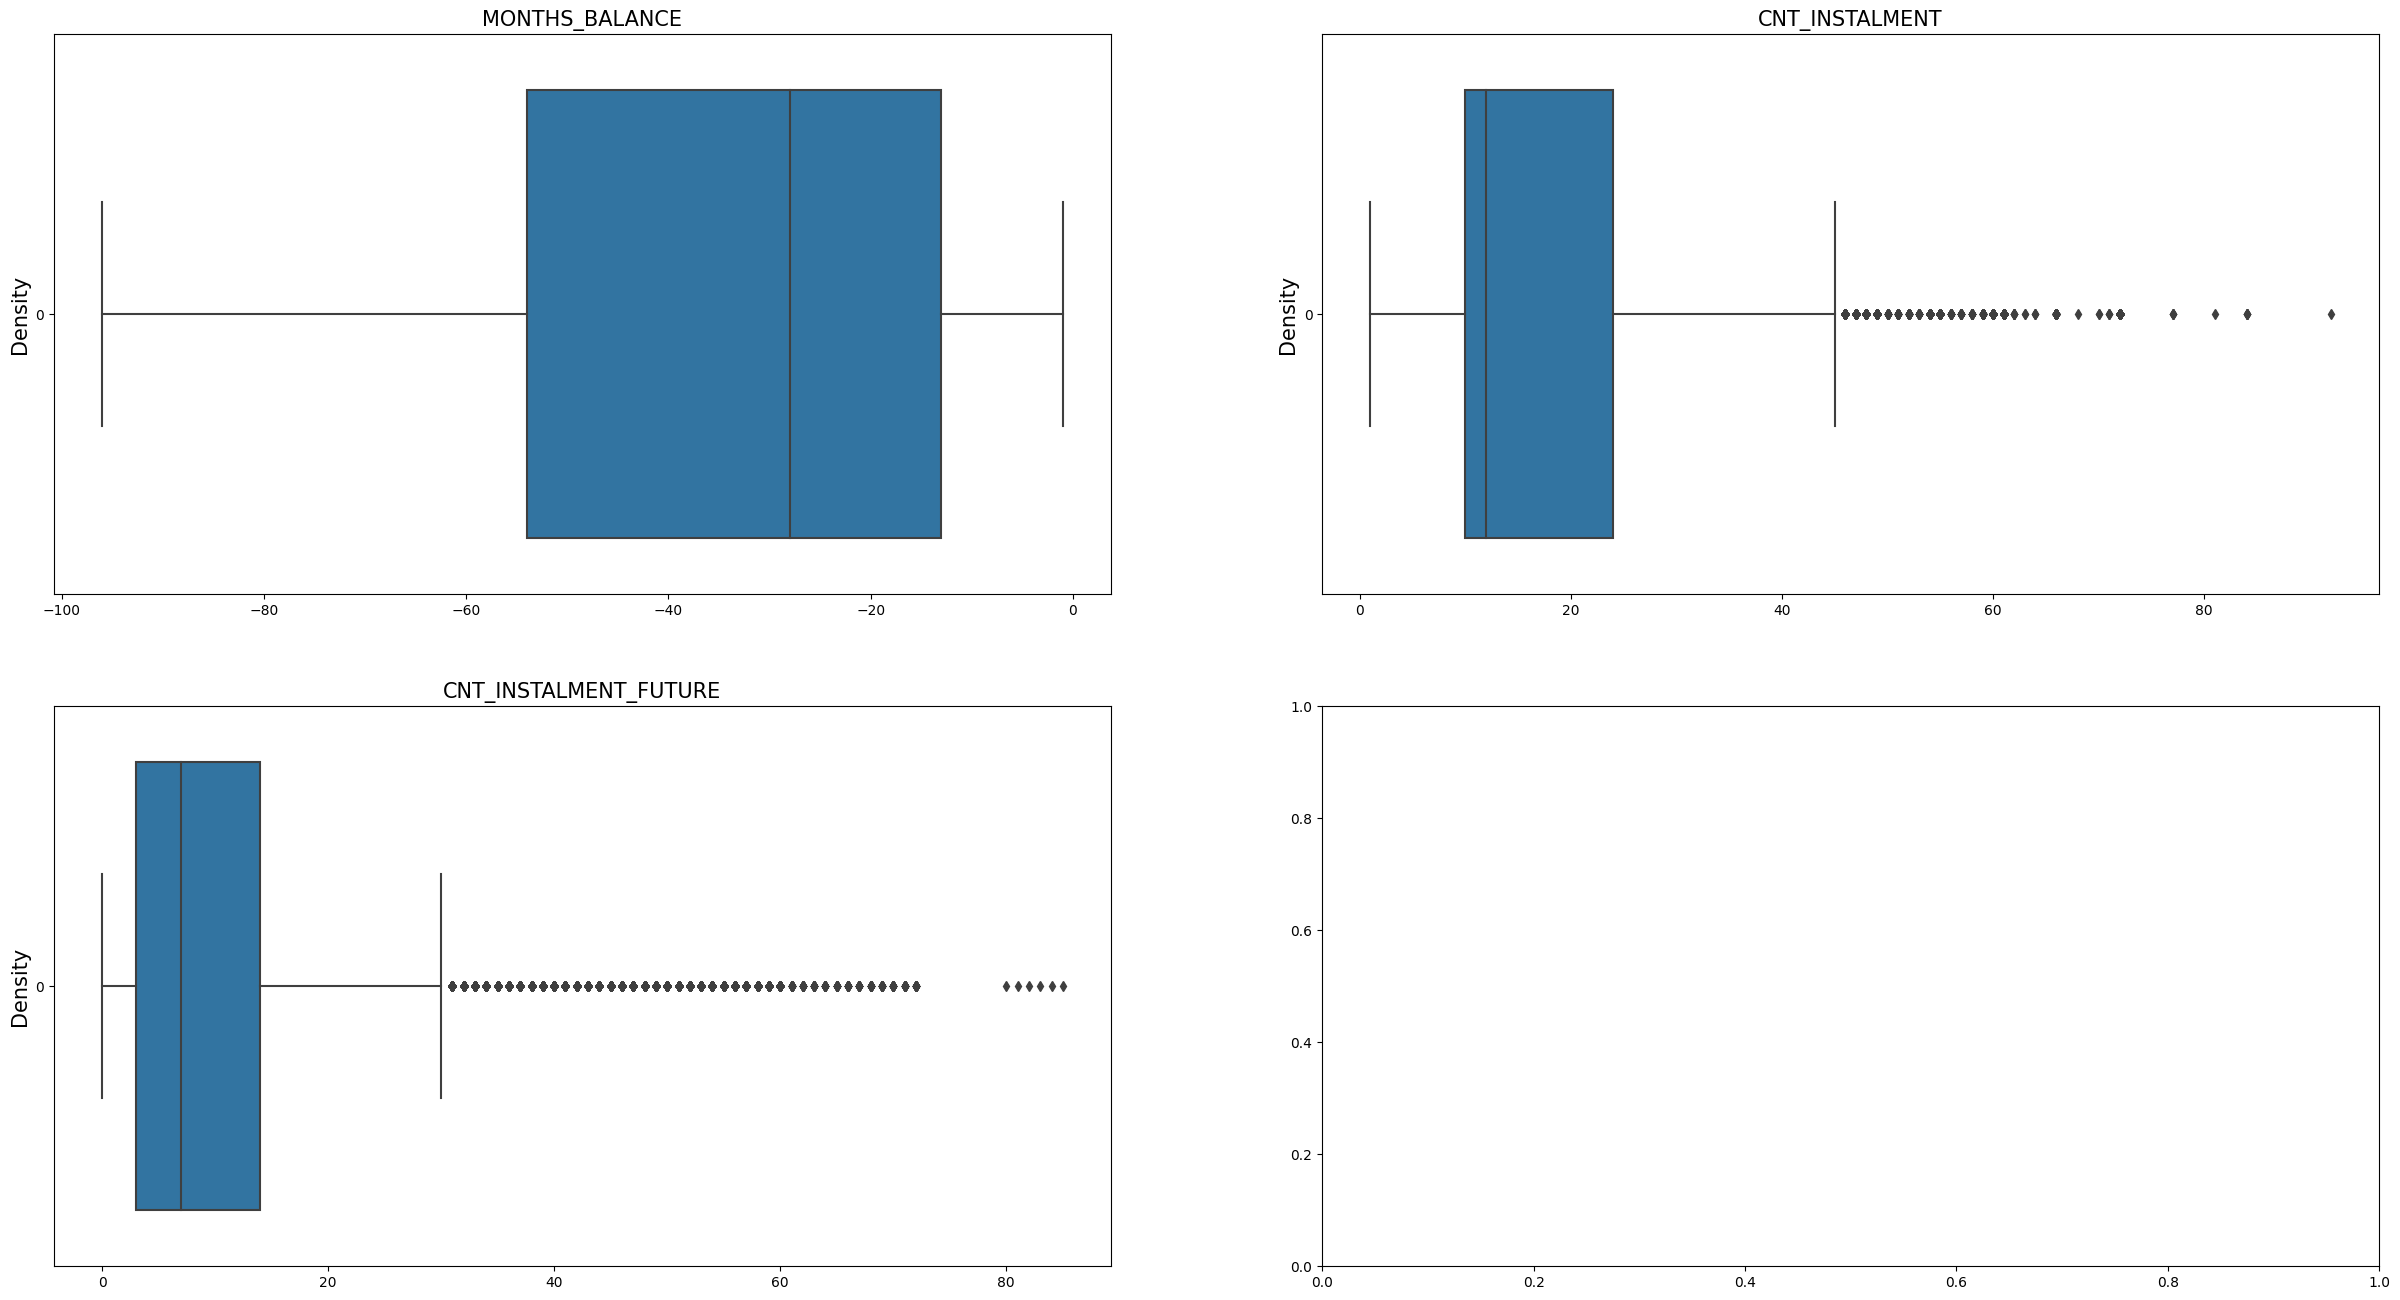

In [30]:
cols = ['MONTHS_BALANCE', 'CNT_INSTALMENT',
       'CNT_INSTALMENT_FUTURE']
viz_df_POS_CASH_balance.plot_density(columns = cols, dt = DensityTypes.Boxplot)

### Previous application

In [32]:
df_previous_application.data.describe()

SK_ID_PREV    SK_ID_CURR   AMT_ANNUITY  AMT_APPLICATION  \
count  1.670214e+06  1.670214e+06  1.297979e+06     1.670214e+06   
mean   1.923089e+06  2.783572e+05  1.595512e+04     1.752339e+05   
std    5.325980e+05  1.028148e+05  1.478214e+04     2.927798e+05   
min    1.000001e+06  1.000010e+05  0.000000e+00     0.000000e+00   
25%    1.461857e+06  1.893290e+05  6.321780e+03     1.872000e+04   
50%    1.923110e+06  2.787145e+05  1.125000e+04     7.104600e+04   
75%    2.384280e+06  3.675140e+05  2.065842e+04     1.803600e+05   
max    2.845382e+06  4.562550e+05  4.180581e+05     6.905160e+06   

         AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  \
count  1.670213e+06      7.743700e+05     1.284699e+06   
mean   1.961140e+05      6.697402e+03     2.278473e+05   
std    3.185746e+05      2.092150e+04     3.153966e+05   
min    0.000000e+00     -9.000000e-01     0.000000e+00   
25%    2.416050e+04      0.000000e+00     5.084100e+04   
50%    8.054100e+04      1.638000e+03     1.123200e+05   
75%    2.164185e+05      7.740000e+03     2.340000e+05   
max    6.905160e+06      3.060045e+06     6.905160e+06   

       HOUR_APPR_PROCESS_START  NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  \
count             1.670214e+06            1.670214e+06      774370.000000   
mean              1.248418e+01            9.964675e-01           0.079637   
std               3.334028e+00            5.932963e-02           0.107823   
min               0.000000e+00            0.000000e+00          -0.000015   
25%               1.000000e+01            1.000000e+00           0.000000   
50%               1.200000e+01            1.000000e+00           0.051605   
75%               1.500000e+01            1.000000e+00           0.108909   
max               2.300000e+01            1.000000e+00           1.000000   

       ...  RATE_INTEREST_PRIVILEGED  DAYS_DECISION  SELLERPLACE_AREA  \
count  ...               5951.000000   1.670214e+06      1.670214e+06   
mean   ...                  0.773503  -8.806797e+02      3.139511e+02   
std    ...                  0.100879   7.790997e+02      7.127443e+03   
min    ...                  0.373150  -2.922000e+03     -1.000000e+00   
25%    ...                  0.715645  -1.300000e+03     -1.000000e+00   
50%    ...                  0.835095  -5.810000e+02      3.000000e+00   
75%    ...                  0.852537  -2.800000e+02      8.200000e+01   
max    ...                  1.000000  -1.000000e+00      4.000000e+06   

        CNT_PAYMENT  DAYS_FIRST_DRAWING  DAYS_FIRST_DUE  \
count  1.297984e+06       997149.000000   997149.000000   
mean   1.605408e+01       342209.855039    13826.269337   
std    1.456729e+01        88916.115833    72444.869708   
min    0.000000e+00        -2922.000000    -2892.000000   
25%    6.000000e+00       365243.000000    -1628.000000   
50%    1.200000e+01       365243.000000     -831.000000   
75%    2.400000e+01       365243.000000     -411.000000   
max    8.400000e+01       365243.000000   365243.000000   

       DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  DAYS_TERMINATION  \
count              997149.000000  997149.000000     997149.000000   
mean                33767.774054   76582.403064      81992.343838   
std                106857.034789  149647.415123     153303.516729   
min                 -2801.000000   -2889.000000      -2874.000000   
25%                 -1242.000000   -1314.000000      -1270.000000   
50%                  -361.000000    -537.000000       -499.000000   
75%                   129.000000     -74.000000        -44.000000   
max                365243.000000  365243.000000     365243.000000   

       NFLAG_INSURED_ON_APPROVAL  
count              997149.000000  
mean                    0.332570  
std                     0.471134  
min                     0.000000  
25%                     0.000000  
50%                     0.000000  
75%                     1.000000  
max                     1.000000  

[8 rows x 21 columns]

In [33]:
df_previous_application.data.describe(include=[object])

NAME_CONTRACT_TYPE WEEKDAY_APPR_PROCESS_START  \
count             1670214                    1670214   
unique                  4                          7   
top            Cash loans                    TUESDAY   
freq               747553                     255118   

       FLAG_LAST_APPL_PER_CONTRACT NAME_CASH_LOAN_PURPOSE  \
count                      1670214                1670214   
unique                           2                     25   
top                              Y                    XAP   
freq                       1661739                 922661   

       NAME_CONTRACT_STATUS      NAME_PAYMENT_TYPE CODE_REJECT_REASON  \
count               1670214                1670214            1670214   
unique                    4                      4                  9   
top                Approved  Cash through the bank                XAP   
freq                1036781                1033552            1353093   

       NAME_TYPE_SUITE NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO  \
count           849809          1670214             1670214        1670214   
unique               7                4                  28              5   
top      Unaccompanied         Repeater                 XNA            POS   
freq            508970          1231261              950809         691011   

       NAME_PRODUCT_TYPE             CHANNEL_TYPE NAME_SELLER_INDUSTRY  \
count            1670214                  1670214              1670214   
unique                 3                        8                   11   
top                  XNA  Credit and cash offices                  XNA   
freq             1063666                   719968               855720   

       NAME_YIELD_GROUP PRODUCT_COMBINATION  
count           1670214             1669868  
unique                5                  17  
top                 XNA                Cash  
freq             517215              285990

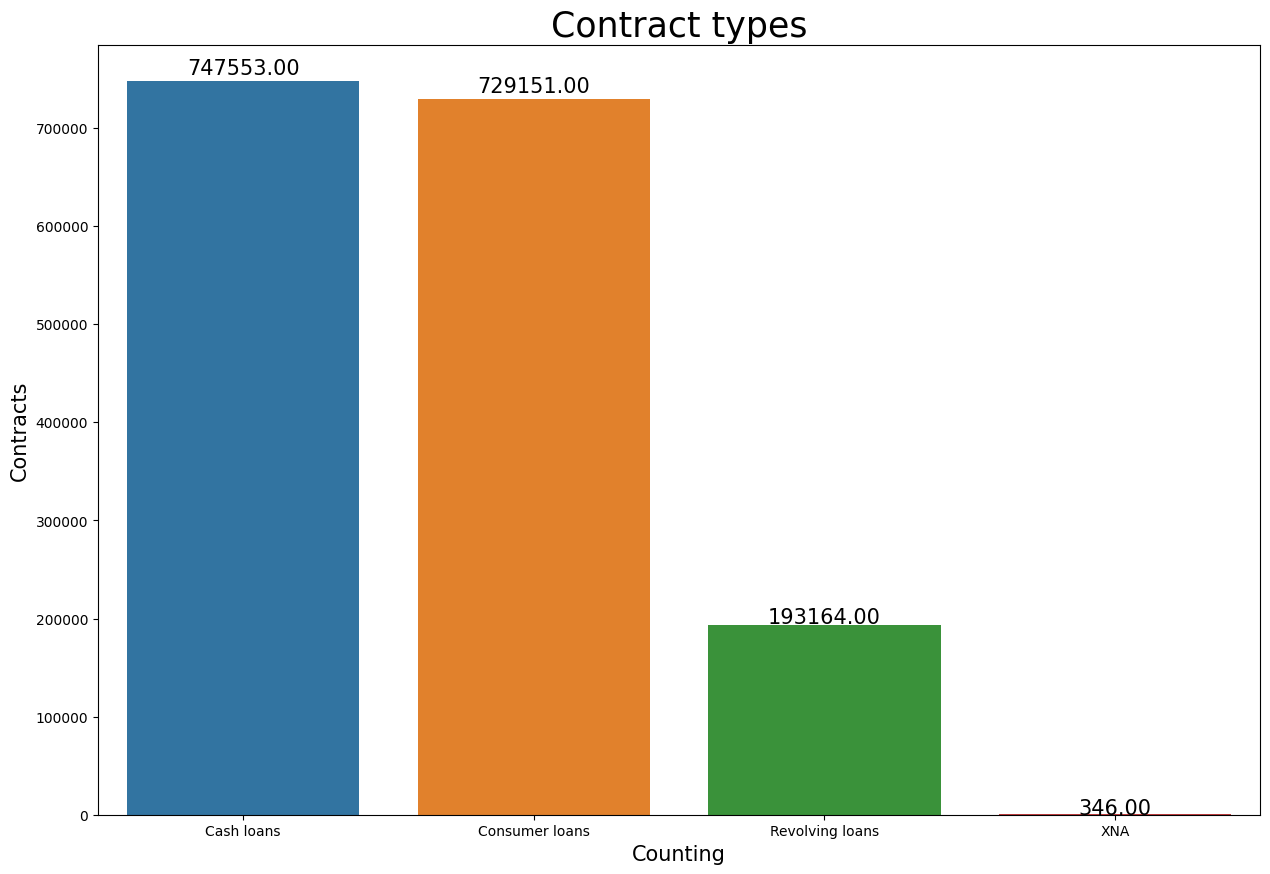

In [35]:
viz_df_previous_application.plot_value_counts(column='NAME_CONTRACT_TYPE', title='Contract types', xlabel='Counting', ylabel='Contracts')

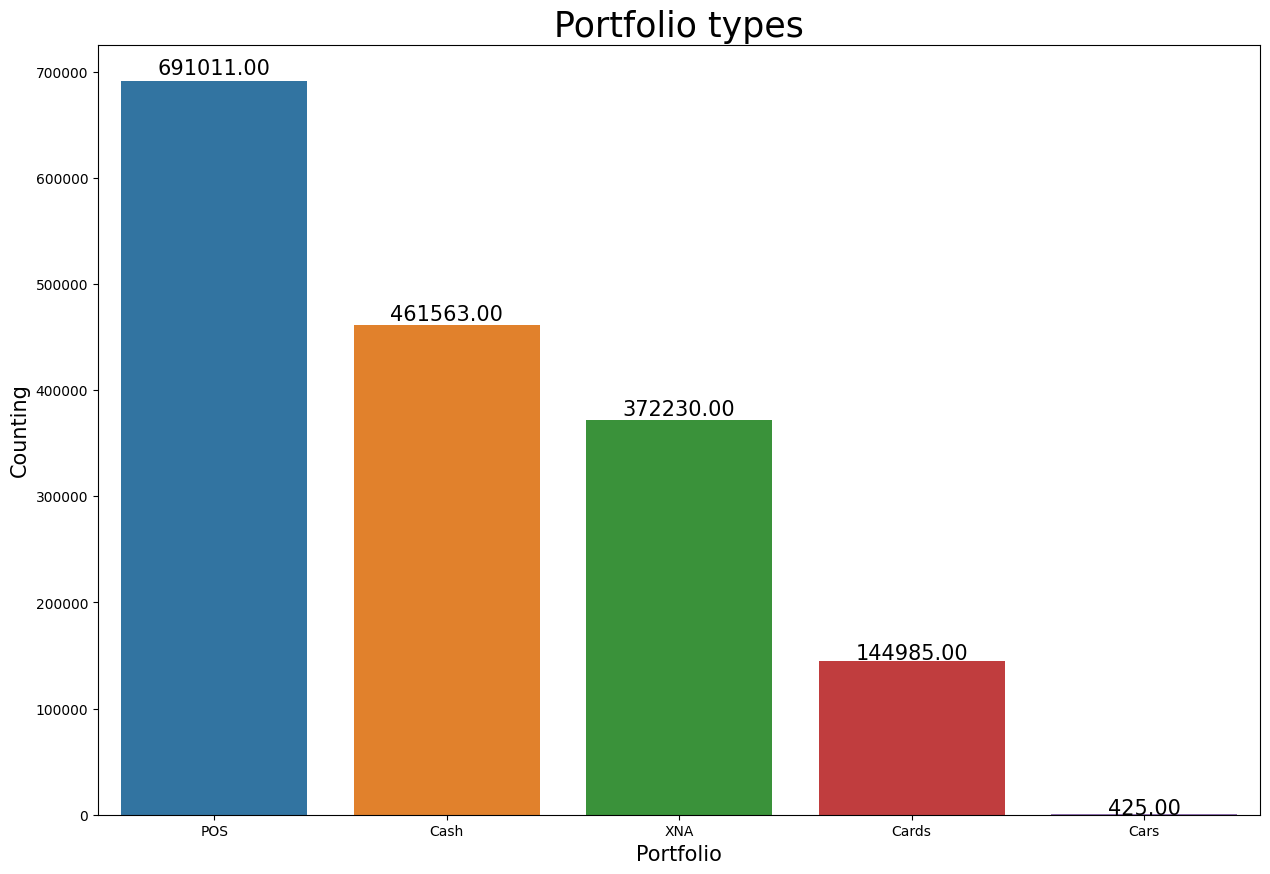

In [37]:
viz_df_previous_application.plot_value_counts(column='NAME_PORTFOLIO', title='Portfolio types', ylabel='Counting', xlabel='Portfolio')

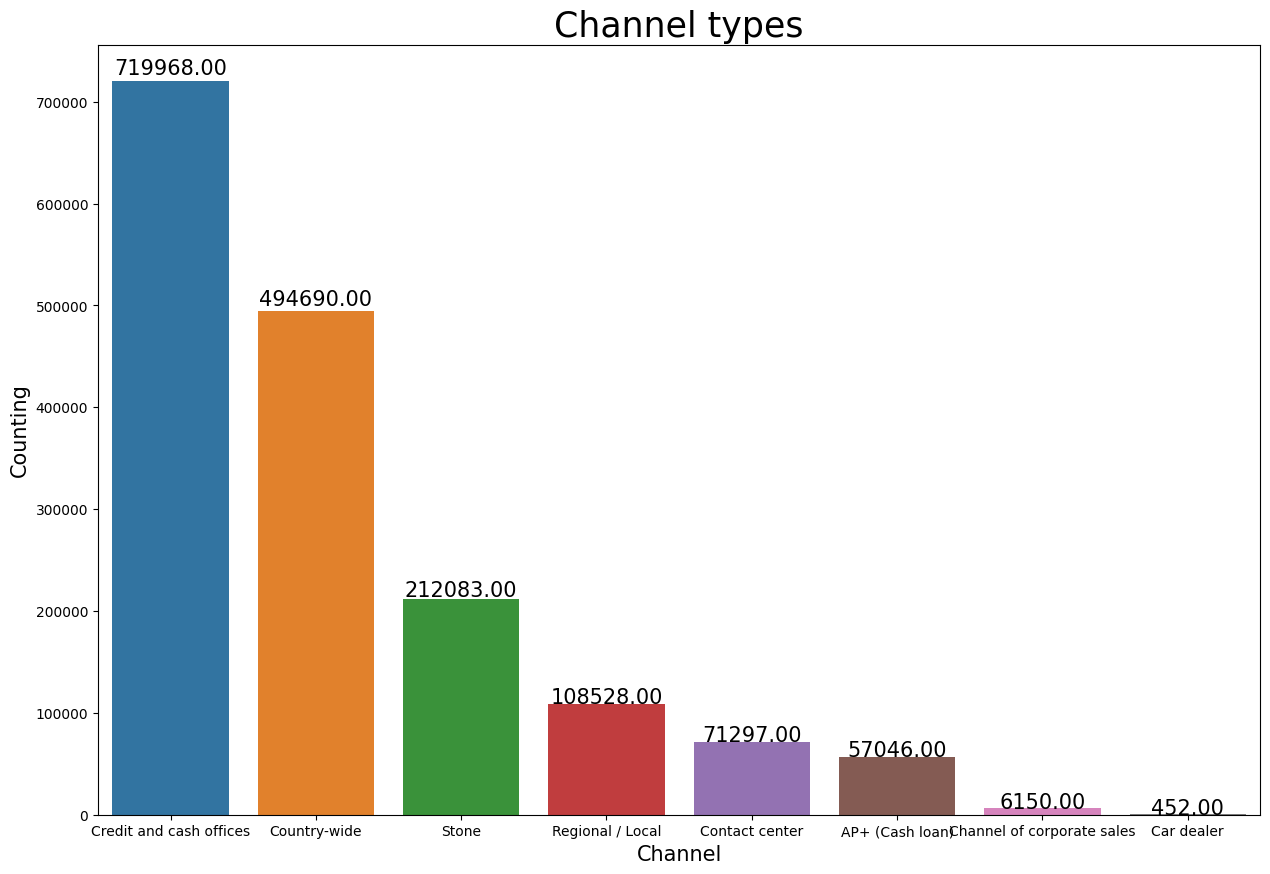

In [38]:
viz_df_previous_application.plot_value_counts(column='CHANNEL_TYPE', title='Channel types', ylabel='Counting', xlabel='Channel')

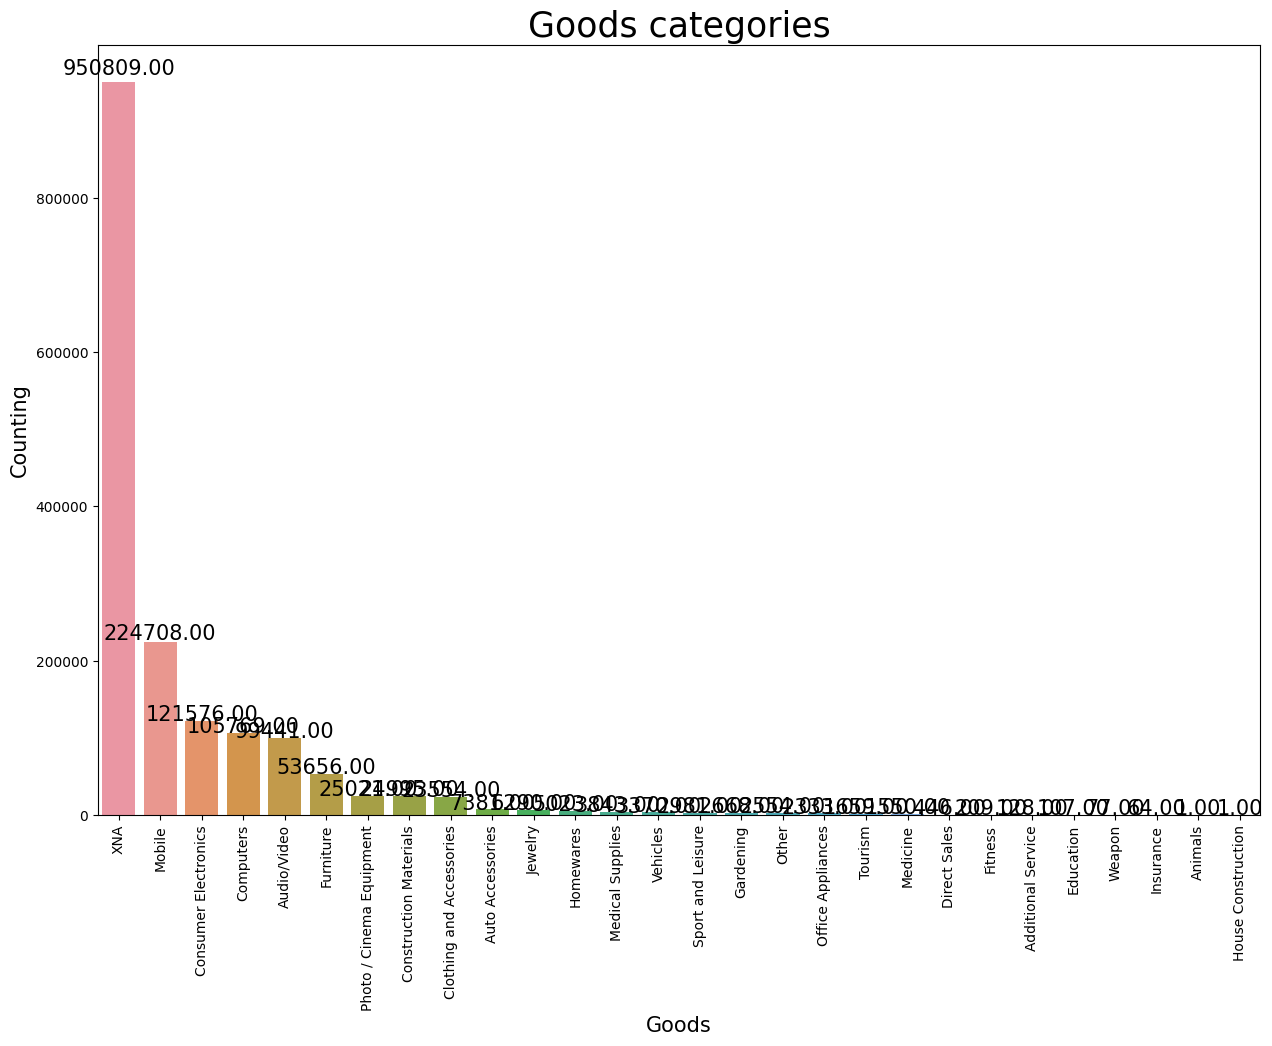

In [40]:
viz_df_previous_application.plot_value_counts(column='NAME_GOODS_CATEGORY', title='Goods categories', ylabel='Counting', xlabel='Goods', xrotation=90)

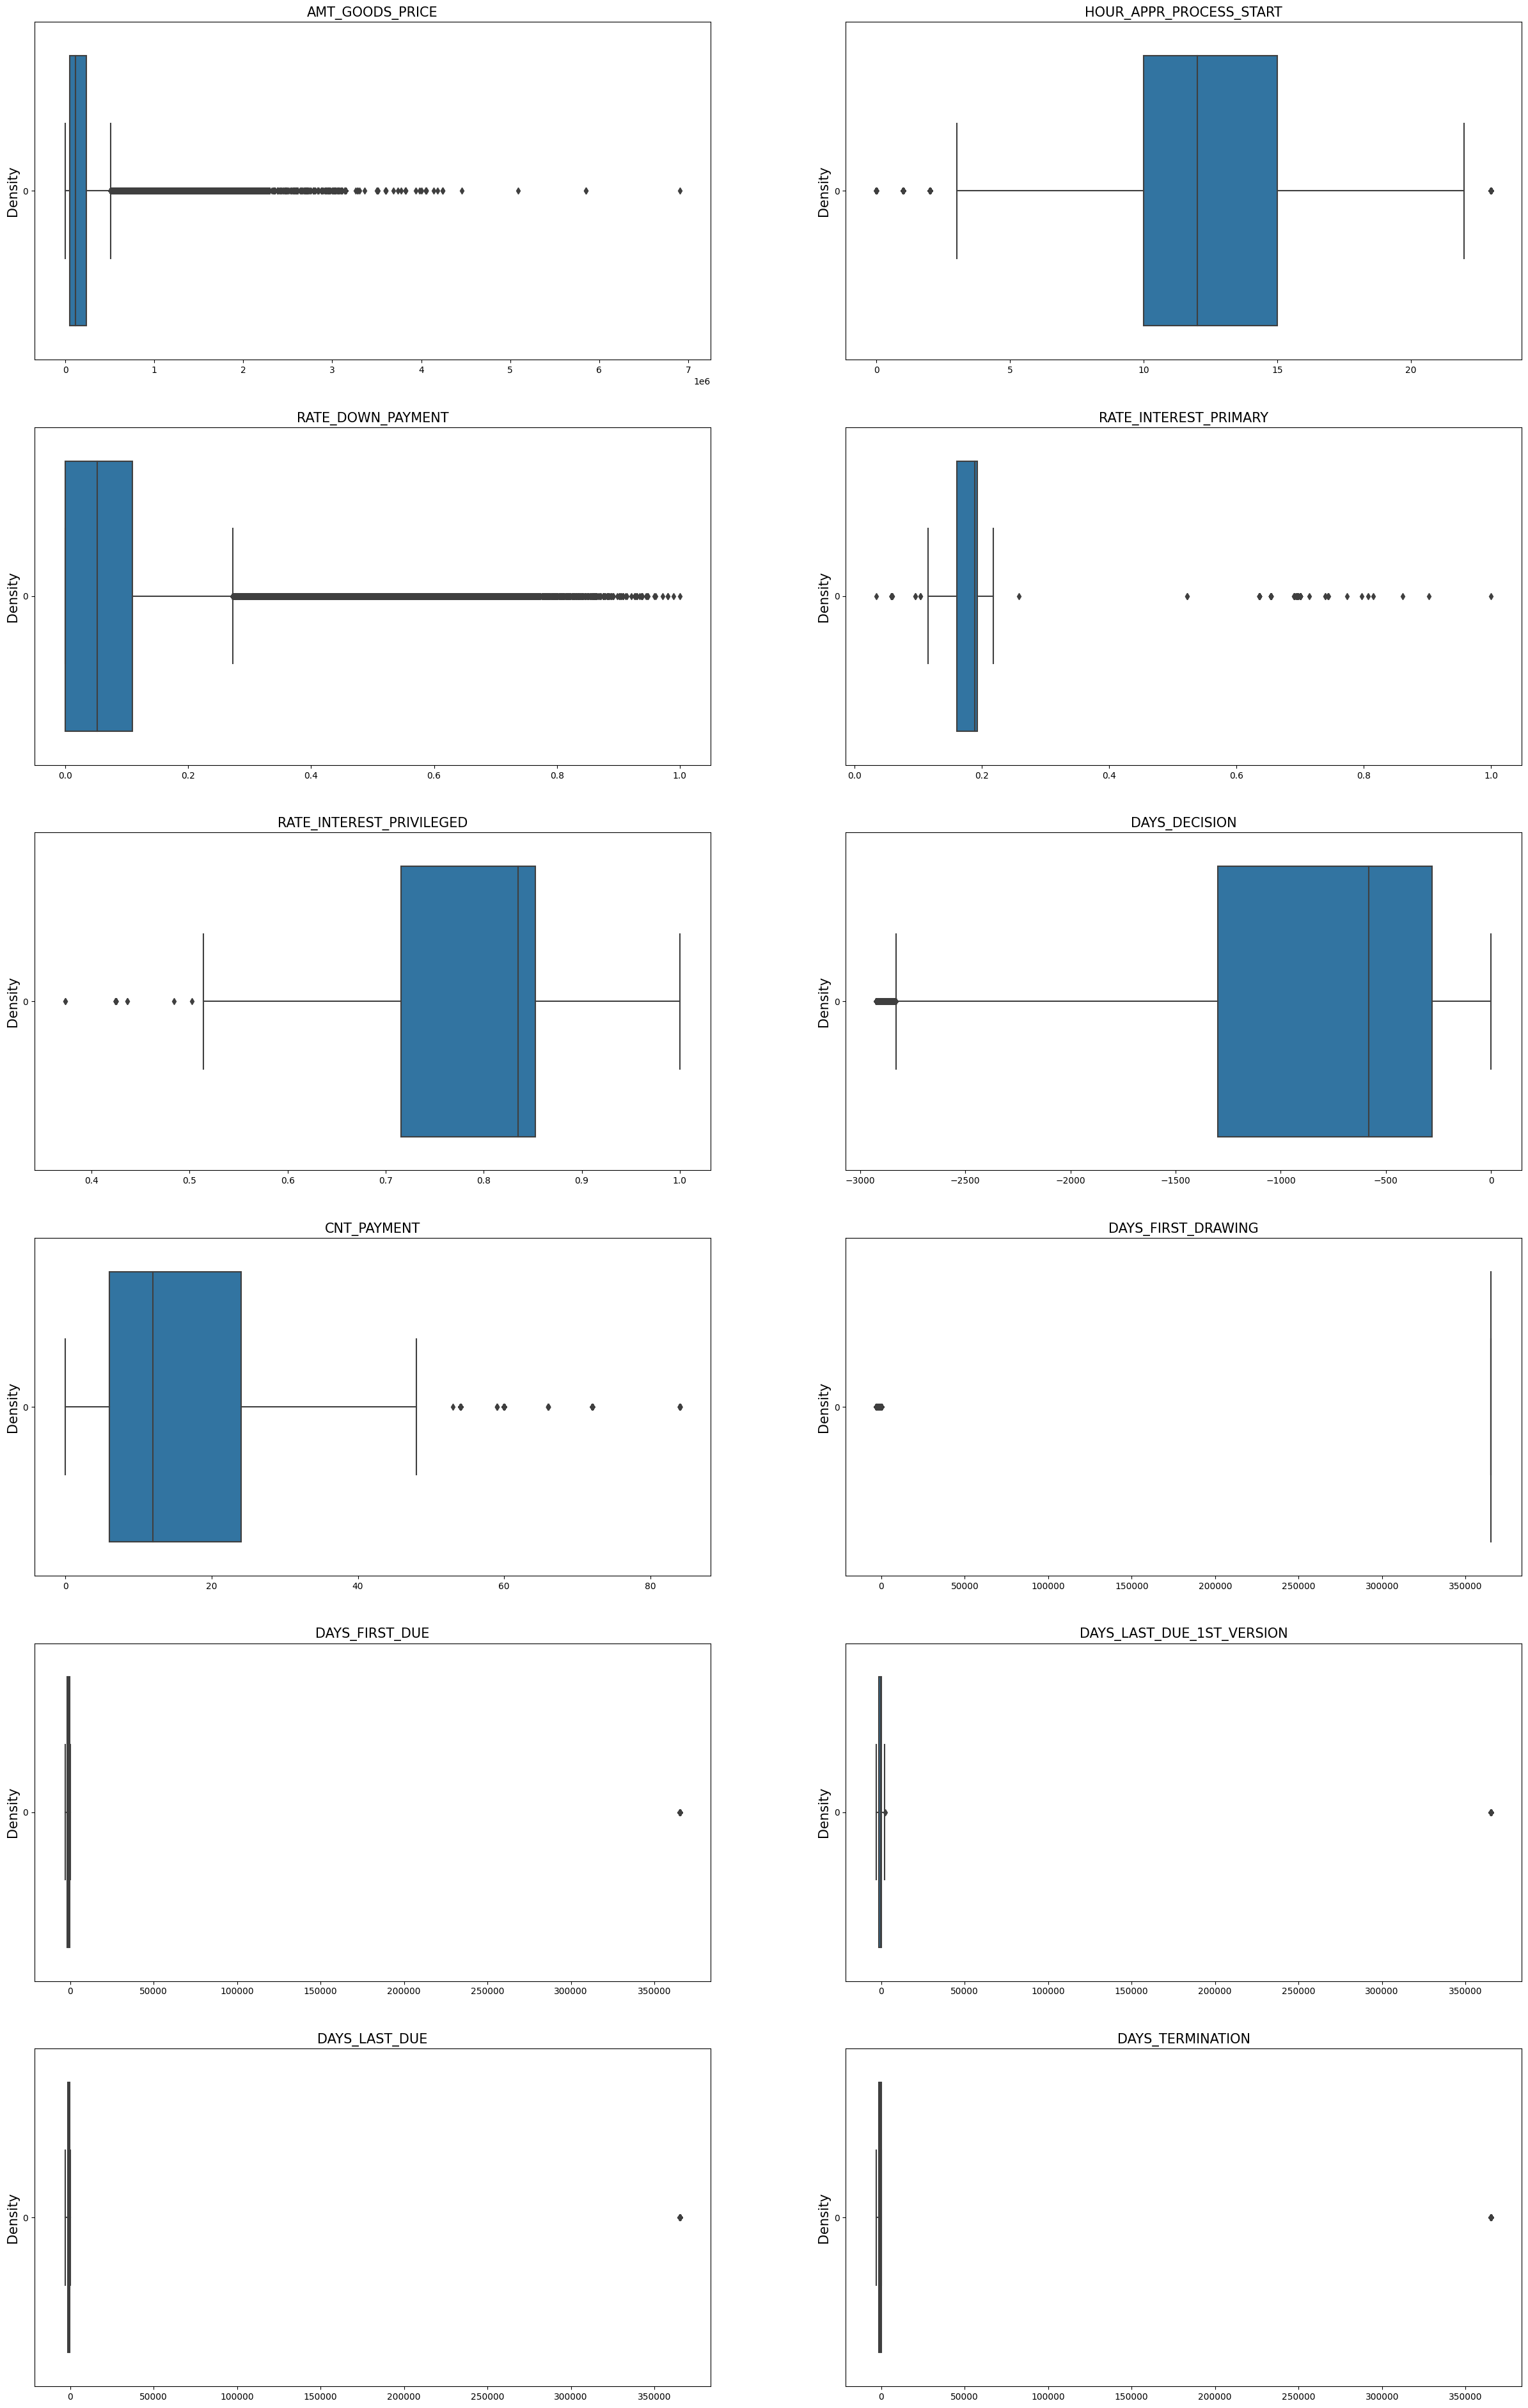

In [41]:
cols = [  'AMT_GOODS_PRICE',
       'HOUR_APPR_PROCESS_START', 
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'DAYS_DECISION',
       'CNT_PAYMENT', 
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION']
viz_df_previous_application.plot_density(columns = cols, dt = DensityTypes.Boxplot)

Observe some outliers in `DAYS_` variables. Theese must be treated.

#### Duplicates verification

In [30]:
df_train.get_duplicate_values(['SK_ID_CURR'])

0

#### Verification of nan in ID client

In [31]:
df_train.get_missing_values_by_column('SK_ID_CURR')

0

#### Removing columns with more then 60% of NaNs

In [32]:
process_df_train.drop_columns_with_nan(threshold=0.6)

#### Vriffy values that are NaN or XNA and take a decision wether we shall keep them or make a change.

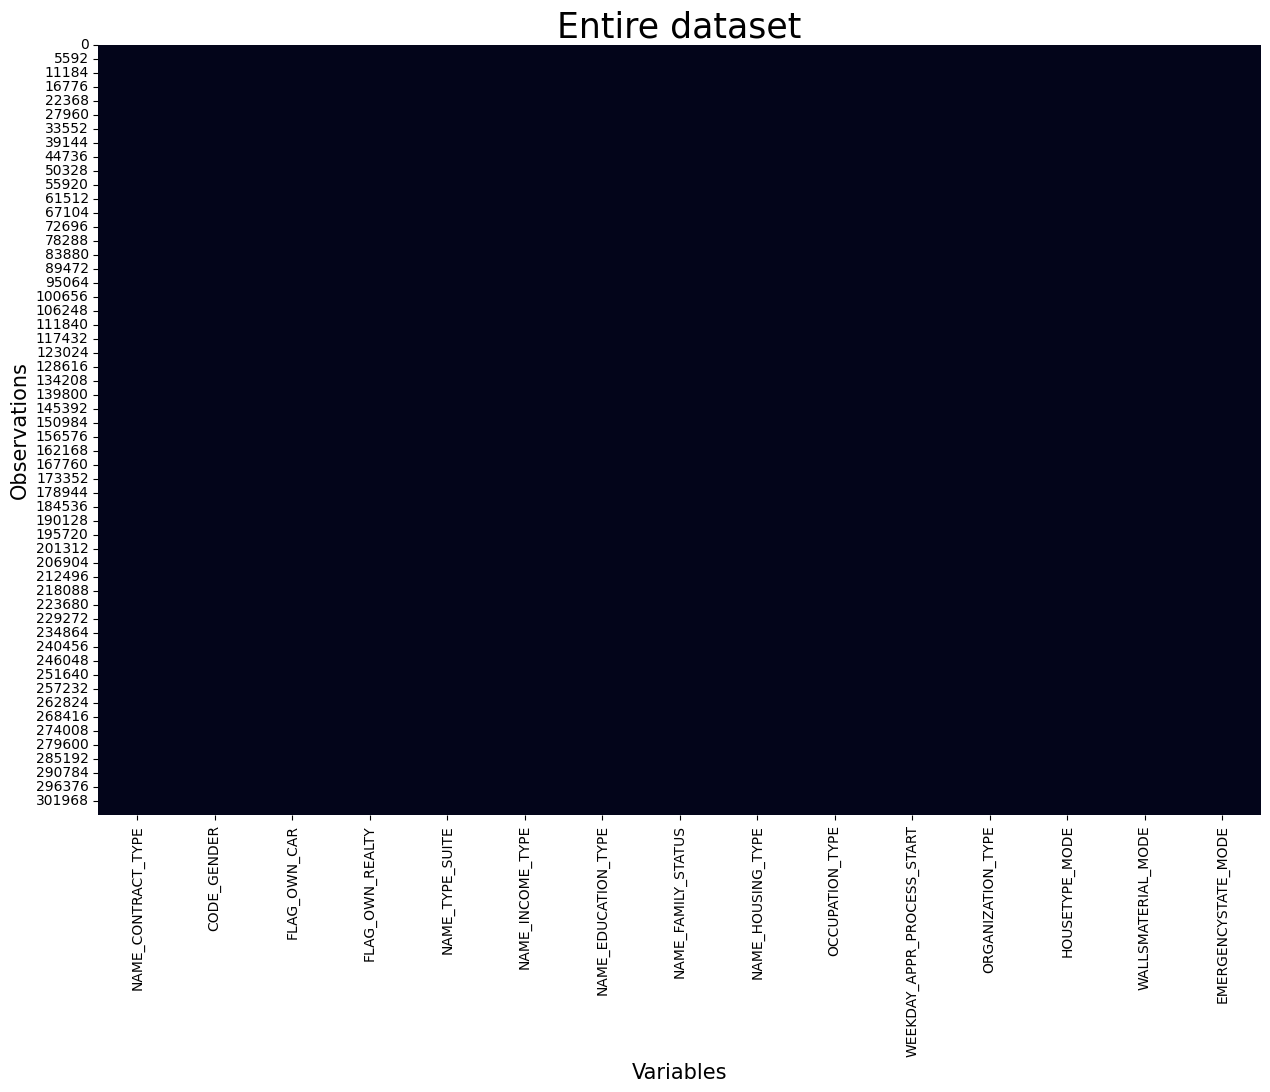

In [33]:
import numpy as np
categorical_columns = df_train.get_categorical_features()
#df_train.data[categorical_columns] = df_train.data[categorical_columns].replace({'XNA': np.nan})
process_df_train.replace_columns_with_dictionary(categorical_columns, {'XNA': np.nan})
viz_df_train.plot_data(selected_columns=categorical_columns)

In [34]:
for col in categorical_columns:
    print('There are {0} nan values in the {1} mode variable'.format(len(df_train.data[df_train.data[col].isna()]), col))

There are 0 nan values in the NAME_CONTRACT_TYPE mode variable
There are 0 nan values in the CODE_GENDER mode variable
There are 0 nan values in the FLAG_OWN_CAR mode variable
There are 0 nan values in the FLAG_OWN_REALTY mode variable
There are 0 nan values in the NAME_TYPE_SUITE mode variable
There are 0 nan values in the NAME_INCOME_TYPE mode variable
There are 0 nan values in the NAME_EDUCATION_TYPE mode variable
There are 0 nan values in the NAME_FAMILY_STATUS mode variable
There are 0 nan values in the NAME_HOUSING_TYPE mode variable
There are 0 nan values in the OCCUPATION_TYPE mode variable
There are 0 nan values in the WEEKDAY_APPR_PROCESS_START mode variable
There are 0 nan values in the ORGANIZATION_TYPE mode variable
There are 0 nan values in the HOUSETYPE_MODE mode variable
There are 0 nan values in the WALLSMATERIAL_MODE mode variable
There are 0 nan values in the EMERGENCYSTATE_MODE mode variable


Lot's of values are not given for the emergency mode that has 2 other values 'yes' and 'no'. The same think is observed for the HOUSETYPE_MODE variable. I will keep the nan value for theese variables. Also WALLSMATERIAL_MODE has a lot of nan values. But viewing the unique values we observe the Other value in WALLSMATERIAL_MODE, so we fill the nan values with 'Others' value that seems adequate. With the same logic we set the values of ORGANIZATION_TYPE XNA to Other. Also we will simplify the organization types by reducing them with making some categories: 'Industry: type 1, 2, 3....' we will name it just 'Industry'; 'Trade: type 1,2,3..' we name it 'Trade', etc.

In [36]:
df_train.data.loc[df_train.data.WALLSMATERIAL_MODE=='XNA', 'WALLSMATERIAL_MODE'] = 'Others'
df_train.data.WALLSMATERIAL_MODE.unique()

array(['Stone, brick', 'Block', 'Others', 'Panel', 'Mixed', 'Wooden',
       'Monolithic'], dtype=object)

In [37]:
categories ={
    'business entity' : ['business entity type 3', 'business entity type 2', 'business entity type 1', ],
    'industry' : ['industry: type 9', 'industry: type 3', 'industry: type 11', 'industry: type 7', 'industry: type 1', 'industry: type 4', 'industry: type 5', 'industry: type 2', 'industry: type 12', 'industry: type 6', 'industry: type 10', 'industry: type 13', 'industry: type 8'],
    'other': ['other'],
    'self-employed' : ['self-employed'],
    'medicine' : ['medicine'],
    'government' : ['government'],
    'school' : ['school' ],
    'trade' : ['trade: type 7', 'trade: type 3', 'trade: type 2', 'trade: type 6', 'trade: type 1', 'trade: type 4', 'trade: type 5'],
    'kindergarten' : ['kindergarten'],
    'construction' : ['construction'],
    'transport' : ['transport: type 4', 'transport: type 2', 'transport: type 3', 'transport: type 1'],
    'security':['security'], 
    'housing':['housing'], 
    'military':['military'],
    'bank':['bank'],
    'agriculture':['agriculture'],
    'police':['police'],
    'postal':['postal'],
    'security ministries':['security ministries'],
    'postal':['postal'],
    'restaurant':['restaurant'],
    'services' :['services', 'legal services', 'cleaning'],
    'university':['university'],
    'hotel':['hotel'],
    'electricity':['electricity'],
    'insurance':['insurance'],
    'telecom':['telecom'],
    'emergency' :['emergency'],
    'advertising':['advertising'],
    'realtor':['realtor'],
    'culture':['culture'],
    'mobile':['mobile'],
    'religion':['religion'],
}
df_train.data['ORGANIZATION_TYPE'] = df_train.data['ORGANIZATION_TYPE'].str.lower()

process_df_train.replace_column_with_dictionary('ORGANIZATION_TYPE', categories)
#for new_value, old_value in categories.items():
#    df_train['ORGANIZATION_TYPE'] = df_train['ORGANIZATION_TYPE'].replace(old_value, new_value)

In [39]:
df_train.data.loc[df_train.data.ORGANIZATION_TYPE=='XNA', 'ORGANIZATION_TYPE'] = 'Others'
df_train.data.loc[df_train.data.ORGANIZATION_TYPE=='xna', 'ORGANIZATION_TYPE'] = 'Others'
df_train.data.loc[df_train.data.ORGANIZATION_TYPE=='other', 'ORGANIZATION_TYPE'] = 'Others'
df_train.data.ORGANIZATION_TYPE.unique()

array(['business entity', 'school', 'government', 'religion', 'Others',
       'electricity', 'medicine', 'self-employed', 'transport',
       'construction', 'housing', 'kindergarten', 'trade', 'industry',
       'military', 'services', 'security ministries', 'emergency',
       'security', 'university', 'police', 'postal', 'agriculture',
       'restaurant', 'culture', 'hotel', 'bank', 'insurance', 'mobile',
       'advertising', 'telecom', 'realtor'], dtype=object)

In [40]:
df_train.data.loc[df_train.data.OCCUPATION_TYPE=='XNA', 'OCCUPATION_TYPE'] = 'Drivers'
df_train.data.OCCUPATION_TYPE.unique()

array(['Laborers', 'Core staff', 'Accountants', 'Managers', 'Drivers',
       'Sales staff', 'Cleaning staff', 'Cooking staff',
       'Private service staff', 'Medicine staff', 'Security staff',
       'High skill tech staff', 'Waiters/barmen staff',
       'Low-skill Laborers', 'Realty agents', 'Secretaries', 'IT staff',
       'HR staff'], dtype=object)

In [41]:
df_train.data.loc[df_train.data.NAME_TYPE_SUITE=='XNA' , 'NAME_TYPE_SUITE'] = 'Other'
df_train.data.loc[df_train.data.NAME_TYPE_SUITE == 'Other_A' , 'NAME_TYPE_SUITE'] = 'Other'
df_train.data.loc[df_train.data.NAME_TYPE_SUITE == 'Other_B' , 'NAME_TYPE_SUITE'] = 'Other'
df_train.data.NAME_TYPE_SUITE.unique()

array(['Unaccompanied', 'Family', 'Spouse, partner', 'Children', 'Other',
       'Group of people'], dtype=object)

#### Remove 4 applications with nan CODE_GENDER

In [46]:
df_train.data.loc[df_train.data.CODE_GENDER=='XNA']=np.nan

In [47]:
print(f"We have {len(df_train.data)} observation now.")
process_df_train.drop_rows_with_nan_in_columns(['CODE_GENDER']) #df_train.data[~df_train.data['CODE_GENDER'].isna()]
print(f"After dropping rows with nan values in code gender we have {len(df_train.data)} observation.")

We have 307511 observation now.
After dropping rows with nan values in code gender we have 307507 observation.


#### DAYS_EMPLOYED and DAYS_BIRTH outlier

In [35]:
(df_train.data['DAYS_BIRTH'] / -365).describe()

count    307507.000000
mean         43.937061
std          11.956116
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Those ages look reasonable. There are no outliers for the age on either the high or low end. How about the days of employment?

In [36]:
df_train.data['DAYS_EMPLOYED'].describe()

count    307507.000000
mean      63815.929208
std      141276.472519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

That doesn't look right! The maximum value (besides being positive) is about 1000 years!

In [37]:
len(df_train.data[(df_train.data['DAYS_EMPLOYED']>0) & (df_train.data['DAYS_EMPLOYED']!=365243)].DAYS_EMPLOYED)

0

Handling the anomalies depends on the exact situation, with no set rules. One of the safest approaches is just to set the anomalies to a missing value and then have them filled in (using Imputation) before machine learning. In this case, since all the anomalies have the exact same value, we want to fill them in with the same value in case all of these loans share something in common. 

In [48]:
# Replace the anomalous values with nan
df_train.data['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

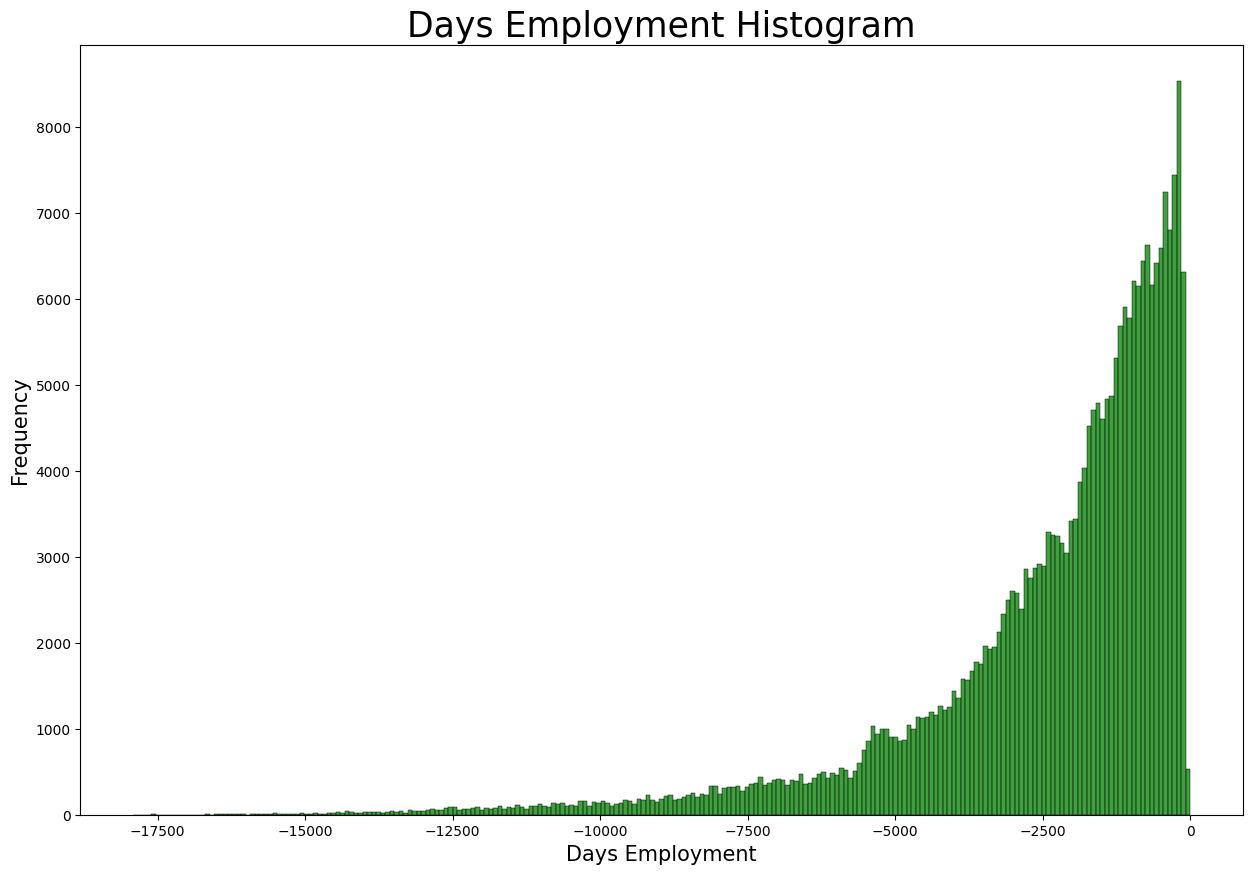

In [49]:
viz_df_train.histogram('DAYS_EMPLOYED', xlabel='Days Employment', ylabel='Frequency', title='Days Employment Histogram')

The distribution looks to be much more in line with what we would expect. We will have to fill in the nans with some value, probably the median of the column. The other columns with DAYS in the dataframe look to be about what we expect with no obvious outliers.

#### Adding some Domain knowledge features and polynomial features

Feature engineering: those win are those who can create the most useful features out of the data. (This is true for the most part as the winning models, at least for structured data, all tend to be variants on gradient boosting). This represents one of the patterns in machine learning: feature engineering has a greater return on investment than model building and hyperparameter tuning. This is a great article on the subject). As Andrew Ng is fond of saying: "applied machine learning is basically feature engineering.".

While choosing the right model and optimal settings are important, the model can only learn from the data it is given. Making sure this data is as relevant to the task as possible is the job of the data scientist (and maybe some automated tools to help us out).

Feature engineering refers to a geneal process and can involve both feature construction: adding new features from the existing data, and feature selection: choosing only the most important features or other methods of dimensionality reduction. There are many techniques we can use to both create features and select features.

 - ***Polynomial features*** : One simple feature construction method is called polynomial features. In this method, we make features that are powers of existing features as well as interaction terms between existing features. For example, we can create variables `EXT_SOURCE_1`^2 and `EXT_SOURCE_2`^2 and also variables such as `EXT_SOURCE_` x `EXT_SOURCE_2`, `EXT_SOURCE_1` x `EXT_SOURCE_2`^2, `EXT_SOURCE_1`^2 x  `EXT_SOURCE_2`^2, and so on. These features that are a combination of multiple individual variables are called interaction terms because they capture the interactions between variables. In other words, while two variables by themselves may not have a strong influence on the target, combining them together into a single interaction variable might show a relationship with the target. Interaction terms are commonly used in statistical models to capture the effects of multiple variables. Theese are not used as often in machine learning. Nonetheless, we can try out a few to see if they might help our model to predict whether or not a client will repay a loan. Scikit-Learn has a useful class called PolynomialFeatures that creates the polynomials and the interaction terms up to a specified degree. We can use a degree of 3 to see the results (when we are creating polynomial features, we want to avoid using too high of a degree, both because the number of features scales exponentially with the degree, and because we can run into problems with overfitting). 
 
 - ***Domain knowledge features*** : Maybe it's not entirely correct to call this "domain knowledge" because I'm not a credit expert, but perhaps we could call this "attempts at applying limited financial knowledge". In this frame of mind, we can make a couple features that attempt to capture what we think may be important for telling whether a client will default on a loan. Here I'm going to use five features that were inspired by this script by Aguiar:

      - `CREDIT_INCOME_PERCENT`: the percentage of the credit amount relative to a client's income
      - `ANNUITY_INCOME_PERCENT`: the percentage of the loan annuity relative to a client's income
      - `CREDIT_TERM`: the length of the payment in months (since the annuity is the monthly amount due
      - `DAYS_EMPLOYED_PERCENT`: the percentage of the days employed relative to the client's age

In [50]:
cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']
process_df_train.impute_missing_values(strategy = 'median', columns = cols)
process_df_train.set_features_with_polynomial(cols, degree=3)

In [51]:
df_train.data['CREDIT_INCOME_PERCENT'] = df_train.data['AMT_CREDIT'] / df_train.data['AMT_INCOME_TOTAL']
df_train.data['ANNUITY_INCOME_PERCENT'] = df_train.data['AMT_ANNUITY'] / df_train.data['AMT_INCOME_TOTAL']
df_train.data['CREDIT_TERM'] = df_train.data['AMT_ANNUITY'] / df_train.data['AMT_CREDIT']
df_train.data['DAYS_EMPLOYED_PERCENT'] = df_train.data['DAYS_EMPLOYED'] / df_train.data['DAYS_BIRTH']
df_train.data['INCOME_CREDIT_PERC'] = df_train.data['AMT_INCOME_TOTAL'] / df_train.data['AMT_CREDIT']
df_train.data['INCOME_PER_PERSON'] = df_train.data['AMT_INCOME_TOTAL'] / df_train.data['CNT_FAM_MEMBERS']

#### Visualize the new variables
We should explore these domain knowledge variables visually in a graph. For all of these, we will make the same KDE plot colored by the value of the TARGET.

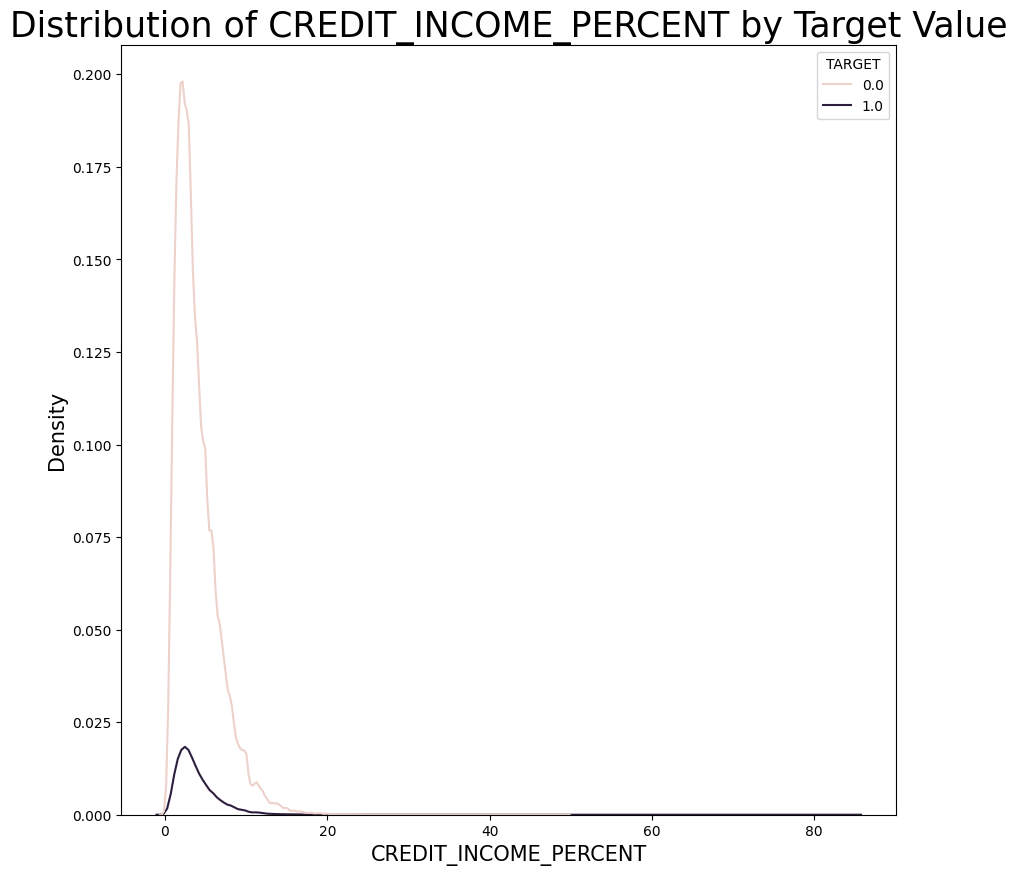

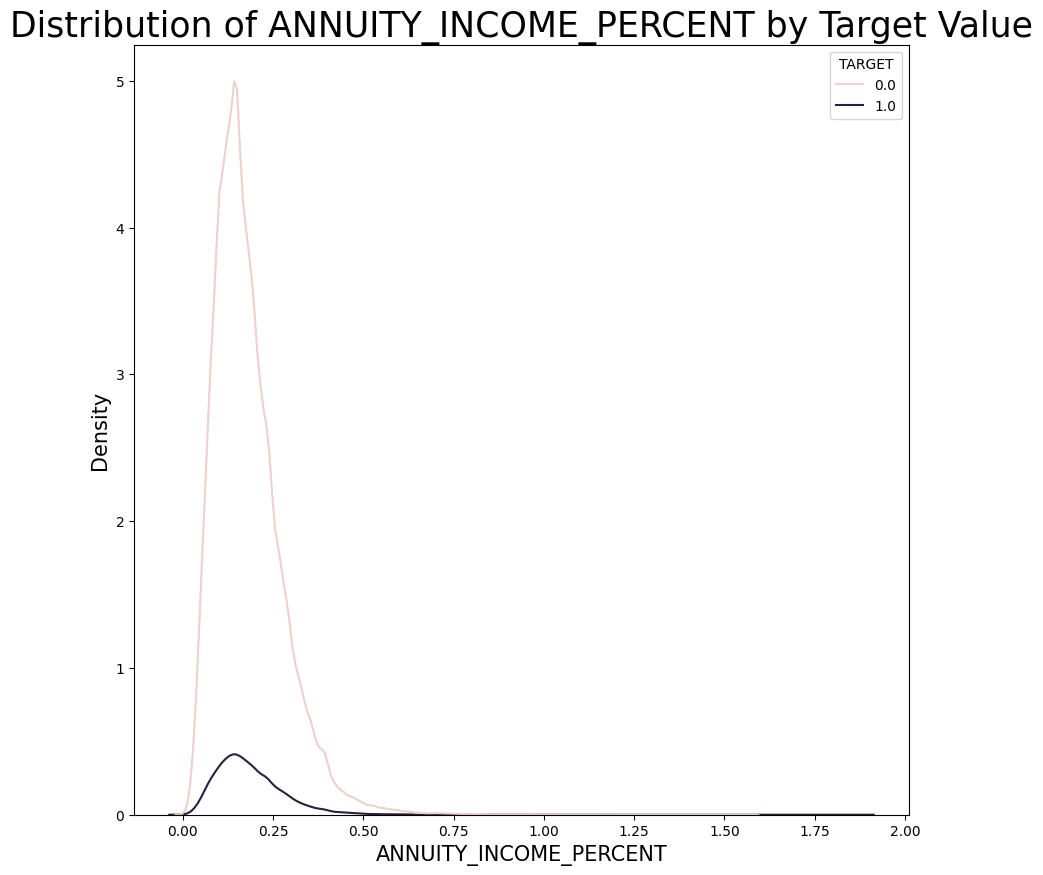

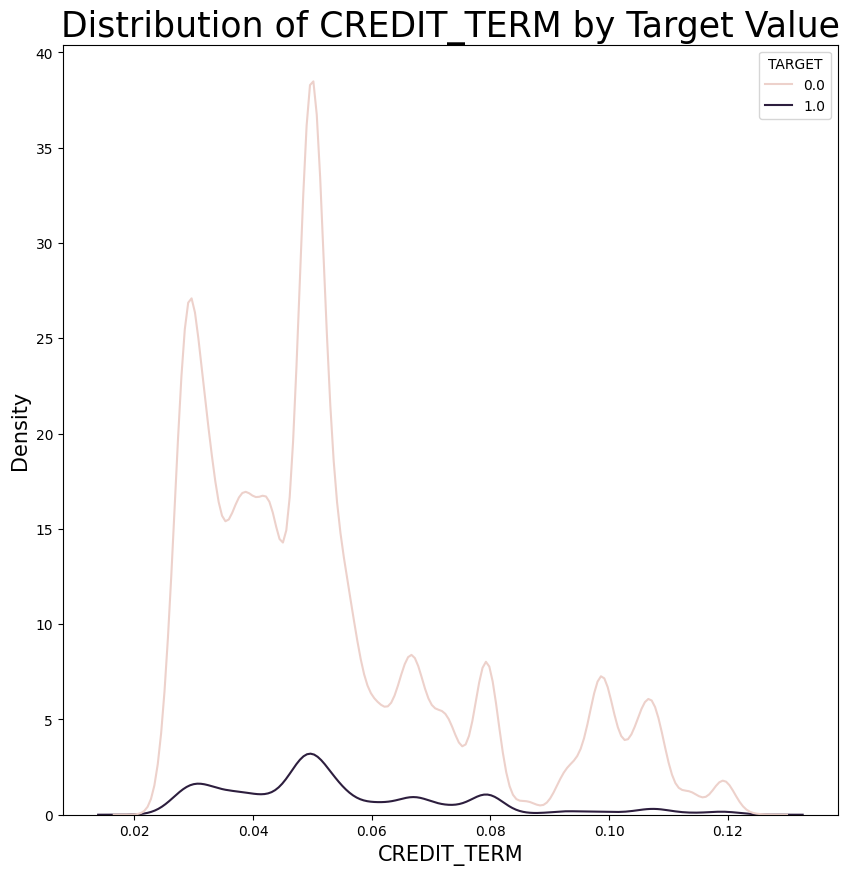

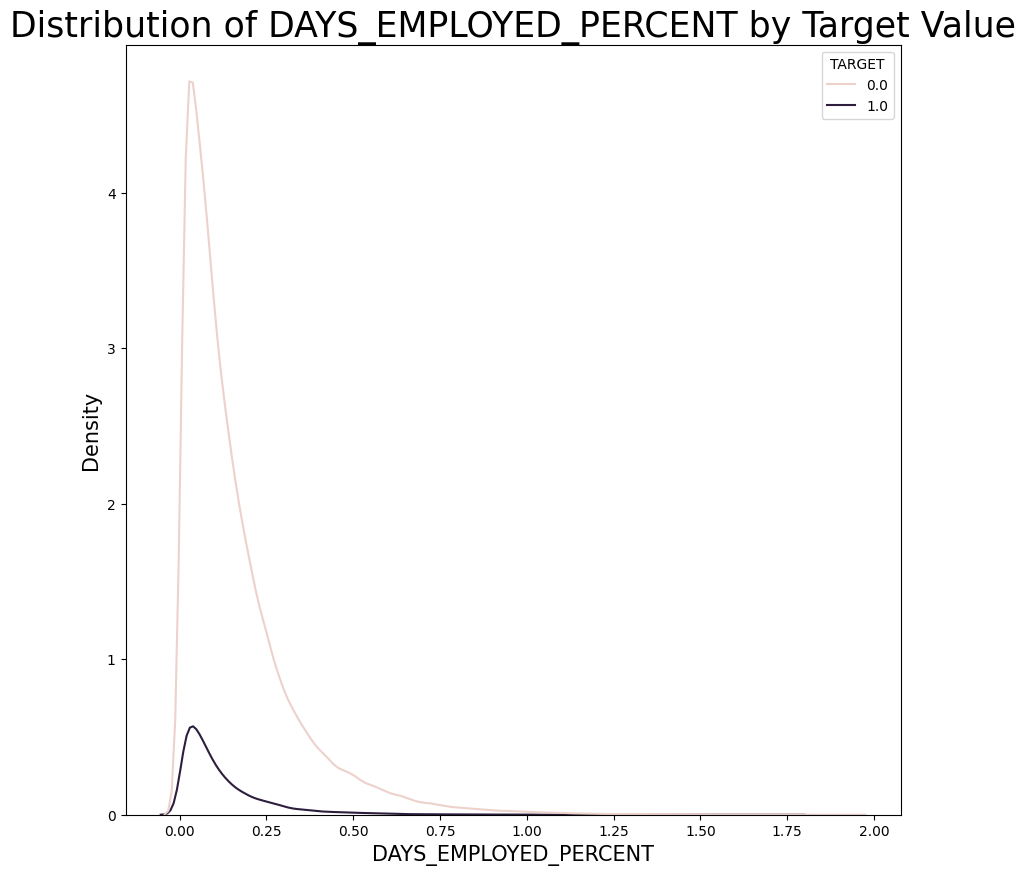

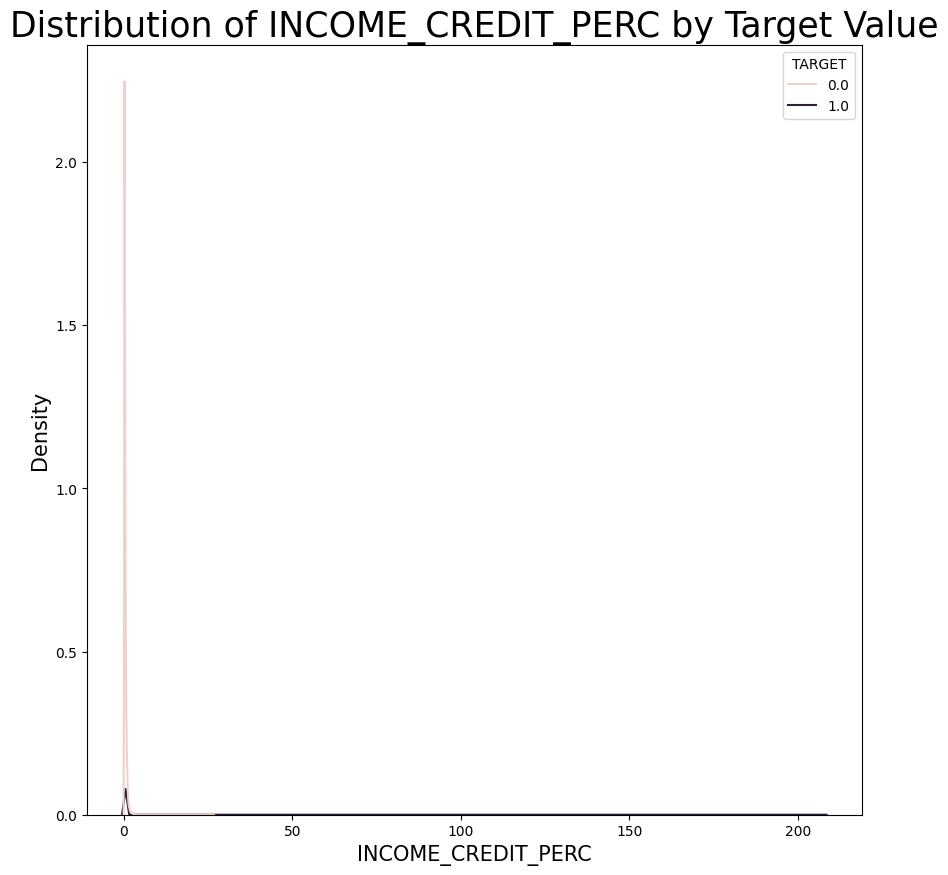

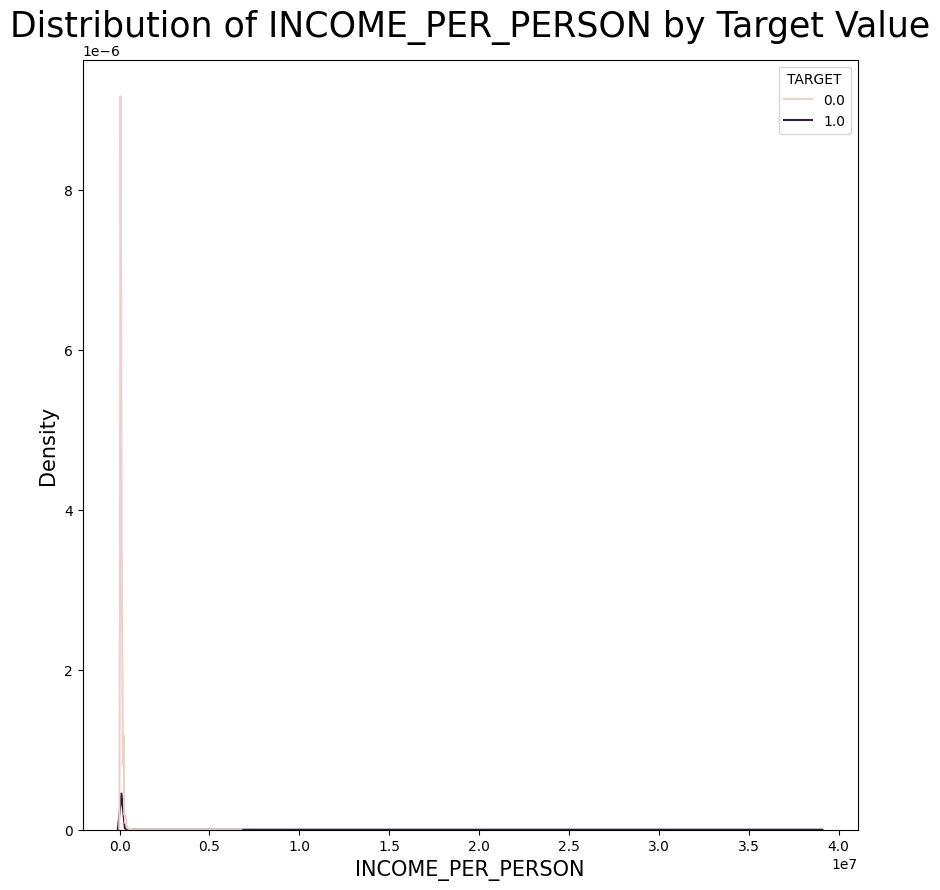

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT', 'INCOME_CREDIT_PERC', 'INCOME_PER_PERSON']):
    plt.figure(figsize=(10, 10))
    sns.kdeplot(data=df_train.data, x = feature, hue='TARGET') 
    plt.title('Distribution of %s by Target Value' % feature, fontsize=25);
    plt.xlabel('%s' % feature, fontsize=15); 
    plt.ylabel('Density', fontsize=15);

It's hard to say ahead of time if these new features will be useful. The only way to tell for sure is to use them in our training and see if theese variables were usefull!

### Bureau

#### Removing columns with more then 60% of NaNs

In [53]:
categorical_columns

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

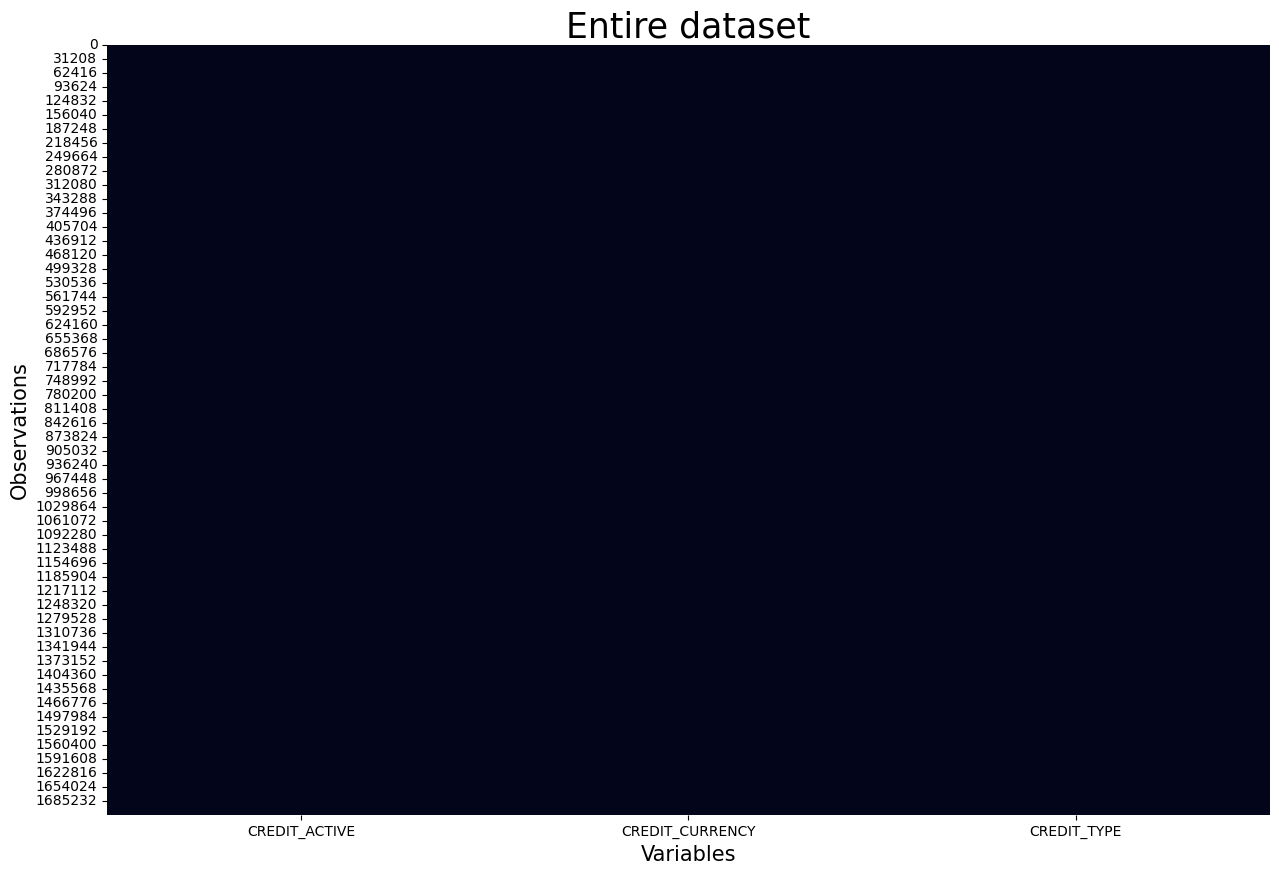

In [54]:
process_df_bureau.drop_columns_with_nan(threshold=0.6)
categorical_columns = df_bureau.get_categorical_features()
process_df_bureau.replace_columns_with_dictionary(categorical_columns, {np.nan: 'XNA'})
viz_df_bureau.plot_data(selected_columns=categorical_columns)

### Previous application

Removing columns with more then 60% of NaNs and replacing with 'Other' the nan values that rests

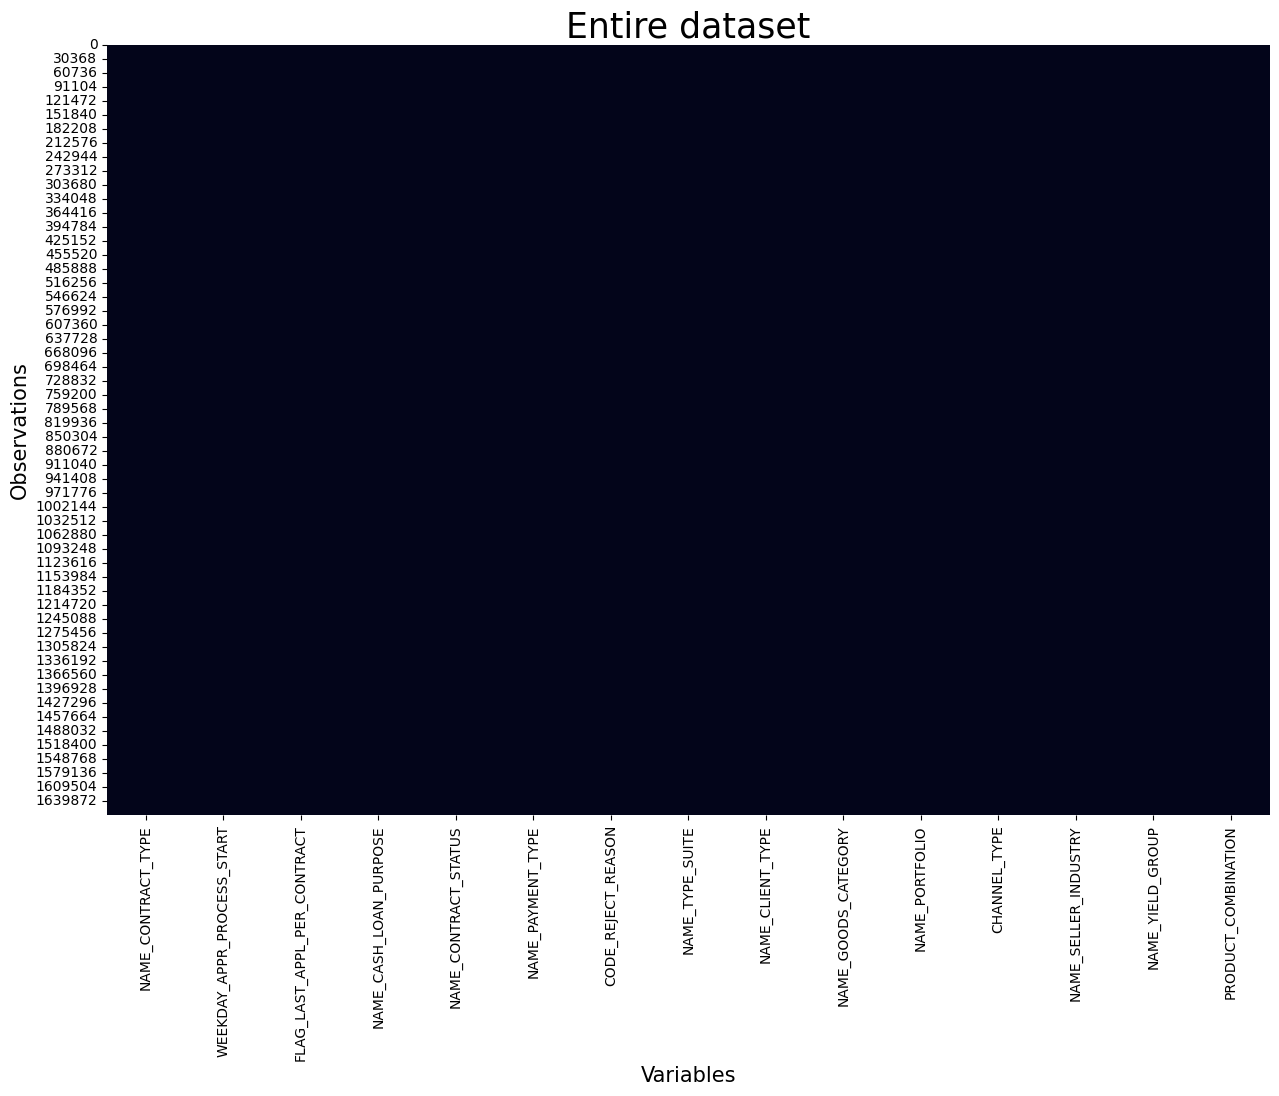

In [59]:
categorical_columns = df_previous_application.get_categorical_features()
process_df_previous_application.replace_columns_with_dictionary(categorical_columns, {np.nan: 'XNA'})
process_df_previous_application.drop_columns_with_nan(threshold=0.6)
process_df_previous_application.replace_columns_with_dictionary(categorical_columns, {'Other': np.nan})
viz_df_previous_application.plot_data(selected_columns=categorical_columns)

#### DAYS_ outlier variables

In [64]:
d={365243: np.nan}
df_previous_application.data['DAYS_FIRST_DRAWING'].replace(d, inplace = True)
df_previous_application.data['DAYS_FIRST_DUE'].replace(d, inplace = True)
df_previous_application.data['DAYS_LAST_DUE_1ST_VERSION'].replace(d, inplace = True)
df_previous_application.data['DAYS_LAST_DUE'].replace(d, inplace = True)
df_previous_application.data['DAYS_TERMINATION'].replace(d, inplace = True)

In [65]:
df_previous_application.data.DAYS_FIRST_DRAWING

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
           ..
1670209   NaN
1670210   NaN
1670211   NaN
1670212   NaN
1670213   NaN
Name: DAYS_FIRST_DRAWING, Length: 1670214, dtype: float64

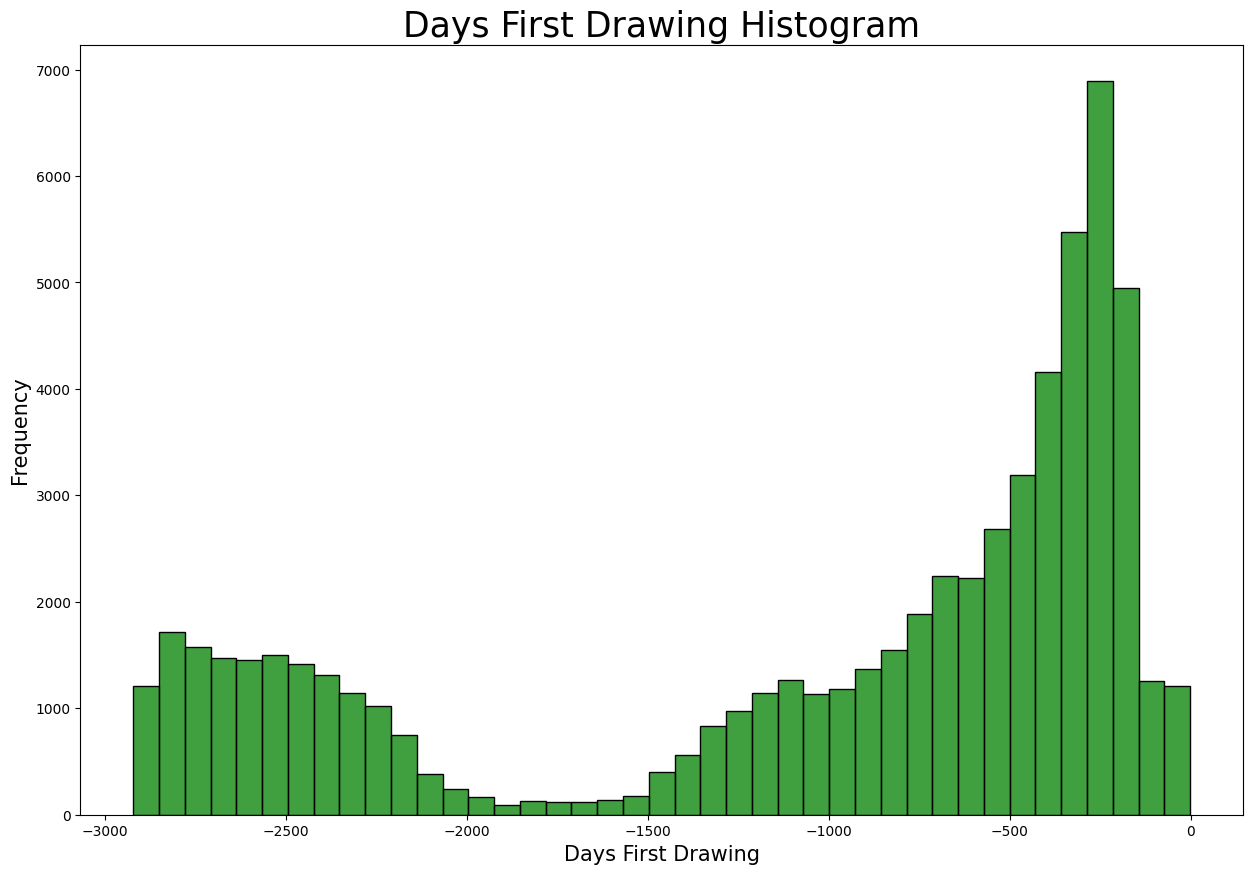

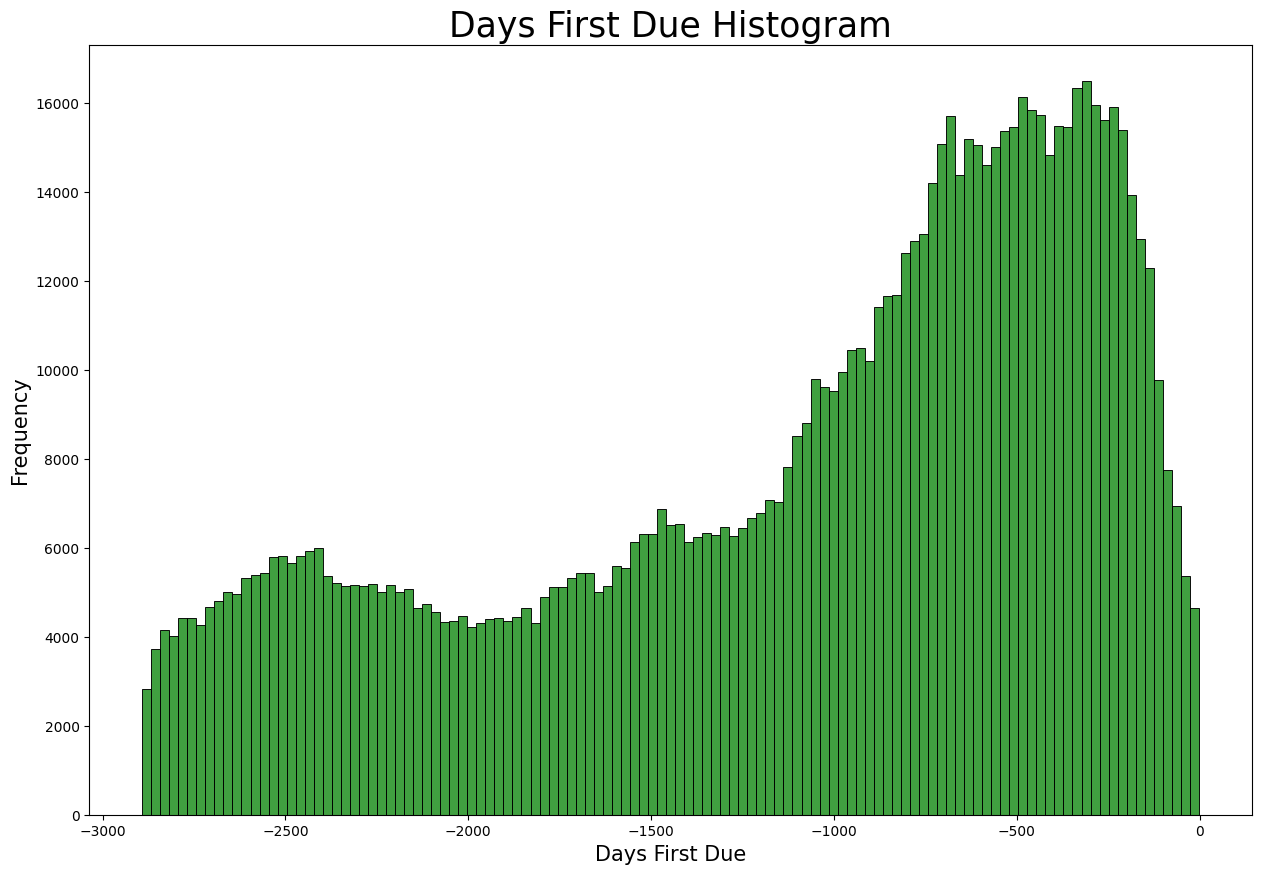

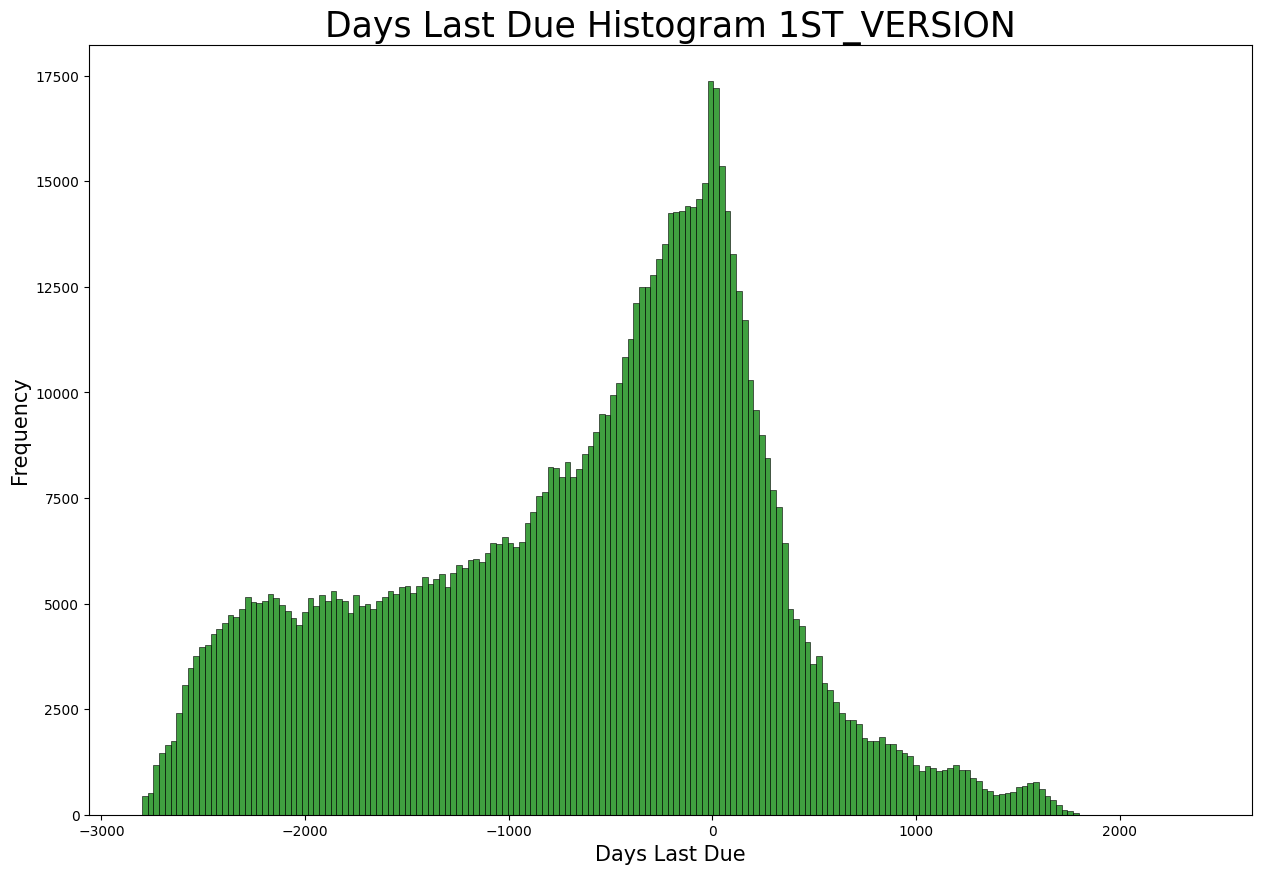

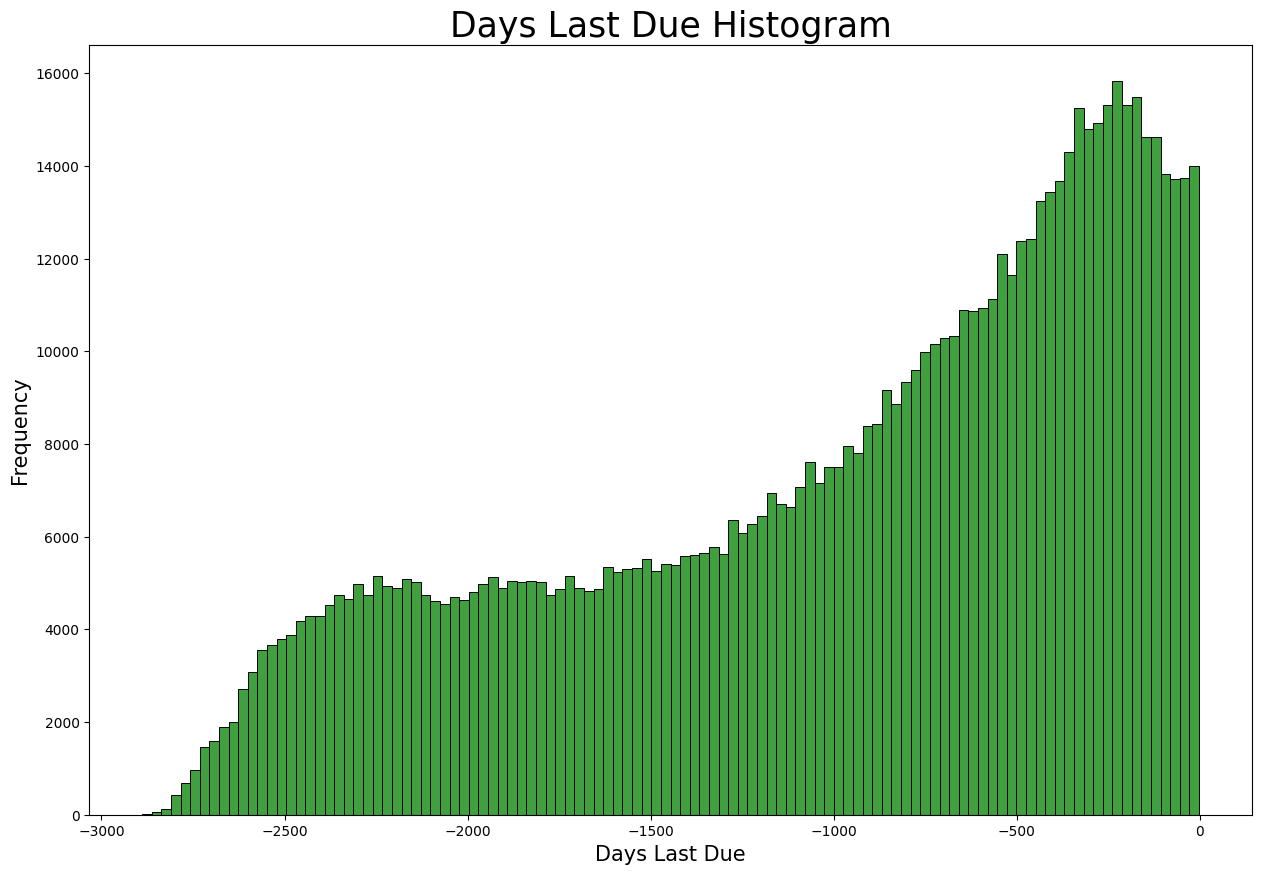

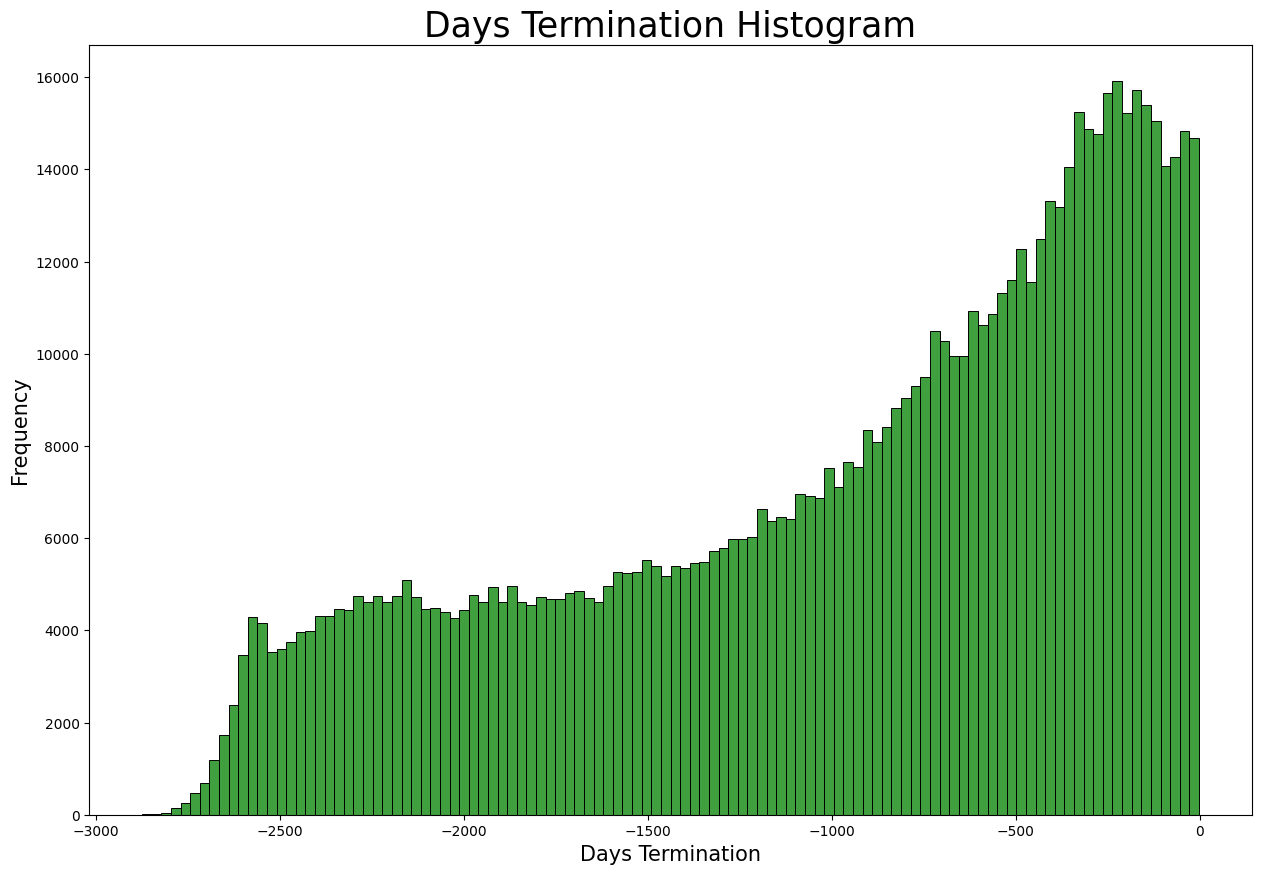

In [66]:
viz_df_previous_application.histogram('DAYS_FIRST_DRAWING', xlabel='Days First Drawing', ylabel='Frequency', title='Days First Drawing Histogram')

viz_df_previous_application.histogram('DAYS_FIRST_DUE', xlabel='Days First Due', ylabel='Frequency', title='Days First Due Histogram')

viz_df_previous_application.histogram('DAYS_LAST_DUE_1ST_VERSION', xlabel='Days Last Due', ylabel='Frequency' , title='Days Last Due Histogram 1ST_VERSION')

viz_df_previous_application.histogram('DAYS_LAST_DUE', xlabel='Days Last Due', ylabel='Frequency', title='Days Last Due Histogram')

viz_df_previous_application.histogram('DAYS_TERMINATION', xlabel='Days Termination', ylabel='Frequency', title='Days Termination Histogram')

### Deleting the datasets that will not be considerated in this work : Application test, credit card balance, installments payments, POS CAHS balance
 - We remove the test dataset because it does not contain the TARGET value, and it does not present interest in our future analyses.
 - For more simplicity on the project I consider deliting also df_bureau_balance, df_credit_card_balance, df_installments_payments, df_POS_CASH_balance

In [ ]:
del df_test, df_bureau_balance, df_credit_card_balance, df_installments_payments, df_POS_CASH_balance
gc.collect()

## Merging application dataset with bureau and previous applications

### Encoding Categorical Variables

 - ***Label encoding***: assign each unique category in a categorical variable with an integer. No new columns are created. An example is shown below
 
 - ***One-hot encoding***: create a new column for each unique category in a categorical variable. Each observation recieves a 1 in the column for its corresponding category and a 0 in all other new columns.
 
If we only have two unique values for a categorical variable (such as Male/Female), then label encoding is fine, but for more than 2 unique categories, one-hot encoding is the safe option. Therefore for any categorical variable (dtype == object) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding. For label encoding, we use the Scikit-Learn LabelEncoder and for one-hot encoding, the pandas get_dummies(df) function.

### Joining bureau and applications on the application train via SK_ID_CURR

The datasets bureau and previous applications are linked with the main dataset applciation with the SK_ID_CURR. So we can join theese together. However first we aggregate groupping toghether regarding the SK_ID_GROUP and calculating some stats (like the minimum, maximum, mean, variation) creating new features. 

In [67]:
new_cols = process_df_bureau.encode_categorical_variables(nan_as_category = True)
num_aggregations = {
            'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
            'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
            'DAYS_CREDIT_UPDATE': ['mean'],
            'CREDIT_DAY_OVERDUE': ['max', 'mean'],
            'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
            'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
            'AMT_CREDIT_SUM_OVERDUE': ['mean'],
            'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
            'CNT_CREDIT_PROLONG': ['sum']
            }
cat_aggregations = {}
for cat in new_cols: cat_aggregations[cat] = ['mean']
df_bureau.set_features_with_aggregation(groupedby_feature = 'SK_ID_CURR', aggregations = {**num_aggregations, **cat_aggregations})

new_cols = process_df_previous_application.encode_categorical_variables(nan_as_category = True)
num_aggregations = {
            'AMT_ANNUITY': ['min', 'max', 'mean'],
            'AMT_APPLICATION': ['min', 'max', 'mean'],
            'AMT_CREDIT': ['min', 'max', 'mean'],
            'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
            'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
            'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
            'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
            'DAYS_DECISION': ['min', 'max', 'mean'],
            'CNT_PAYMENT': ['mean', 'sum'],
        }
cat_aggregations = {}
for cat in new_cols: cat_aggregations[cat] = ['mean']
df_previous_application.set_features_with_aggregation(groupedby_feature = 'SK_ID_CURR', aggregations = {**num_aggregations, **cat_aggregations})

AttributeError: 'MyData' object has no attribute 'columns'

In [ ]:
df_train.data = df_train.join(df_bureau.data, how='left', on='SK_ID_CURR')
df_train.data = df_train.join(df_previous_application.data, how='left', on='SK_ID_CURR')

df_train = df_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [ ]:
df_train = process_encode_and_joining(df_train, df_previous_application, df_bureau)
del df_previous_application, df_bureau
gc.collect()

In [ ]:
df_train.shape

In [ ]:
# delete variables with one value
var_verify = df_train.nunique()>1
df_train = df_train[df_train.columns[var_verify]]
df_train.shape

In [ ]:
plot_nan_in_pourcent_from_data(df_train)

## Correlations

One way to try and understand the data is by looking for correlations between the features and the target. We can calculate the Pearson correlation coefficient between every variable and the target using the .corr dataframe method.

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some general interpretations of the absolute value of the correlation coefficent are:

 - .00-.19 “very weak”
 - .20-.39 “weak”
 - .40-.59 “moderate”
 - .60-.79 “strong”
 - .80-1.0 “very strong”

In [ ]:
with timer("Computing the correlation between variables"):
    df_train_corr = get_correlations(df_train, 'TARGET')

In [ ]:
fig = plt.figure(figsize=(25, 15));
sns.heatmap(df_train_corr);
fig.title = 'Pearson correlation coefficient between every variable'
fig.show()

We see that there are variables that are very little corelated with the TARGET. We porpose to simplify the dataset by reducing theese variables from data. Also variables that are correlated between each other could be simplified by keeping just one of theese variables.

In [ ]:
df_train.shape

#df = df_train.copy()
#hdc_make = False # high decorrelated with the TARGET
#hc_make = True # high correlated
#df_train_only_hc = remove_columns_regarding_correlation(df, df_train_corr, var='TARGET', hdc_make=hdc_make, hc_make=hc_make)
#df_train_only_hc.shape

df = df_train.copy()
hdc_make = True # high decorrelated with the TARGET
hc_make = True # high correlated
df_train_hc_and_hdc = remove_columns_regarding_correlation(df, df_train_corr, var='TARGET', hdc_make=hdc_make, hc_make=hc_make)
df_train_hc_and_hdc.shape

df_train.describe(include="all")

In [ ]:
#with timer("Imputing data with SimpleImputer stratagy median"):
#    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
#    df_train_only_hc[:] = imputer.fit_transform(df_train_only_hc)

In [ ]:
#df_train_hc_and_hdc = feature_selection(df_train_only_hc, k=200)

In [ ]:
correlations = df_train_hc_and_hdc.corr()['TARGET'].sort_values()
dd_most_negative = pd.DataFrame(correlations[(~correlations.isna()) & (correlations!='TARGET')].head(15))
dd_most_positive = pd.DataFrame(correlations[(~correlations.isna()) & (correlations!='TARGET')].tail(15))
frames = [dd_most_negative, dd_most_positive]
correlations_margins = pd.concat(frames)
del dd_most_negative, dd_most_positive, frames
correlations[~correlations.isna()]
fig = plt.figure(figsize=(15, 10));
sns.barplot(y = correlations_margins.index, x = 'TARGET', data = correlations_margins )
plt.title('Top correlations with TARGET variable',fontsize=25);
plt.xlabel('Corelation',fontsize=15);
plt.ylabel('Variables',fontsize=15);

Let's take a look at some of more significant correlations: the `DAYS_BIRTH` and the created feature `BURO_DAYS_CREDIT_MEAN` is the most positive correlation variable from the df_train. (except for `TARGET` because the correlation of a variable with itself is always 1!). The 3 variables with the strongest negative correlations with the target are `EXT_SOURCE_1`, `EXT_SOURCE_2`, and `EXT_SOURCE_3`.We can shortly thake a look at these variables. We can show the correlations of the EXT_SOURCE features with the target and with each other.

In [ ]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = df_train_hc_and_hdc[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'BURO_DAYS_CREDIT_MEAN']]
plot_correlation(ext_data)

All three `EXT_SOURCE` featureshave negative correlations with the target, indicating that as the value of the EXT_SOURCE increases, the client is more likely to repay the loan. We can also see that DAYS_BIRTH is positively correlated with EXT_SOURCE_1 indicating that maybe one of the factors in this score is the client age.

Next we can look at the distribution of each of these features colored by the value of the target. This will let us visualize the effect of this variable on the target.

In [ ]:
plt.figure(figsize = (10, 12));

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1);
    # plot repaid loans
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, source], label = 'target = 0');
    # plot loans that were not repaid
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, source], label = 'target = 1');
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source, fontsize=25);
    plt.xlabel('%s' % source, fontsize=15); 
    plt.ylabel('Density',fontsize=15);
    plt.legend();
    
plt.tight_layout(h_pad = 2.5)
    

`EXT_SOURCE_3` displays the greatest difference between the values of the target. We can clearly see that this feature has some relationship to the likelihood of an applicant to repay a loan. The relationship is not very strong (in fact they are all considered very weak, but these variables will still be useful for a machine learning model to predict whether or not an applicant will repay a loan on time.

# Data Preparation

In [ ]:
df_train = df_train_hc_and_hdc

## Imputing the nan values

In [ ]:
with timer("Imputing data with SimpleImputer stratagy median"):
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    df_train[:] = imputer.fit_transform(df_train)

## Separation of data and the target

In [ ]:
# Given data
X = df_train.drop(["TARGET"], axis=1)
# Data to predict
y = df_train["TARGET"]

## Data Normalization

In [ ]:
# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X = pd.DataFrame(std_scale.transform(X), columns=X.columns)

## Data Splitting

Split the whole dataset into a training set (80% of data) and a test set (20% of data).
The dataset will be split in a stratified way, in order to have a good distribution of the target variable.

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, stratify=y)

In [ ]:
# Save the processed data
X_train.to_csv("data/preprocess/X_train.csv", index=False)
X_test.to_csv("data/preprocess/X_test.csv", index=False)
y_train.to_csv("data/preprocess/y_train.csv", index=False)
y_test.to_csv("data/preprocess/y_test.csv", index=False)

## Rebalancing Dataset

We can take into consideration tow type of balancing the data. First with the undersampling and second the oversampling as shown in the figure.

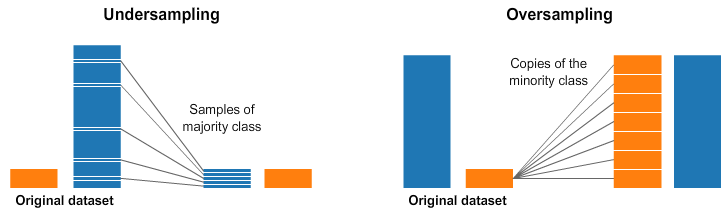

First we consider the undersampling.

In [ ]:
if os.path.exists("data/preprocess/X_train_ubalanced.csv") and os.path.exists("data/preprocess/y_train_ubalanced.csv"):
    X_train = pd.read_csv("data/preprocess/X_train_ubalanced.csv")
    y_train = pd.read_csv("data/preprocess/y_train_ubalanced.csv")
else:
    # eliminate imbalance by randomly removing data points from the majority class
    
    random_sampler = RandomUnderSampler(
        sampling_strategy=1.,
    )
    X_train, y_train = random_sampler.fit_resample(X_train, y_train)

    # Save the processed data
    X_train.to_csv("data/preprocess/X_train_ubalanced.csv", index=False)
    y_train.to_csv("data/preprocess/y_train_ubalanced.csv", index=False)
    X_train = pd.read_csv("data/preprocess/X_train_ubalanced.csv")
    y_train = pd.read_csv("data/preprocess/y_train_ubalanced.csv")

In [ ]:
plt.figure(figsize=(15,8))
sns.barplot(x = y_train.TARGET.value_counts().index, y = y_train.TARGET.value_counts(), data = y_train)
plt.title('TARGET Column distribution after under-sampling', fontsize=20);
plt.xlabel('Target labels', fontsize=15);
plt.ylabel('Frequency', fontsize=15);
plt.show();

Next we consider the oversampling.

In [ ]:
if os.path.exists("data/preprocess/X_train_obalanced.csv") and os.path.exists("data/preprocess/y_train_obalanced.csv"):
    X_train = pd.read_csv("data/preprocess/X_train_obalanced.csv")
    y_train = pd.read_csv("data/preprocess/y_train_obalanced.csv")
else:
    # eliminate imbalance by randomly removing data points from the majority class
    # transform the dataset
    X_train = pd.read_csv("data/preprocess/X_train.csv")
    y_train = pd.read_csv("data/preprocess/y_train.csv")
    
    oversample = SMOTE()
    X_train, y_train = oversample.fit_resample(X_train, y_train)

    # Save the processed data
    X_train.to_csv("data/preprocess/X_train_obalanced.csv", index=False)
    y_train.to_csv("data/preprocess/y_train_obalanced.csv", index=False)
    X_train = pd.read_csv("data/preprocess/X_train_obalanced.csv")
    y_train = pd.read_csv("data/preprocess/y_train_obalanced.csv")

In [ ]:
plt.figure(figsize=(15,8))
sns.barplot(x = y_train.TARGET.value_counts().index, y = y_train.TARGET.value_counts(), data = y_train)
plt.title('TARGET Column distribution after over-sampling', fontsize=20);
plt.xlabel('Target labels', fontsize=15);
plt.ylabel('Frequency', fontsize=15);
plt.show();

And finally the third type of dataset we create is by combining SMOTE with random undersampling of the majority class. We can update the example to first oversample the minority class to have 10 percent the number of examples of the majority class, then use random undersampling to reduce the number of examples in the majority class to have 50 percent more than the minority class.

In [ ]:
if os.path.exists("data/preprocess/X_train_oubalanced3.csv") and os.path.exists("data/preprocess/y_train_oubalanced3.csv"):
    X_train = pd.read_csv("data/preprocess/X_train_oubalanced3.csv")
    y_train = pd.read_csv("data/preprocess/y_train_oubalanced3.csv")
else:
    over = SMOTE(sampling_strategy=0.1)
    under = RandomUnderSampler(sampling_strategy=0.5)#sampling_strategy=0.1)
    steps = [('o', over), ('u', under)]
    pipeline = Pipeline(steps=steps)
    # eliminate imbalance by randomly removing data points from the majority class
    # transform the dataset
    X_train = pd.read_csv("data/preprocess/X_train.csv")
    y_train = pd.read_csv("data/preprocess/y_train.csv")
    
    X_train, y_train = pipeline.fit_resample(X_train, y_train)

    # Save the processed data
    X_train.to_csv("data/preprocess/X_train_oubalanced3.csv", index=False)
    y_train.to_csv("data/preprocess/y_train_oubalanced3.csv", index=False)
    X_train = pd.read_csv("data/preprocess/X_train_oubalanced3.csv")
    y_train = pd.read_csv("data/preprocess/y_train_oubalanced3.csv")

In [ ]:
plt.figure(figsize=(15,8))
sns.barplot(x = y_train.TARGET.value_counts().index, y = y_train.TARGET.value_counts(), data = y_train)
plt.title('TARGET Column distribution after mixed-sampling', fontsize=20);
plt.xlabel('Target labels', fontsize=15);
plt.ylabel('Frequency', fontsize=15);
plt.show();

In [ ]:
from imblearn.over_sampling import ADASYN
if os.path.exists("data/preprocess/X_train_adisonbalanced.csv") and os.path.exists("data/preprocess/y_train_adisonbalanced.csv"):
    X_train = pd.read_csv("data/preprocess/X_train_adisonbalanced.csv")
    y_train = pd.read_csv("data/preprocess/y_train_adisonbalanced.csv")
else:
    pipeline = Pipeline(steps=steps)
    # eliminate imbalance by randomly removing data points from the majority class
    # transform the dataset
    X_train = pd.read_csv("data/preprocess/X_train.csv")
    y_train = pd.read_csv("data/preprocess/y_train.csv")
    
    oversample = ADASYN()
    X_train, y_train = oversample.fit_resample(X_train, y_train)

    # Save the processed data
    X_train.to_csv("data/preprocess/X_train_adisonbalanced.csv", index=False)
    y_train.to_csv("data/preprocess/y_train_adisonbalanced.csv", index=False)
    X_train = pd.read_csv("data/preprocess/X_train_adisonbalanced.csv")
    y_train = pd.read_csv("data/preprocess/y_train_adisonbalanced.csv")

In [ ]:
plt.figure(figsize=(15,8))
sns.barplot(x = y_train.TARGET.value_counts().index, y = y_train.TARGET.value_counts(), data = y_train)
plt.title('TARGET Column distribution after mixed-sampling', fontsize=20);
plt.xlabel('Target labels', fontsize=15);
plt.ylabel('Frequency', fontsize=15);
plt.show();

# Loading dataset

In [ ]:
X_train = pd.read_csv("data/preprocess/X_train_oubalanced.csv")
y_train = pd.read_csv("data/preprocess/y_train_oubalanced.csv")
X_test = pd.read_csv("data/preprocess/X_test.csv")
y_test = pd.read_csv("data/preprocess/y_test.csv")

# ACP

Now, we can start to create our models in order to make predictions on TARGET. But, first we can make a PCA in order to project the observations and see them in a 2D plan. We take 75 principal components that cover more then 80% of information in data.

In [ ]:
X = X_train.values
names = X_train.index #["product_name"] # ou data.index pour avoir les intitulés
features = X_train.columns

# choix du nombre de composantes à calculer
n_comp = 2

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_train)

X_projected = pca.fit_transform(X_train)


X_projected = pd.DataFrame(X_projected, index = names, columns = ['F{0}'.format(i) for i in range(n_comp)])

# Eboulis des valeurs propres
#display_scree_plot(pca)

In [ ]:
pd.concat([X_projected, y_train], axis=1).TARGET.unique()

In [ ]:
y_train = y_train.astype({'TARGET': 'int32'})

In [ ]:
plt.figure(figsize=(15,8));
sns.scatterplot(
        x='F0',
        y='F1',
    hue = 'TARGET',
    data = pd.concat([X_projected, y_train], axis=1),
    #size=1
);

In the previous figure we observe that we have observations that are not easly separated with a line. Also it will be difficult to find a model without an over-learning. The risc to find a lot of FP (false positives) and FN (false negative) is high. Therefore, in order to evaluate our models a simple accurancy metric is not sufficient, and a contingency matrix is higher recomended for such classifications problems.

# Modeling and evaluation

Here we will create our models to classify our dataset and evaluate their performance regarding different criterions. First the execution times. Second we see the model interpretability. Note that some models can give us some information about what are the features that are used for our predictions. And finally, and the most important that is the performance regarding different metrics like `accuracy`, `precision`, `recall`, `F1 score`. Also note here that we have a problem where the two classes is unbalanced with `TARGET=0` about 92%. Therefore here we want to maximize the recall for predicting the payment problem. Therefore we use a  `Fbeta score` and try to adapt `beta` parameter to maximize the `recall`.

StratifiedKFold() is used to mix the results in multiple data samplings.
HalvingRandomSearchCV() is used to find the best hyper-parameters and to give the best found model.

I trained the data with a separate using the separate file `models_computation.py` that can be shared on demand. The resulted models are available in files loaded next.

In [ ]:
results = pd.read_csv("models/results2_2.csv", index_col=0)
with open("models/models_all_beta2.pckl", "rb") as f:
    models = pickle.load(f)

Plotting some of our results, starting with the dummy classifier. For a naive baseline, we could guess the same value for all examples on the testing set. We are asked to predict the probability of not repaying the loan, so if we are entirely unsure, we would guess 0.5 for all observations on the test set. This will get us a Reciever Operating Characteristic Area Under the Curve (AUC ROC) of 0.5 in the competition. We try other 8 models to get a higher score.

In [ ]:
plot_result_stats(models['dummy'], title_fig = 'Dummy Classifier')

Let's know use a slightly more sophisticated model for our actual baseline: ***Logistic regression***.

To get a baseline, we will use all of the features after encoding the categorical variables. We will preprocess the data by filling in the missing values (imputation) and normalizing the range of the features (feature scaling). The following code performs both of these preprocessing steps.

Logistic regression is a form of supervised learning classification algorithm that predicts the probability of a target variable. The target or dependent variable is dichotomous. It means there will be only two possible classes. 

In [ ]:
plot_result_stats(models['logreg'], title_fig = 'Logistic regression')

In [ ]:
plot_varimportance(model_res = models['logreg'], cols = X_train.columns, cols_nr = 20)

Observe that logistic regression can return the features that are used to fit the data. We show the top 15 features in the model. We see some features created from Buro and previous applications. Some poynomial created variables are also important for our model.

The ***k-nearest neighbors (KNN)*** algorithm is a data classification method. It estimates the possibility that a data point will become a member of any of the groups based on what group the data points nearest to it belong to.

In [ ]:
plot_result_stats(models['knn'], title_fig = 'KNN Classifier')

A ***decision tree*** is a Supervised learning technique. It can work in both classification and Regression problems but has a preference in solving classification problems. In a tree-structured classifier, the internal nodes represent the features of a dataset, branches represent the decision rules, and each leaf node represents the outcome.

In [ ]:
plot_result_stats(models['dctree'], title_fig = 'Decision Tree Classifier') 

In [ ]:
plot_varimportance(model_res = models['dctree'], cols = X_train.columns, cols_nr = 20)

***Naïve Bayes*** algorithm comes under the supervised learning algorithm category and is a simple classification algorithm that helps build fast machine learning models that can make quick predictions. The algorithm predicts based on the probability of an object and is also known as a probabilistic classifier.

In [ ]:
plot_result_stats(models['naivebayes'], title_fig = 'Naive Bayes')

***“Support Vector Machine” (SVM)*** is a supervised ML algorithm commonly used for classification and regression challenges. However, the preference is for use in classification problems. In an SVM algorithm (if N is a number of features), we plot each data item as a point in the N-dimensional space, with each feature being the value of a particular co-ordinate. We then perform classification by finding the hyper-plane that differentiates the two classes.

In [ ]:
plot_result_stats(models['svc'], title_fig = 'SVC')

In [ ]:
plot_varimportance(model_res = models['svc'], cols = X_train.columns, cols_nr = 15)

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

- Faster training speed and higher efficiency.
- Lower memory usage.
- Better accuracy.
- Support of parallel and GPU learning.
- Capable of handling large-scale data.

At present, decision tree based machine learning algorithms dominate Kaggle competitions. The winning solutions in these competitions have adopted an alogorithm called XGBoost.

A couple of years ago, Microsoft announced its gradient boosting framework LightGBM. Nowadays, it steals the spotlight in gradient boosting machines. Kagglers start to use LightGBM more than XGBoost. LightGBM is 6 times faster than XGBoost.

Light GBM is a relatively new algorithm and have long list of parameters given in the LightGBM documentation,

The size of dataset is increasing rapidly. It is become very difficult for traditional data science algorithms to give accurate results. Light GBM is prefixed as Light because of its high speed. Light GBM can handle the large size of data and takes lower memory to run.

Another reason why Light GBM is so popular is because it focuses on accuracy of results. LGBM also supports GPU learning and thus data scientists are widely using LGBM for data science application development.

It is not advisable to use LGBM on small datasets. Light GBM is sensitive to overfitting and can easily overfit small data.

In [ ]:
plot_result_stats(models['lgbm'], title_fig = 'LGBM Classifier')

In [ ]:
plot_varimportance(model_res = models['lgbm'], cols = X_train.columns, cols_nr = 20)

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.

XGBoost is a very fast and accurate ML algorithm. But now it's been challenged by LightGBM — which runs even faster with comparable model accuracy and more hyperparameters for users to tune.

The key difference in speed is because XGBoost split the tree nodes one level at a time and LightGBM does that one node at a time.

So XGBoost developers later improved their algorithms to catch up with LightGBM, allowing users to also run XGBoost in split-by-leaf mode (grow_policy = ‘lossguide’). Now XGBoost is much faster with this improvement, but LightGBM is still about 1.3X — 1.5X the speed of XGB.

Another difference between XGBoost and LightGBM is that XGBoost has a feature that LightGBM lacks — monotonic constraint. It will sacrifice some model accuracy and increase training time, but may improve model interpretability.

In [ ]:
plot_result_stats(models['xgboost'], title_fig = 'XGB Classifier')

In [ ]:
plot_varimportance(model_res = models['xgboost'], cols = X_train.columns, cols_nr = 20)

In [ ]:
df=pd.DataFrame(results, columns=["f1", "fbeta", "accuracy", "precision", "recall", "roc_auc_score"]).T
df = df.reset_index(level=0)
df.plot(x="index", y=["knn", "dctree", "naivebayes", "svc", "dummy", "logreg", "randforest", "xgboost", "lgbm"], kind="bar",figsize=(30,20))
plt.title('The obtained scores for the trained models',size=25)
plt.xlabel('Scores', size=20);
plt.tick_params(axis='both', labelsize=15)
plt.show()

First I note that the prediction time for KNN was slow and I choose not to show (45.58 s) it in the following figure.

In [ ]:
df=pd.DataFrame(results, columns=["predict_time"]).T.div(60)
df = df.reset_index(level=0)

df.plot(x="index", y=["dctree", "naivebayes", "svc", "dummy", "logreg", "randforest", "xgboost", "lgbm"], kind="bar",figsize=(15,10));
plt.tick_params(right = False , 
                labelbottom = False, bottom = False);
plt.xlabel('Prediction time', size=20);
plt.ylabel('seconds', size=20);
plt.title('Predicted time',size=25)
plt.tick_params(axis='both', labelsize=15)
plt.show()

In [ ]:
results1 = pd.read_csv("models/results2.csv", index_col=0)
results2 = pd.read_csv("models/results3.csv", index_col=0)
results3 = pd.read_csv("models/results4.csv", index_col=0)
results4 = pd.read_csv("models/results5.csv", index_col=0)
results5 = pd.read_csv("models/results6.csv", index_col=0)
results6 = pd.read_csv("models/results7.csv", index_col=0)
results7 = pd.read_csv("models/results8.csv", index_col=0)
results8 = pd.read_csv("models/results9.csv", index_col=0)

frames = [results1, results2, results3, results4, results5, results6, results7, results8]
result = pd.concat(frames)
result = result.drop(['xgboost', 'lgbm'])

In [ ]:
df=pd.DataFrame(result, columns=["fbeta"]).T
df = df.reset_index(level=0)
df.plot(x="index", y=["xgboost2", "xgboost5", "xgboost9", "lgbm2", "lgbm5", "lgbm9"], kind="bar",figsize=(30,20), label=['XGBoost beta=2', 'XGBoost beta=5', 'XGBoost beta=9', 'LGBM beta=2', 'LGBM beta=5', 'LGBM beta=9'])
plt.title('F-Beta Score for XGBoost and LGBM models',size=25)
plt.xlabel('F-Beta Score', size=20);
plt.tick_params(axis='both', labelsize=15)
plt.tick_params(right = False , 
                labelbottom = False, bottom = False);
plt.legend(loc=2, prop={'size': 16})
plt.show()

In [ ]:
with open("models/models9.pckl", "rb") as f:
    models9 = pickle.load(f)
with open("models/models2.pckl", "rb") as f:
    models2 = pickle.load(f)
#plot_result_stats(models['lgbm9'], title_fig = 'LGBM Classifier')

# Model Exlpications
 - it is important to understand the performance of the machine learning models
 - ML metrics like accuracy, mean squared error, r2 score, etc does not give detailed insight into the performance of the model
 - eli5, LIME, SHAP, interpret,treeinterpreter, etc are available to debug models to better understand a model and its performance on any sample of the data.
 - help us better understand which feature is contributing to how in prediction.
 - We will use LIME (Local Interpretable Model-Agnostic Explanations Local Interpretable Model-Agnostic Explanations) and SHAP (SHapley Additive exPlanations) to analyze the performance of machine learning models.

In [ ]:
sample_idx = 10

## LIME

In [ ]:
import lime
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(X_train.to_numpy(), feature_names= list(X_train.columns))

explanation = explainer.explain_instance(X_test.iloc[sample_idx],
                                        models9['lgbm9']['model'].predict_proba, 
                                         num_features=20)
explanation.show_in_notebook()

One can see that the selected client will not have problems for loan payment `TARGET = 0` with 0.86 predicted probability.

## SHAP

In [ ]:
import shap
shap.initjs()

print('True value : {0}'.format(y_test.iloc[sample_idx]))

Below we have created ***Explainer*** by giving model and train data as input. This will create an explainer which does not take the relationship between features considering the correlation between features.

In [ ]:
explainer = shap.Explainer(models9['lgbm9']['model'], X_train)

Below we have created another LinearExplainer by giving model and train data as input. We have also set feature_perturbation to correlation_dependent. This will create an explainer which takes into account the relationship between features.

Generating a ***bar chart*** of shap values from our first explainer

In [ ]:
shap.bar_plot(explainer.shap_values(X_test.iloc[sample_idx]),
              feature_names=X_train.columns,
              max_display=15)

We can see from the above bar chart that for this sample of data features (`CREDIT_TERM`, `EXT_SOURCE_3`, `EXT_SOURCE_2`,...) contribute negatively and features (`DAYS_EMPLOYED`, `FLAG_OWN_CAR_Y`, `PREV_NAME_TYPE_SUITE_nan_MEAN` ...) contributes positively for final prediction.

Another chart that we'll explain is a ***waterfall chart*** which shows how shap values of individual features are added to the base value in order to generate a final prediction. Below is a list of important parameters of the waterfall_plot() method.

We generate a waterfall plot for the first explainer object which does not consider the interaction between objects.

In [ ]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value,
                    lin_reg_explainer1.shap_values(X_test.iloc[sample_idx]),
                    feature_names=X_train.columns,
                    max_display=20);

The ***force plot*** shows shap values contributions in generating final prediction using an additive force layout. It shows which features contributed to how much positively or negatively to base value to generate a prediction. We can generate force plot using force_plot() method. Below are list of important parameters for force_plot() method.

Below we have generated a force plot of the first test sample using the first linear explainer. We can see the magnitude of positivity and negativity of features in the chart.

In [ ]:
shap.force_plot(explainer.expected_value,
                explainer.shap_values(X_test.iloc[sample_idx]),
                feature_names=X_train.columns,
                out_names="TARGET=0")

As for the LIME, we see that the predicted class will be `TARGET=0`, that is considered as negative class. As for the LIME, we can see that the features that explaines the model decision are the same. Also the same features plays an oposite role having an role predicting `TARGET=1`.

We observe that the `EXT_SOURCE_1`, `EXT_SOURCE_2`, `EXT_SOURCE_3` has the role to predict this client to have payed the loan. Also this is a feminine client, that owns a car. She has also a high education. 
One can alos observe some variables that played the role to predict that this client will not pay the loan is that she is married and the days that is employed.